# Time series

>The only reason for time is so that everything doesn't happen at once.
>
> ~ Albert Einstein

### Outline

0. Setting up for the analysis
1. Data integration
2. Basics
3. Economic simulation
4. Stock modeling
5. Statistics
6. Predicting stock value
7. What to invest in - simple regression into applying stock data
8. Homework

### Detalied Outline

0. Setting up for the analysis (imports, plot settings, SparkContext, etc.)

1. Data integration - getting and cleaing up data (download data from the Internet, DataReader, handling incomplete or missing values).

2. Basics
    1. Handling data with Pandas
    2. Calculating exchange index
    3. DataFrame and Series
    4. Calculating index, moments, rolling moment, etc., and other simple metrix per category
    5. Making observations.
    
3. Economic simulation
    1. Pandas distributions
    2. Simulations
    3. Reports and findings
    4. Homework problem idea
    
4. Stock modeling
    1. Calculating moments, volatility, return, and other simple metrics for financial data.
    2. Comparing different stocks and adjusted value of money.
    
5. Statistics
    1. Regression and measuring significance of our experiments
    2. Volatility and return correlation
    3. (other statistics)
    
6. Predicting stock value
    1. Different models and their implementation using Pandas and NumPy
    2. Veryfing our predictions with historical data
    3. Plotting complex data with Seaborn
    
7. What to invest in - simple regression into applying stock data
    1. Comparing return on investement by stock categories
    2. Comparing profitability of different stocks
    3. Creating a stock portoflio (a naive approach)
    4. Homework problem idea
    
8. Homework
    1. Economic simulation
    2. Stock prediction
    3. Visualisation

### 1. Setting up

In [236]:
# Imports

# 1. Python libraries

import os
import sys

# 2. Data science libraries

import datetime as dt
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

# `data` and `wb` allows us to read financial data from services such as Yahoo! or Google Finance and World Bank respectively.
from pandas_datareader import data, wb

# clear_output(True) - erases cell output after new is available; we will use it to display progress
# display(obj) - we will use it to display multiple Pandas object in one Notebook cell (otherwise only the last one is printed)
from IPython.display import clear_output, display, Image

# 3. Apache Spark imports

# We locate Apache Spark instance using findspark library,
# which can be installed using "conda install findspark" or "pip install findspark"

import findspark

# Init() locates Spark and loads it into the current context.

findspark.init()

## Now, we can finally import PySpark and SparkContext

import pyspark

# There can be only one SparkContext in the scope. Here just for the convenience,
# we catch this scenario as otherwise the whole block would fail to execute.

try:
    sc = pyspark.SparkContext()
except ValueError as e:
    print('Did not create a new SparkContext as one instance already running.', file=sys.stderr)

# 4. Plot configuration

# Draw plots inline (i.e. display inside the notebook)

%matplotlib inline
sns.set(style="darkgrid") # Set plot style to that of seaborn
mlp.rcParams['figure.figsize'] = 20, 14 # Change default figure size

# Here, we chose (20, 14) for (width, height) as this should fill the whole screen and
# has ratio of ~1.42, what is in advised 1.4-1.8 range (note the value of golden ratio is 1.618..)
# so the proportions are appealing for the eyes.

Did not create a new SparkContext as one instance already running.


### 2. Data integration

In [19]:
# 1. Obtaining data.
#
# In order to get stock data via Pandas DataReader we need to specify
# (at least) stock's ticker symbol and the source.
# 
# We would like to analyse all stocks traded on certain exchanges,
# so firstly we download the listed stocks in CSV files.
#
# We get all ticker symbol for NASDAQ, NYSE, and AMEX
# from http://www.nasdaq.com/screening/company-list.aspx

# Read data from CSV file:
nasdaq_cl = pd.read_csv('data/nasdaq-companylist.csv')
nyse_cl = pd.read_csv('data/nyse-companylist.csv')
amex_cl = pd.read_csv('data/amex-companylist.csv')

In [20]:
# Let's check the format of our data
nasdaq_cl.head()

Symbol                                    Name LastSale MarketCap IPOyear  \
0   TFSC                      1347 Capital Corp.     9.92      $59M    2014   
1  TFSCR                      1347 Capital Corp.      0.2       n/a    2014   
2  TFSCU                      1347 Capital Corp.  10.0501   $42.01M    2014   
3  TFSCW                      1347 Capital Corp.     0.15       n/a    2014   
4    PIH  1347 Property Insurance Holdings, Inc.     5.74    $35.5M    2014   

    Sector                    industry                       Summary Quote  \
0  Finance           Business Services   http://www.nasdaq.com/symbol/tfsc   
1  Finance           Business Services  http://www.nasdaq.com/symbol/tfscr   
2  Finance           Business Services  http://www.nasdaq.com/symbol/tfscu   
3  Finance           Business Services  http://www.nasdaq.com/symbol/tfscw   
4  Finance  Property-Casualty Insurers    http://www.nasdaq.com/symbol/pih   

   Unnamed: 8  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [21]:
# Here, we see a lot of useful information, we will concentrate on
# Symbol, Name, MarketCap, IPOyear, Sector, and industry.
# We will use symbol to download stock quotas from Y! Finance and
# we will use possibly all other information in our analysing and
# to enhance our understanding of the data
#
# However, to use this data we need to do some cleaning before.
# First, some fields contain unstripped values, e.g. 
#    'ENZY          '
# or 'EAC           '
# and some columns such as MarketCap contain unparsed values.
#
# Pandas has a lot of useful functions to help us in such tasks,
# spend some time to see how many options pandas.read_csv or
# pandas.read_excel have:
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_excel.html

multipliers = {
    'K': 10**3,
    'M': 10**6,
    'B': 10**9
}

currencies = {
    '$': 1
}

na_values = ['n/a']

def parse_currency(val):
    # Assumes CNumM format, where C is currency and M multiplier char
    if val in na_values or (type(val) != str and np.isnan(val)):
        return np.nan
    
    val = val.strip()
    curr_sym = val[0]
    
    if curr_sym.isdigit():
        raise ValueError('Cannot get conversion rate as currency not specified (first symbol needs to be currency symbol liek $).')
    elif curr_sym not in currencies:
        raise ValueError('Conversion rate not specified for "{}".'.format(curr_sym))
    else:
        conversion_rate = currencies[curr_sym]
    
    mult_sym = val[-1]
    val = float(val[1:]) if mult_sym.isdigit() else float(val[1:-1]) * multipliers[mult_sym]
    return val * conversion_rate

def parse_str(s):
    s = s.strip()
    return s if s not in na_values else np.nan

kwargs = {
    'index_col': 0, # index for DataFrame
    'usecols': ['Symbol', 'Name', 'MarketCap', 'IPOyear', 'Sector', 'industry'],
    'converters': {
        'Symbol': parse_str,
        'Name': parse_str,
        'MarketCap': parse_currency,
        'Sector': parse_str,
        'industry': parse_str
    },
    'parse_dates': [4],
    'na_values': na_values,
    'keep_default_na': True
}

new_col_names = ['Name', 'MarketCap', 'IPOYear', 'Sector', 'Industry']

def parse_nasdaq_file(filename):
    data = pd.read_csv(filename, **kwargs)
    data.columns = new_col_names
    data.dropna(how='any', inplace=True) # drop any rows that have any NaN values
    return data

In [22]:
%%time

nasdaq_cl = parse_nasdaq_file('data/nasdaq-companylist.csv')
nyse_cl = parse_nasdaq_file('data/nyse-companylist.csv')
amex_cl = parse_nasdaq_file('data/amex-companylist.csv')

Wall time: 64.1 ms


In [23]:
# Let's peak into parsed files and make sure they have the desired format

display(nasdaq_cl.sample(5))
display(nyse_cl.sample(5))
display(amex_cl.sample(5))

Name   MarketCap IPOYear       Sector  \
Symbol                                                                          
CDNA                            CareDx, Inc.    54750000    2014  Health Care   
ANGO                     AngioDynamics, Inc.   415830000    2004  Health Care   
IPDN    Professional Diversity Network, Inc.     7320000    2013   Technology   
QUNR            Qunar Cayman Islands Limited  4810000000    2013   Technology   
STDY                          SteadyMed Ltd.    34630000    2015  Health Care   

                                               Industry  
Symbol                                                   
CDNA                               Medical Specialities  
ANGO                         Medical/Dental Instruments  
IPDN    Computer Software: Programming, Data Processing  
QUNR    Computer Software: Programming, Data Processing  
STDY                              Major Pharmaceuticals

Name    MarketCap IPOYear  \
Symbol                                                         
ONE           Higher One Holdings, Inc.    193840000    2010   
ZTS                         Zoetis Inc.  20480000000    2013   
TEGP            Tallgrass Energy GP, LP   2580000000    2015   
CMRE                     Costamare Inc.    690030000    2010   
ACC     American Campus Communities Inc   5690000000    2004   

                   Sector                       Industry  
Symbol                                                    
ONE         Miscellaneous              Business Services  
ZTS           Health Care          Major Pharmaceuticals  
TEGP     Public Utilities       Natural Gas Distribution  
CMRE       Transportation          Marine Transportation  
ACC     Consumer Services  Real Estate Investment Trusts

Name  MarketCap IPOYear                 Sector  \
Symbol                                                                   
MDGN         Medgenics, Inc.  145510000    2011            Health Care   
LEU     Centrus Energy Corp.   13680000    2014       Basic Industries   
TGD        Timmons Gold Corp   80450000    2011       Basic Industries   
JRJR            JRjr33, Inc.   52240000    2014      Consumer Services   
ROX      Castle Brands, Inc.  144030000    2006  Consumer Non-Durables   

                                                 Industry  
Symbol                                                     
MDGN    Biotechnology: Biological Products (No Diagnos...  
LEU     Mining & Quarrying of Nonmetallic Minerals (No...  
TGD                                       Precious Metals  
JRJR                              Other Consumer Services  
ROX                   Beverages (Production/Distribution)

In [7]:
# ... and how many valeus they have
display(nyse_cl.shape)
display(nasdaq_cl.shape)
display(amex_cl.shape)

# that's about 1/3 of the stocks in the each of the exchanges,
# so it is absolutely fine for our purposes, we want complete data only

(925, 5)

(1298, 5)

(41, 5)

In [8]:
# Let's also concatenate them together

all_cl = pd.concat([nasdaq_cl, nyse_cl, amex_cl])
display(all_cl.sample(5))
display(all_cl.shape[0]) # number of columns in concatenated
display(nyse_cl.shape[0] + nasdaq_cl.shape[0] + amex_cl.shape[0]) # number of columns in all separately
# the two numbers should be the same

Name    MarketCap IPOYear  \
Symbol                                                           
SUM                Summit Materials, Inc.   2040000000    2015   
NSM     Nationstar Mortgage Holdings Inc.   1400000000    2012   
COF     Capital One Financial Corporation  36660000000    1994   
HMST                     HomeStreet, Inc.    441530000    2012   
OHI      Omega Healthcare Investors, Inc.   6310000000    1992   

                   Sector                                           Industry  
Symbol                                                                        
SUM      Basic Industries  Mining & Quarrying of Nonmetallic Minerals (No...  
NSM               Finance                         Finance: Consumer Services  
COF               Finance                                        Major Banks  
HMST              Finance                                              Banks  
OHI     Consumer Services                      Real Estate Investment Trusts

2264

2264

In [9]:
# Now, let's save the symbols to a CSV file.

nyse_cl.to_csv('output/nyse_info.csv')
nasdaq_cl.to_csv('output/nasdaq_info.csv')
amex_cl.to_csv('output/amex_info.csv')
all_cl.to_csv('output/all_info.csv')

In [10]:
# As we can see Pandas DataFrame is like a SpreadSheet or table in a database.
# 
# We have columns, indicies, and values, but Pandas add many useful operations
# such as describe, which we can use to summarize statistics about MarketCap
# for different exchanges.
#
# Describe applies to all columns with numerical values, hence here it is 
# equivalent to nyse_cl['MarketCap'].describe()
#
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

display(nyse_cl.describe(), nasdaq_cl.describe())
display(nasdaq_cl.describe())
display(amex_cl.describe())

MarketCap
count  9.250000e+02
mean   5.039303e+09
std    1.369771e+10
min    1.510000e+06
25%    4.798500e+08
50%    1.500000e+09
75%    4.040000e+09
max    1.819000e+11

MarketCap
count  1.298000e+03
mean   3.891844e+09
std    2.720161e+10
min    5.885594e+04
25%    1.111800e+08
50%    3.769300e+08
75%    1.297500e+09
max    5.648300e+11

MarketCap
count  1.298000e+03
mean   3.891844e+09
std    2.720161e+10
min    5.885594e+04
25%    1.111800e+08
50%    3.769300e+08
75%    1.297500e+09
max    5.648300e+11

MarketCap
count  4.100000e+01
mean   6.059102e+08
std    1.617747e+09
min    1.022000e+07
25%    4.143000e+07
50%    1.278300e+08
75%    2.337000e+08
max    9.200000e+09

In [11]:
# However, if we would like to display the same data adjacent to each other
# we can use the below trick

summary = pd.DataFrame(nyse_cl.describe())
summary.columns = ['NYSE']
summary['NASDAQ'] = nasdaq_cl.describe()
summary['AMEX'] = amex_cl.describe()
summary.loc['Total'] = [df['MarketCap'].sum() for df in [nyse_cl, nasdaq_cl, amex_cl]]
display(summary)

# just from this simple statistics we can learn a lot about differnces
# between stocks' MarketCap traded on the different exhcanges, e.g.
# look at different percentiles.
#
# http://www.investopedia.com/terms/n/nyse.asp
# http://www.investopedia.com/terms/n/nasdaq.asp
# http://www.investopedia.com/terms/a/amex.asp
#
# Note, that the numbers here are just from sample of complete data
# hence they are not 100% accurate, e.g. we have greater total capitalization
# for NASDAQ than NYSE while in reality NYSE has twice as big total market cap
# than NASDAQ.
#
# In short, NYSE is the largest exchange in the world with total cap of $16.6T
# NASDAQ, has total cap of $8.5T. They, and are both New York based exchanges.
# For full comparison see: http://www.diffen.com/difference/NASDAQ_vs_NYSE
# AMEX in recent years was bought by NYSE.
#
# For more historical background, I recommend a book:
# Flash Boys by Michael Lewis
# http://www.amazon.co.uk/Flash-Boys-Michael-Lewis/dp/0141981032
#
# Here, should come a first realisation. The open data that we can get for
# stock is badly incomplete. In reality, the more accurate data we want
# the more we have to pay and the price rises exponentially.
#
# We later will want not only daily data, but high frequency data based on ticks,
# which is even harder to get. Time and accuracy are of incredible value.

NYSE        NASDAQ          AMEX
count  9.250000e+02  1.298000e+03  4.100000e+01
mean   5.039303e+09  3.891844e+09  6.059102e+08
std    1.369771e+10  2.720161e+10  1.617747e+09
min    1.510000e+06  5.885594e+04  1.022000e+07
25%    4.798500e+08  1.111800e+08  4.143000e+07
50%    1.500000e+09  3.769300e+08  1.278300e+08
75%    4.040000e+09  1.297500e+09  2.337000e+08
max    1.819000e+11  5.648300e+11  9.200000e+09
Total  4.661355e+12  5.051614e+12  2.484232e+10

In [12]:
# Now, we are going to start using Pandas DataReader to obtain
# historical stock data from services such as Y! or Google Finance.
#
# In first notebook cell, we imported necessary functions using
# from pandas_datareader import data, wb.
# Pandas_datareader is separate pandas module.

# To get Google stock data from Google we can type:
google = data.DataReader('GOOG', 'google')

# which will download:

google.head()

Open    High     Low   Close  Volume
Date                                              
2010-01-04  313.16  314.44  311.81  313.06     NaN
2010-01-05  313.28  313.61  310.46  311.68     NaN
2010-01-06  312.62  312.62  302.88  303.83     NaN
2010-01-07  304.40  304.70  296.03  296.75     NaN
2010-01-08  295.70  301.32  294.26  300.71     NaN

In [13]:
# we see that data from Google Finance lacks information about volume,
# let's try download it from Y! Finance
google = data.DataReader('GOOG', 'yahoo')
google.head()

Open        High         Low       Close    Volume  \
Date                                                                   
2010-01-04  626.951088  629.511067  624.241073  626.751061   3927000   
2010-01-05  627.181073  627.841071  621.541045  623.991055   6031900   
2010-01-06  625.861078  625.861078  606.361042  608.261023   7987100   
2010-01-07  609.401025  610.001045  592.651008  594.101005  12876600   
2010-01-08  592.000997  603.251034  589.110988  602.021036   9483900   

             Adj Close  
Date                    
2010-01-04  313.062468  
2010-01-05  311.683844  
2010-01-06  303.826685  
2010-01-07  296.753749  
2010-01-08  300.709808

### Why the prices differ?

>The difference is that Yahoo is showing the unadjusted price that the security traded for on that date, while Google is [adjusting for price splits](https://groups.google.com/forum/#!topic/google-finance/GWPc-8COV3I). This means that Google is showing how much you would have had to pay to get what is now one share.
>
>Since 1979, [JNJ has split 3-for-1 once, and 2-for-1 four times](http://www.investor.jnj.com/stocksplit.cfm). 3x2x2x2x2 = 48. If you bought 1 share at that time, you would now have 48 shares today. Yahoo is showing a price of \$66 for what was then 1 share. \$66/48 = 1.375, which Google rounds to 1.38. You can see this if you get the prices from May 14-21, 1981. The stock split 3-for-1, and the price dropped from 108 to 36.38.
>
>The other relevant field on Yahoo is the Adj. Close. This adjusts for splits, but also [adjusts for dividends](https://help.yahoo.com/kb/finance/historical-prices-sln2311.html?impressions=true#cont3). Hence why this doesn't match either the Google or Yahoo numbers.

[Read more on a Money Exchange thread](http://money.stackexchange.com/questions/33688/why-does-yahoo-finance-and-google-finance-not-match-historical-prices)

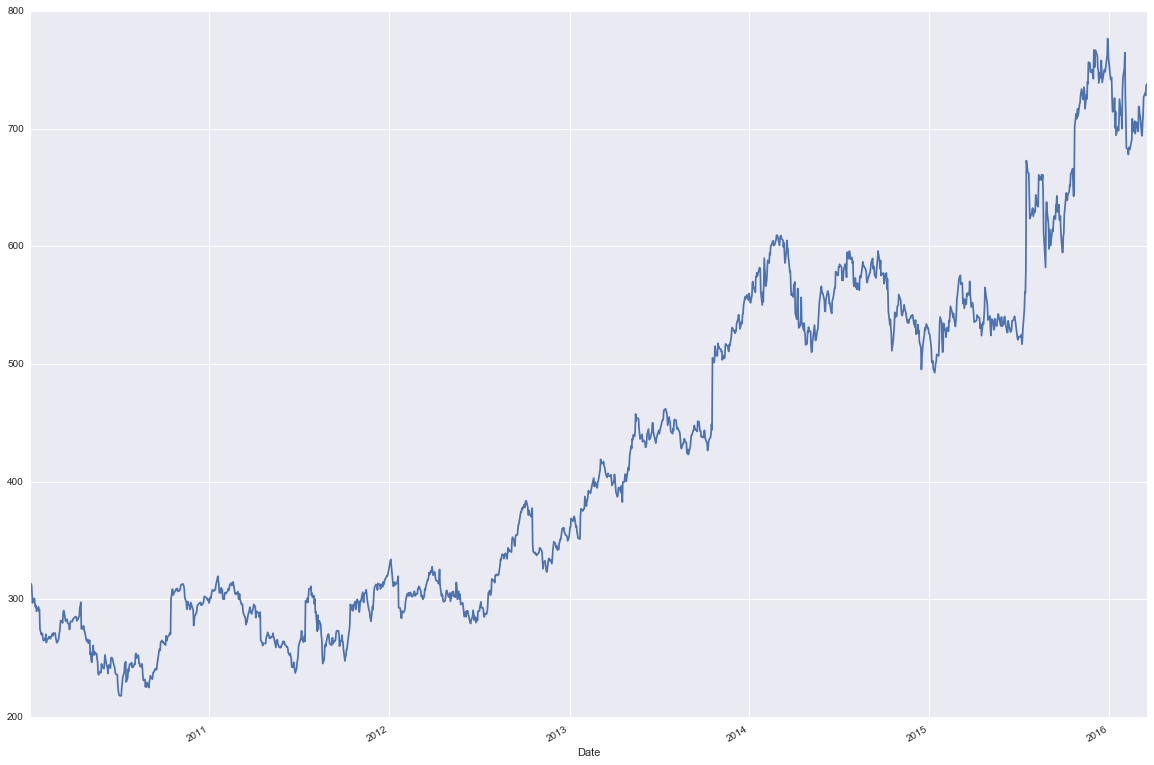

In [14]:
# Thanks, to Pandas integrations with NumPy and Matplotlib
# we can perform many operations very conveniently, e.g.
# let's plot the downloaded stock data:

google['Adj Close'].plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000226E55BEAC8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000226E4E11518>], dtype=object)

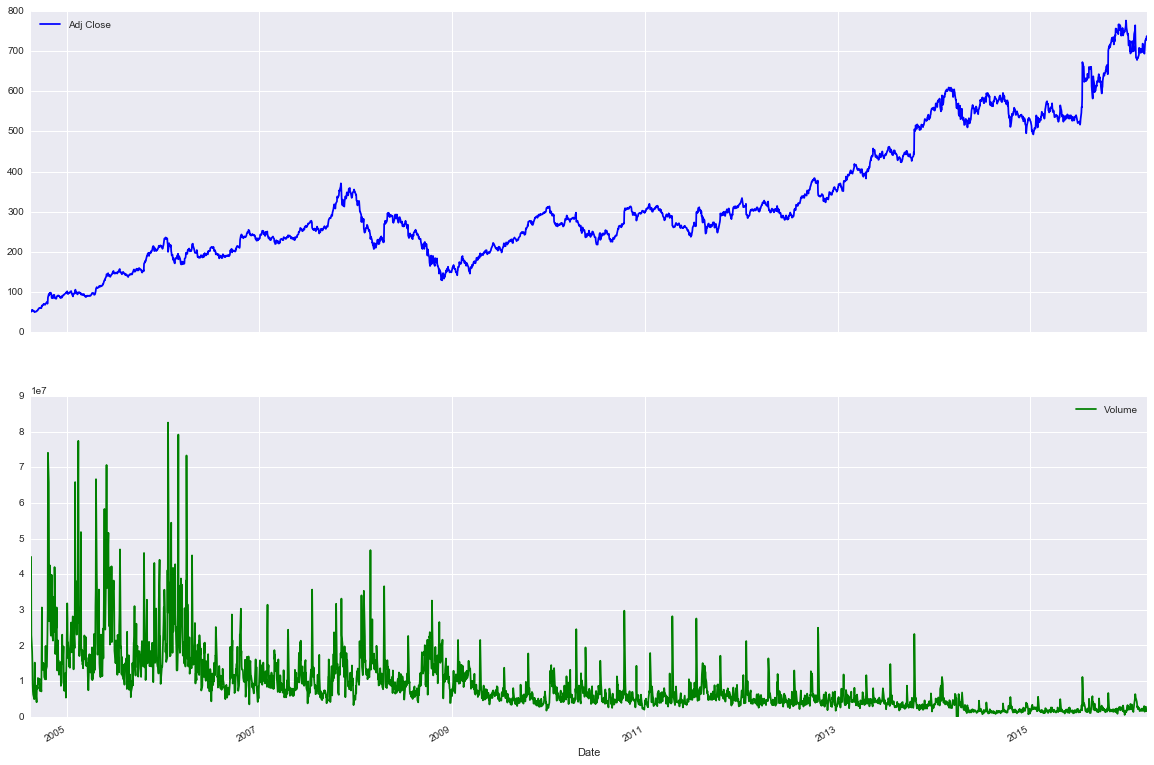

In [15]:
# To download stock between specific dates, we can use start and end parameters of DataReader

google = data.DataReader('GOOG', 'yahoo', start=dt.datetime(2004, 8, 19), end=dt.datetime.now())
google[['Adj Close', 'Volume']].plot(subplots=True)

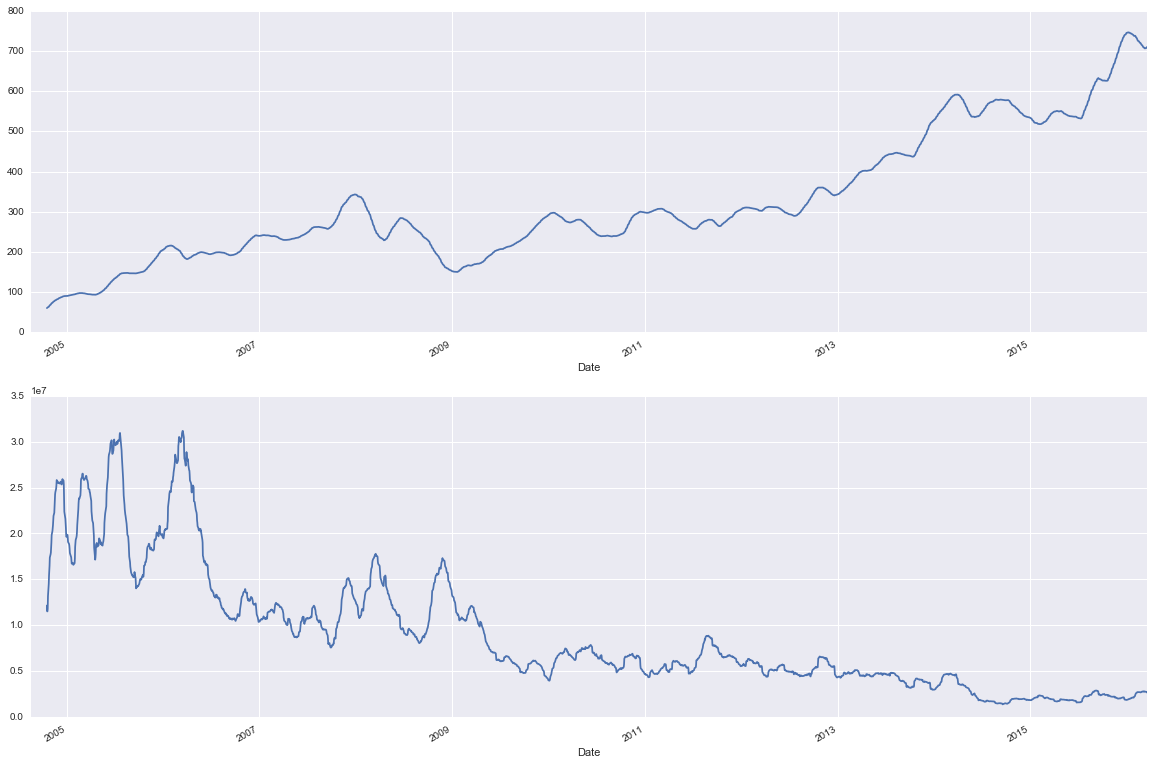

In [16]:
# We can combine Matplotlib commands with that of Pandas thanks
# to the fact that Pandaas uses Matplotlib internally.
#
# Furthermore, Pandas comes with multitude of useful functions such as
# rolling_mean: http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html

plt.subplot(2, 1, 1)
pd.rolling_mean(google['Adj Close'], window=42).plot()
plt.subplot(2, 1, 2)
pd.rolling_mean(google['Volume'], window=42).plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000226E5D5EFD0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000226E5E7B208>], dtype=object)

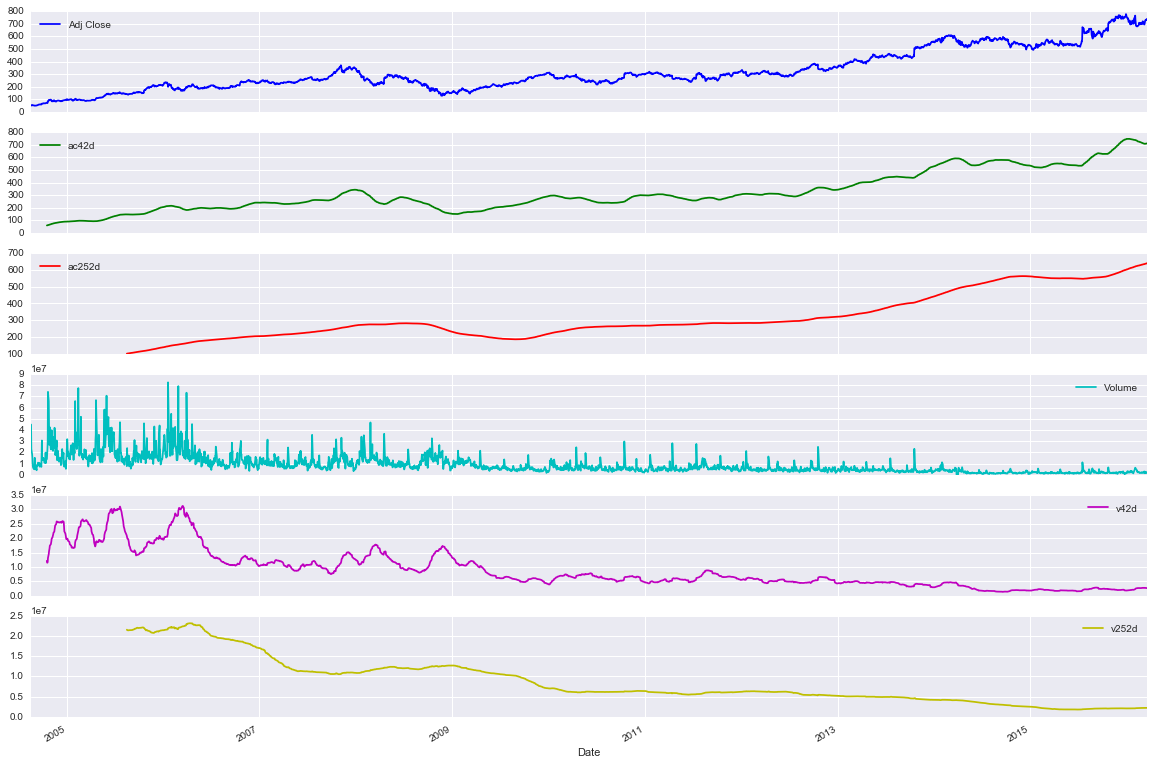

In [17]:
# But, it may be even a better idea to store
# the computed rolling_mean in our DataFrame:

google['ac42d'] = pd.rolling_mean(google['Adj Close'], window=42)
google['ac252d'] = pd.rolling_mean(google['Adj Close'], window=252)
google['v42d'] = pd.rolling_mean(google['Volume'], window=42)
google['v252d'] = pd.rolling_mean(google['Volume'], window=252)

# which then can be plotted even more conveniently
# by combining the Pandas ability to select data:

google[['Adj Close', 'ac42d', 'ac252d', 'Volume', 'v42d', 'v252d']].plot(subplots=True) 

# Subplots parameter will plot all selected columns in one figure.

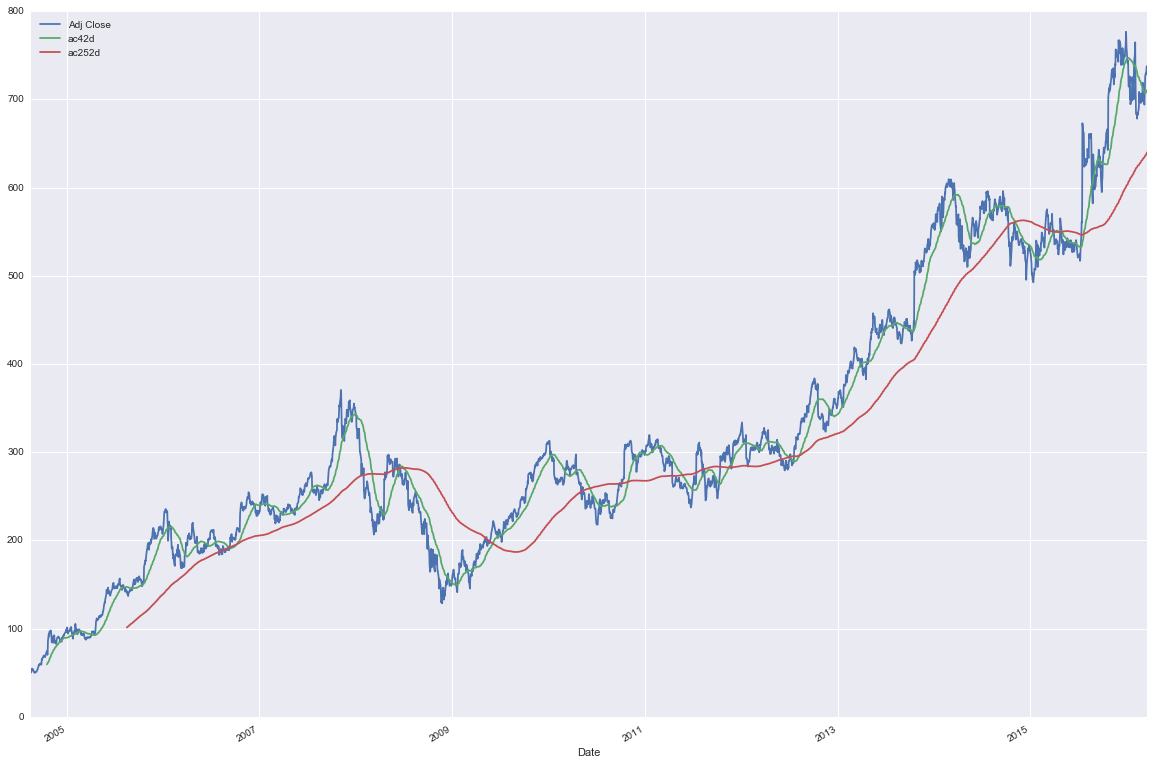

In [18]:
# To combine closing prices and volumes into plot
# it is enough that we ignore subplots parameter which by default is False.

google[['Adj Close', 'ac42d', 'ac252d']].plot() 

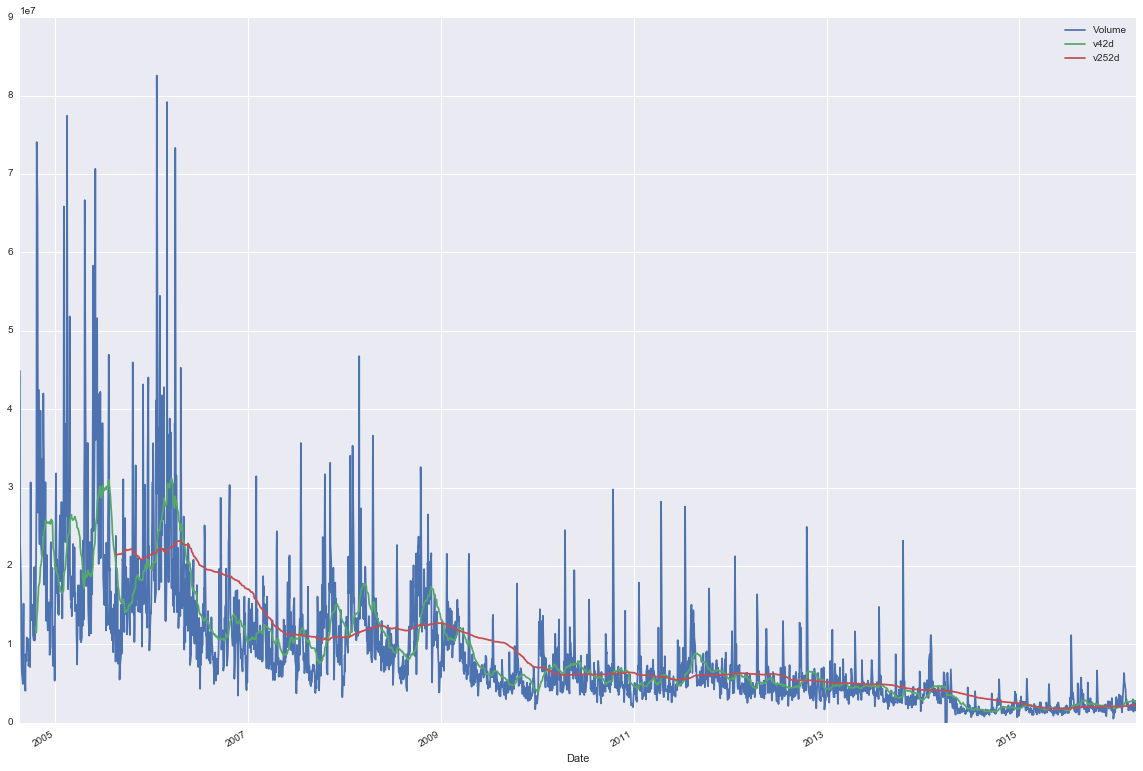

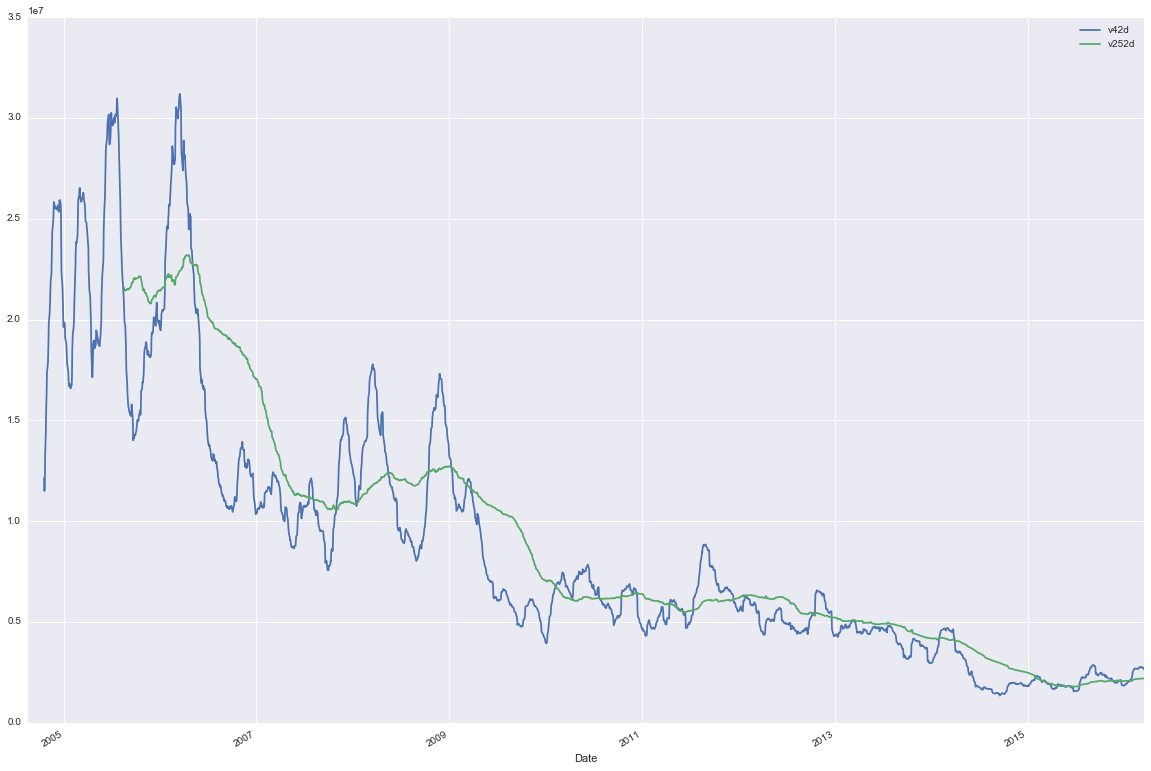

In [19]:
display(google[['Volume', 'v42d', 'v252d']].plot())
display(google[['v42d', 'v252d']].plot()) # as Volume is too dynamic

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000226E5EF2748>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000226E8A35160>], dtype=object)

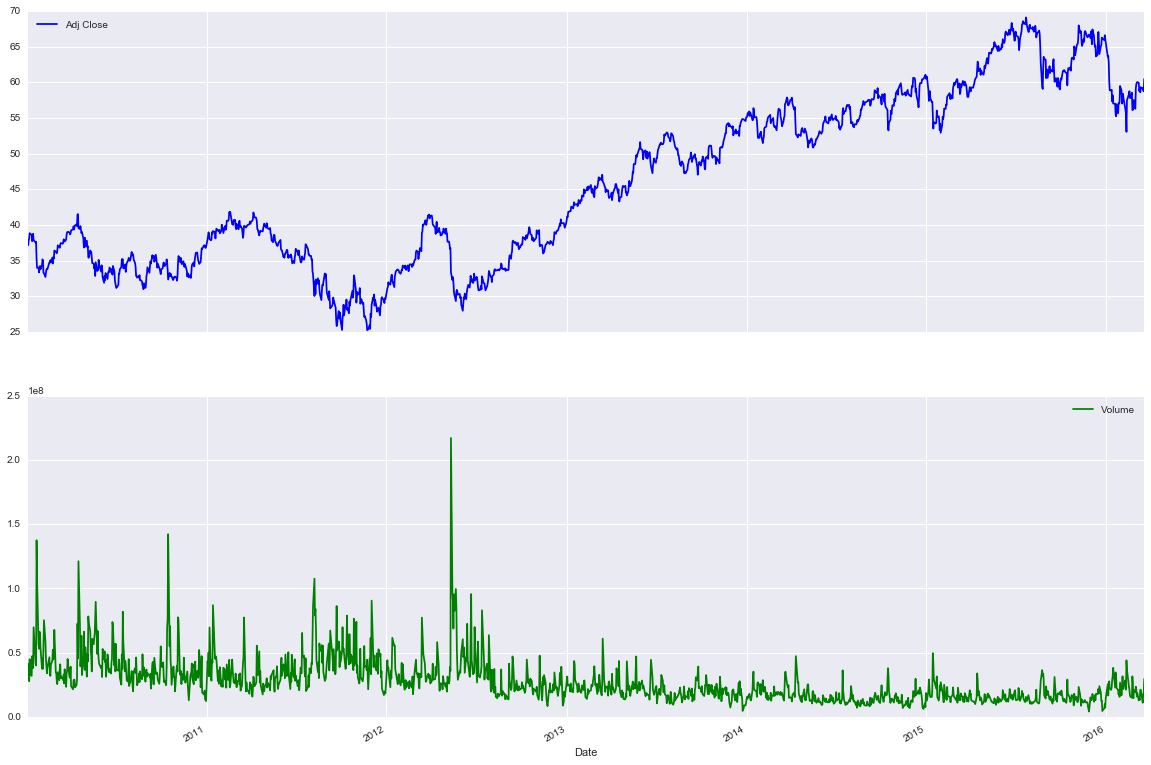

In [20]:
jpm = data.DataReader('JPM', 'yahoo')
jpm[['Adj Close', 'Volume']].plot(subplots=True)

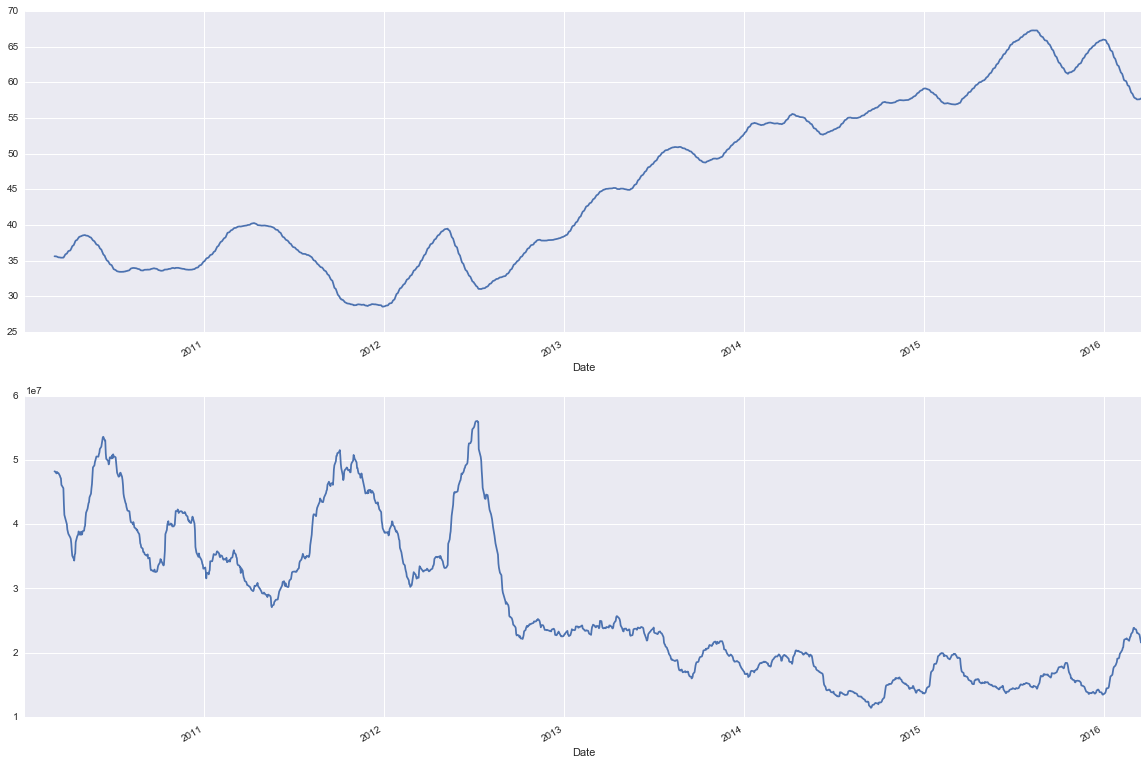

In [21]:
plt.subplot(2, 1, 1)
pd.rolling_mean(jpm['Adj Close'], window=42).plot()

plt.subplot(2, 1, 2)
pd.rolling_mean(jpm['Volume'], window=42).plot()

In [22]:
jpm['ac42d'] = pd.rolling_mean(jpm['Adj Close'], window=42)
jpm['ac252d'] = pd.rolling_mean(jpm['Adj Close'], window=252)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000226E72BF278>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000226E5DC2F28>], dtype=object)

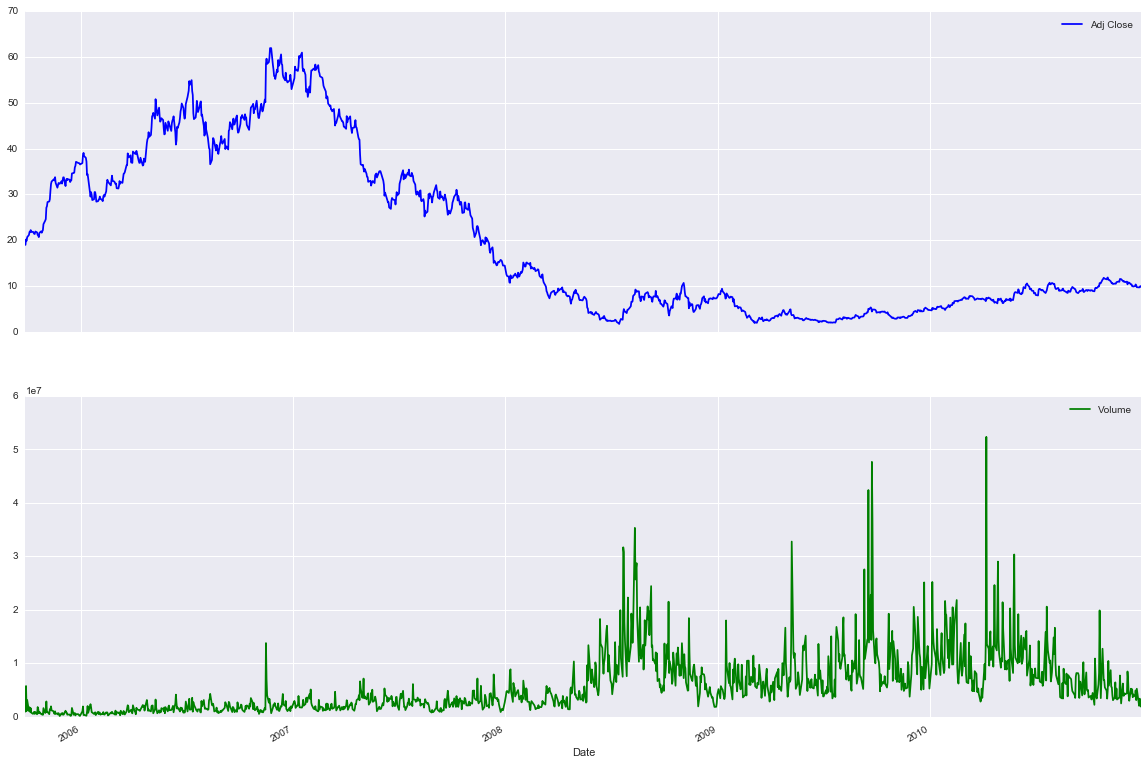

In [23]:
aal = data.DataReader('AAL', 'yahoo', start=dt.datetime(2004, 1, 1), end=dt.datetime(2011, 1, 1))
aal[['Adj Close', 'Volume']].plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000226E708A160>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000226E717C278>], dtype=object)

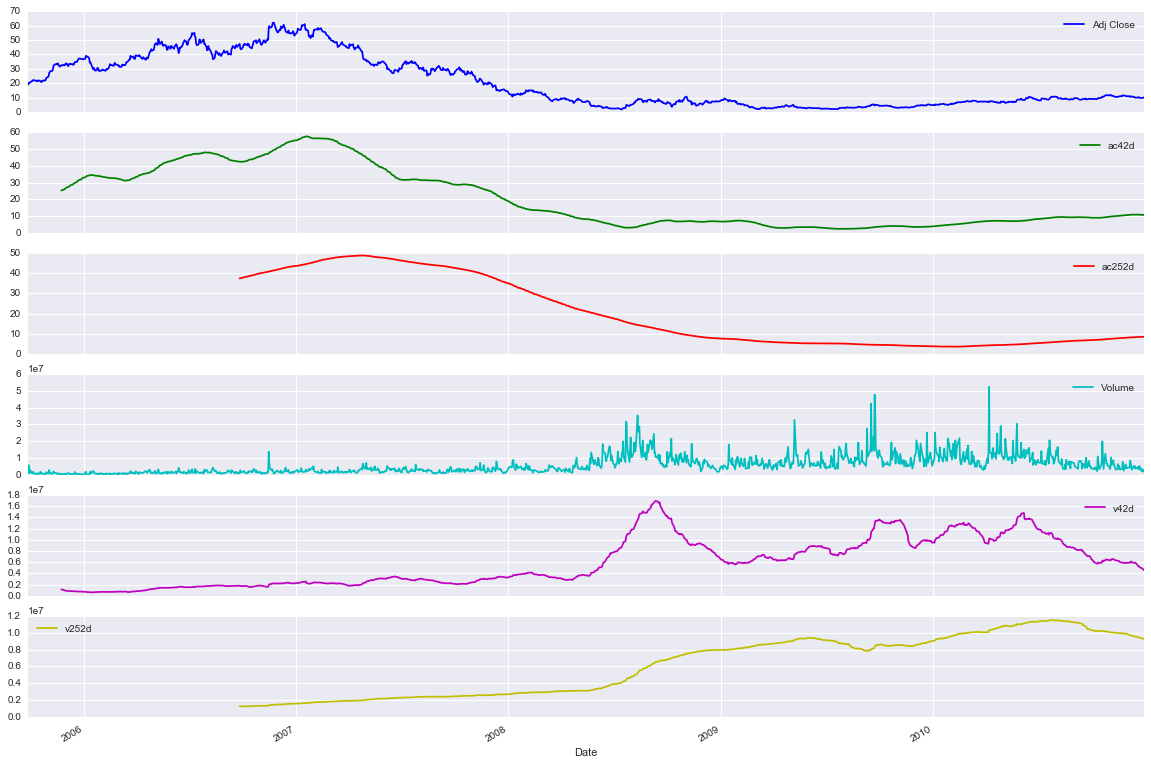

In [24]:
aal['ac42d'] = pd.rolling_mean(aal['Adj Close'], window=42)
aal['v42d'] = pd.rolling_mean(aal['Volume'], window=42)
aal['ac252d'] = pd.rolling_mean(aal['Adj Close'], window=252)
aal['v252d'] = pd.rolling_mean(aal['Volume'], window=252)
aal[['Adj Close', 'ac42d', 'ac252d', 'Volume', 'v42d', 'v252d']].plot(subplots=True)

It may seem from this 3 stocks that violatility is low when the stock value is growing and high when it is failing let's investigate, first by definining additional measures and then by using larger data set and regression tests

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000226E94ABCC0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000226E84E2CF8>], dtype=object)

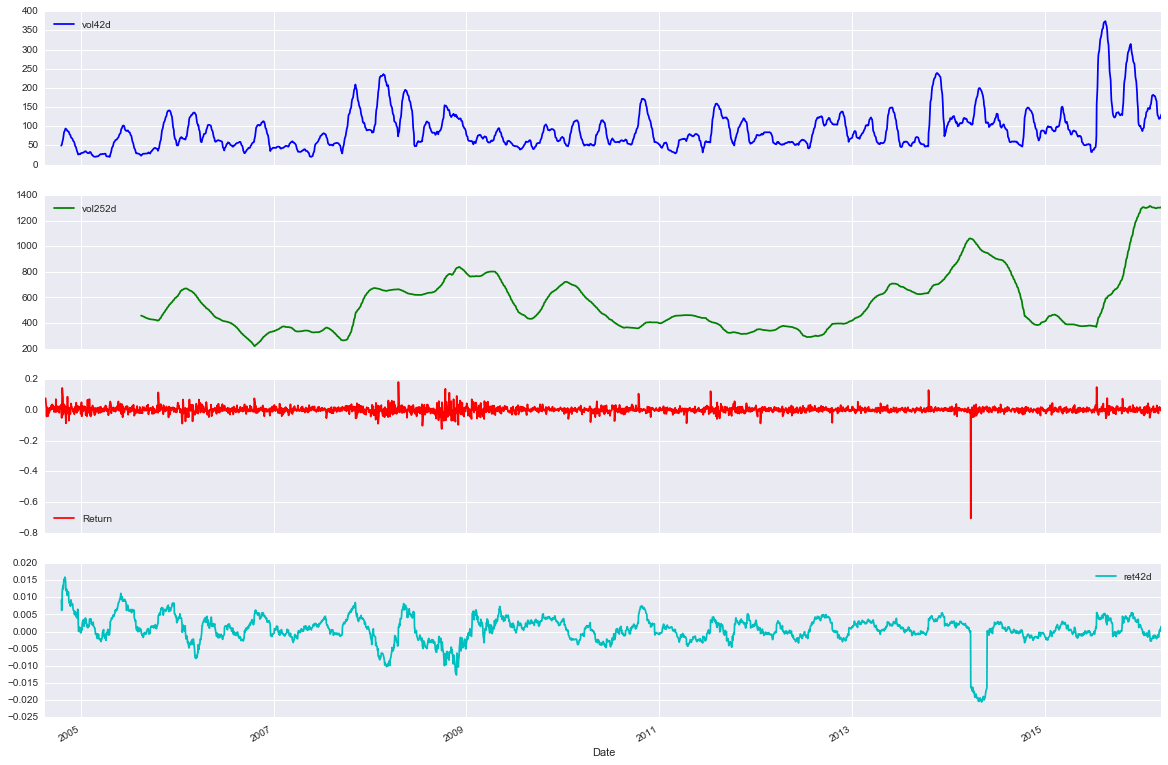

In [25]:
# there are other rolling functions, such as rolling_std
# you can read more about rolling window functions at
# http://pandas.pydata.org/pandas-docs/stable/computation.html#rolling-windows

# Now, we will use rolling_std to compute volatility for Google stock:

google['vol42d'] = pd.rolling_std(google['Adj Close'], window=42) * np.sqrt(42)
google['vol252d'] = pd.rolling_std(google['Adj Close'], window=252) * np.sqrt(252)

# and we will use Pandas shift operation for DataFrame 
# that basically adjust vector operations to work on shifted cells.
# We use this technique to compute the ratio of closing prices between
# 2 adjacent days.

google['Return'] = np.log(google['Close'] / google['Close'].shift(1))
google['ret42d'] = pd.rolling_mean(google['Return'], window=42)

# which all then we can conveniently plot :

google[['vol42d', 'vol252d', 'Return', 'ret42d']].plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000226E85E1860>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000226E98D3048>], dtype=object)

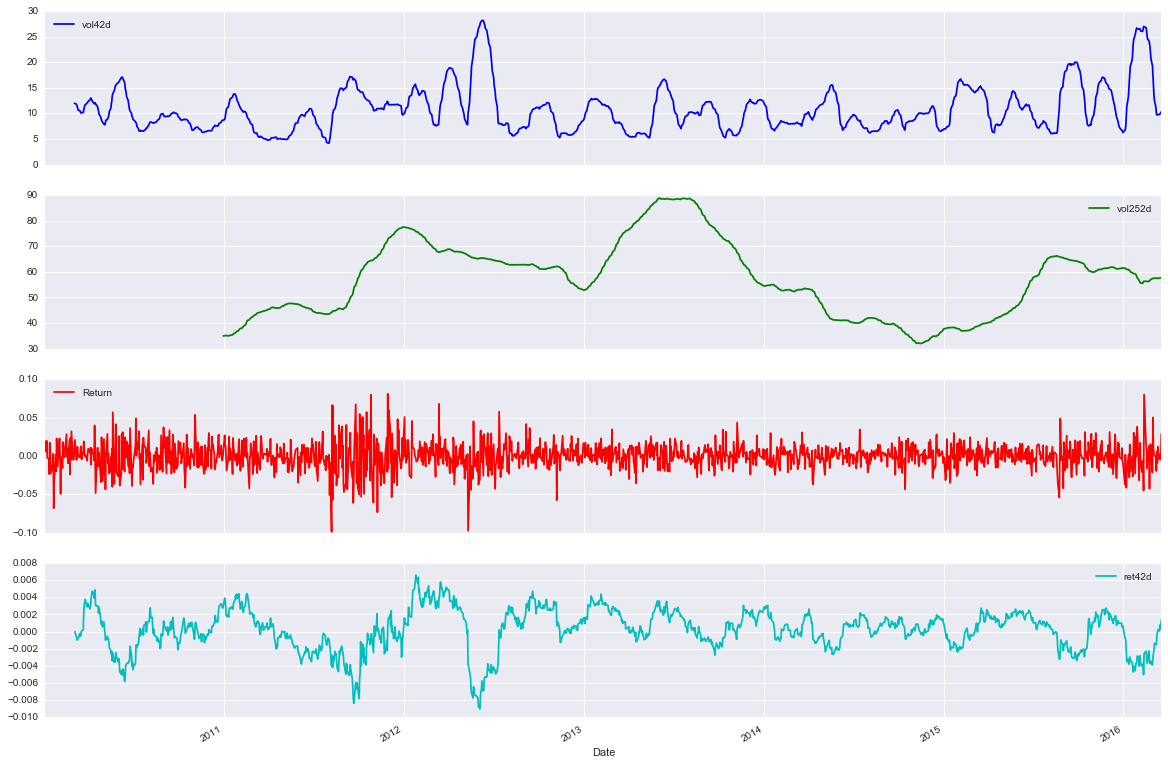

In [26]:
# Let's compute the same measures for our 2 other stocks: JPM and AAL

jpm['vol42d'] = pd.rolling_std(jpm['Adj Close'], window=42) * np.sqrt(42)
jpm['vol252d'] = pd.rolling_std(jpm['Adj Close'], window=252) * np.sqrt(252)

# and we will use Pandas shift operation for DataFrame 
# that basically adjust vector operations to work on shifted cells.
# We use this technique to compute the ratio of closing prices between
# 2 adjacent days.

jpm['Return'] = np.log(jpm['Close'] / jpm['Close'].shift(1))
jpm['ret42d'] = pd.rolling_mean(jpm['Return'], window=42)

# which all then we can conveniently plot :

jpm[['vol42d', 'vol252d', 'Return', 'ret42d']].plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000226E99ADE48>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000226E9DFE240>], dtype=object)

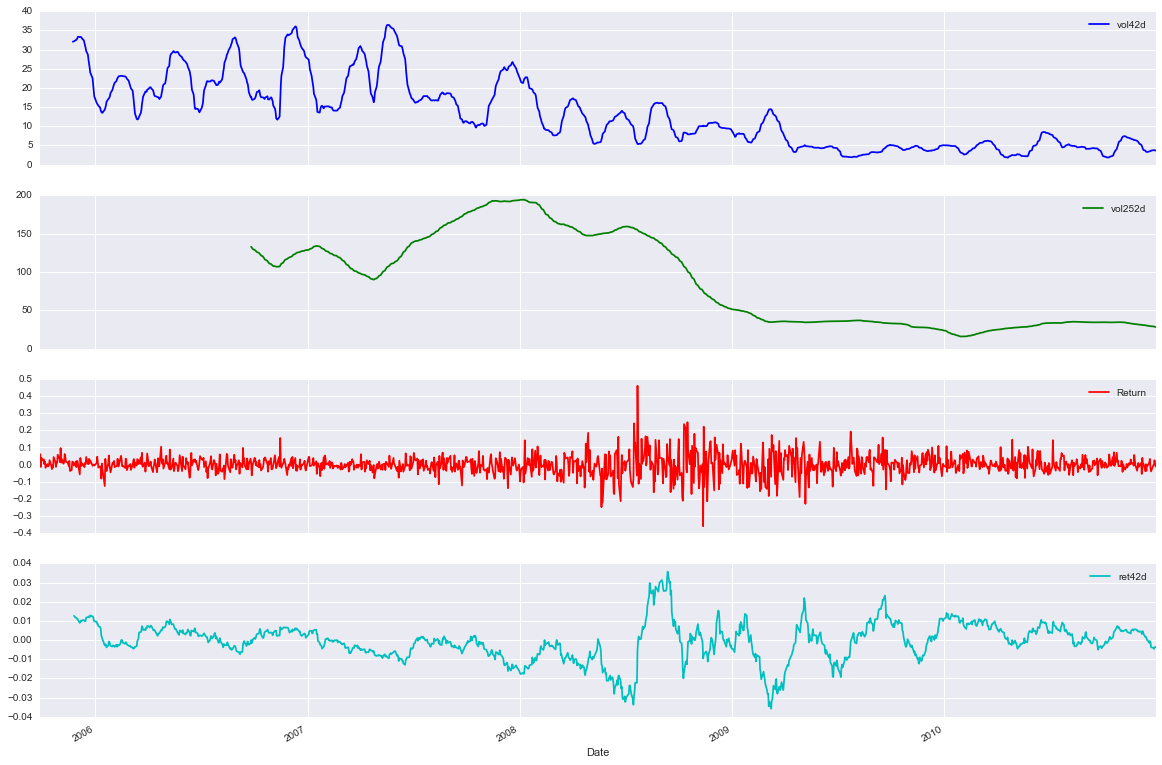

In [27]:
aal['vol42d'] = pd.rolling_std(aal['Adj Close'], window=42) * np.sqrt(42)
aal['vol252d'] = pd.rolling_std(aal['Adj Close'], window=252) * np.sqrt(252)

# and we will use Pandas shift operation for DataFrame 
# that basically adjust vector operations to work on shifted cells.
# We use this technique to compute the ratio of closing prices between
# 2 adjacent days.

aal['Return'] = np.log(aal['Close'] / aal['Close'].shift(1))
aal['ret42d'] = pd.rolling_mean(aal['Return'], window=42)

# which all then we can conveniently plot :

aal[['vol42d', 'vol252d', 'Return', 'ret42d']].plot(subplots=True)

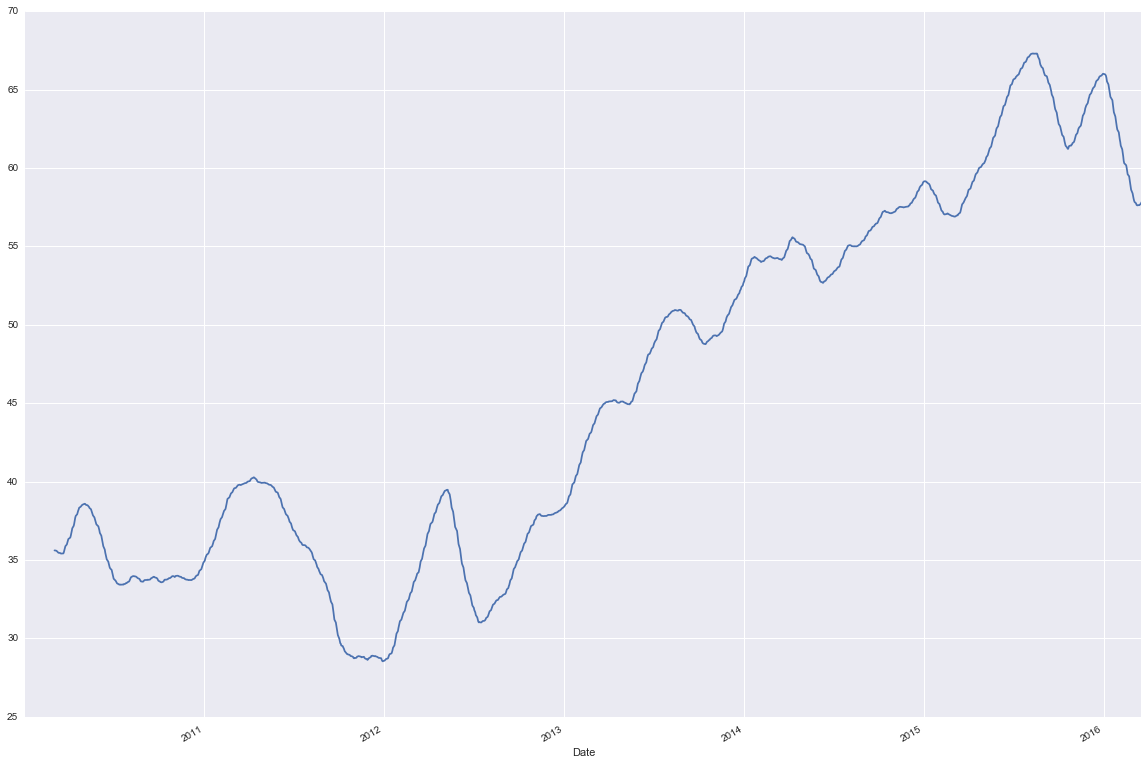

In [28]:
# BTW, notice how some events are visible in the stock price,
# e.g. http://www.bloomberg.com/news/articles/2012-09-13/jpmorgan-erases-stock-drop-fueled-by-london-trading-loss
jpm['ac42d'].plot()

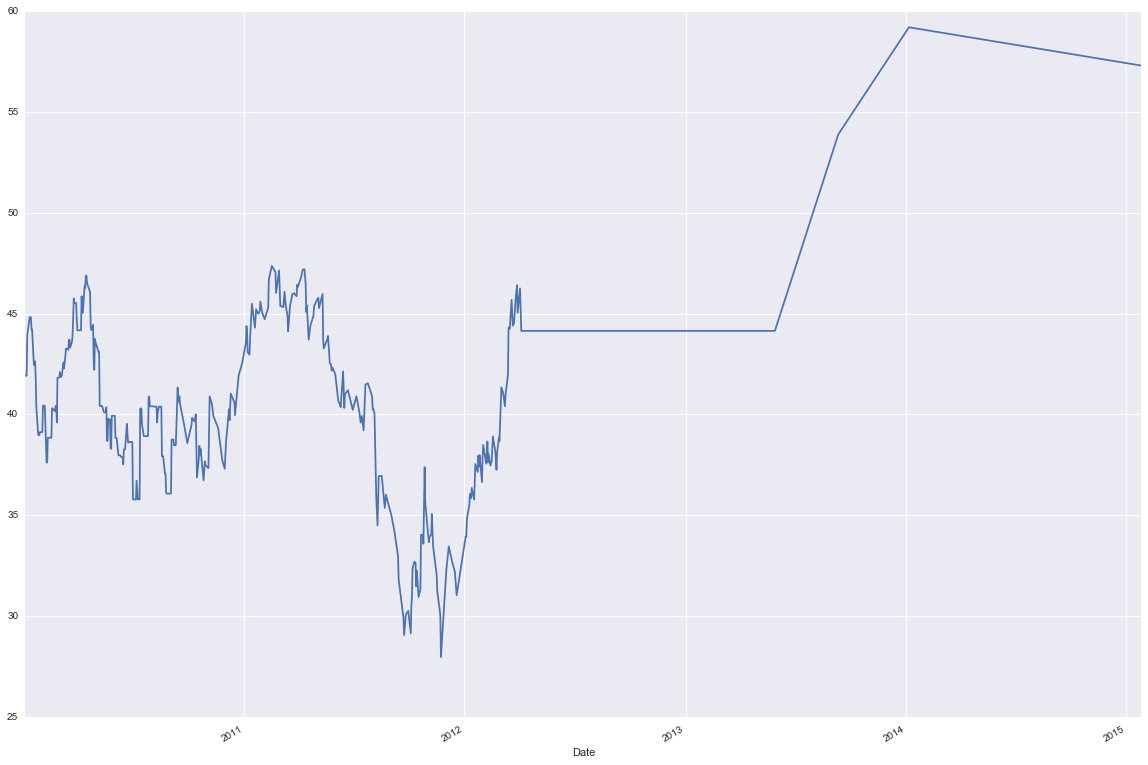

In [29]:
# BTW, be careful with the data you use. Sometimes you may be
# really surprised by its incompleteness. Take for example,
# JPM stock from Google, what's with that tail?

jpmgg = data.DataReader('JPM', 'google')
jpmgg['Close'].plot()

In [30]:
jpmgg.tail()

Open  High   Low  Close  Volume
Date                                        
2013-03-18    NaN   NaN   NaN  44.14       0
2013-05-29    NaN   NaN   NaN  44.14       0
2013-09-11  53.89   NaN   NaN  53.89       0
2014-01-06  59.20   NaN   NaN  59.20       0
2015-01-26  57.30  57.3  57.3  57.30       0

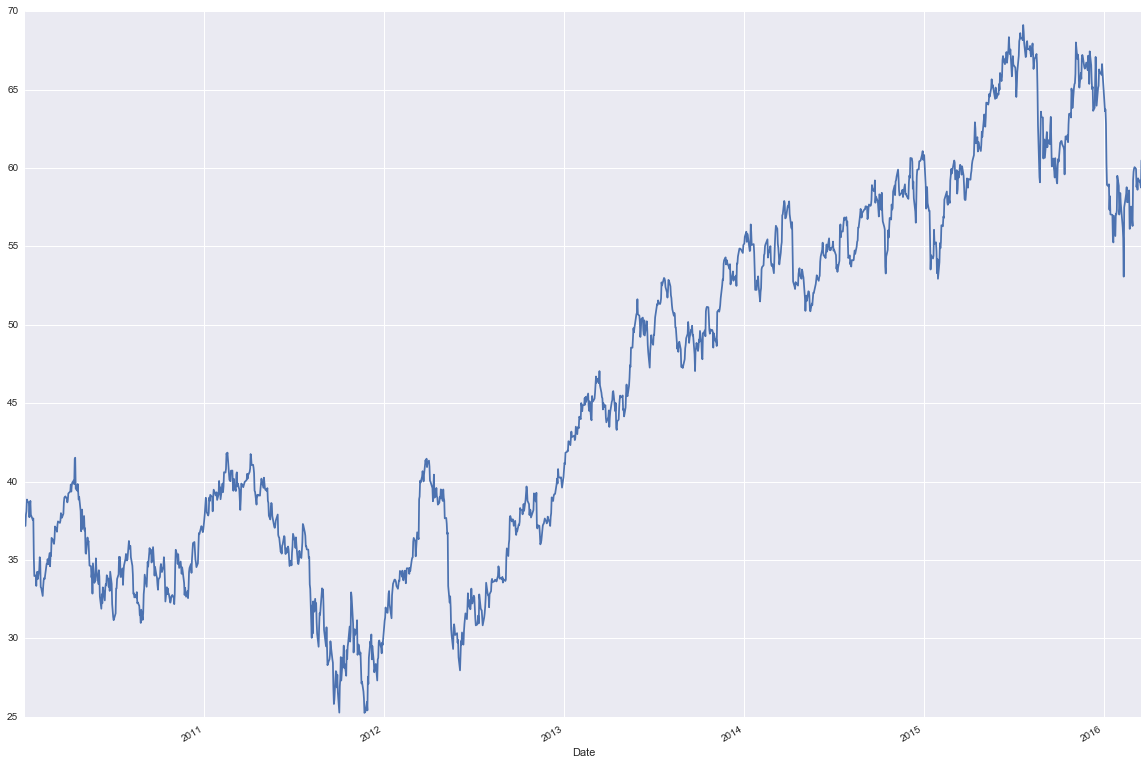

In [31]:
# and compare it to data from Y! Finance
jpm['Adj Close'].plot()

In [32]:
# Generally, for our purposes Y! Financ is more reliable.

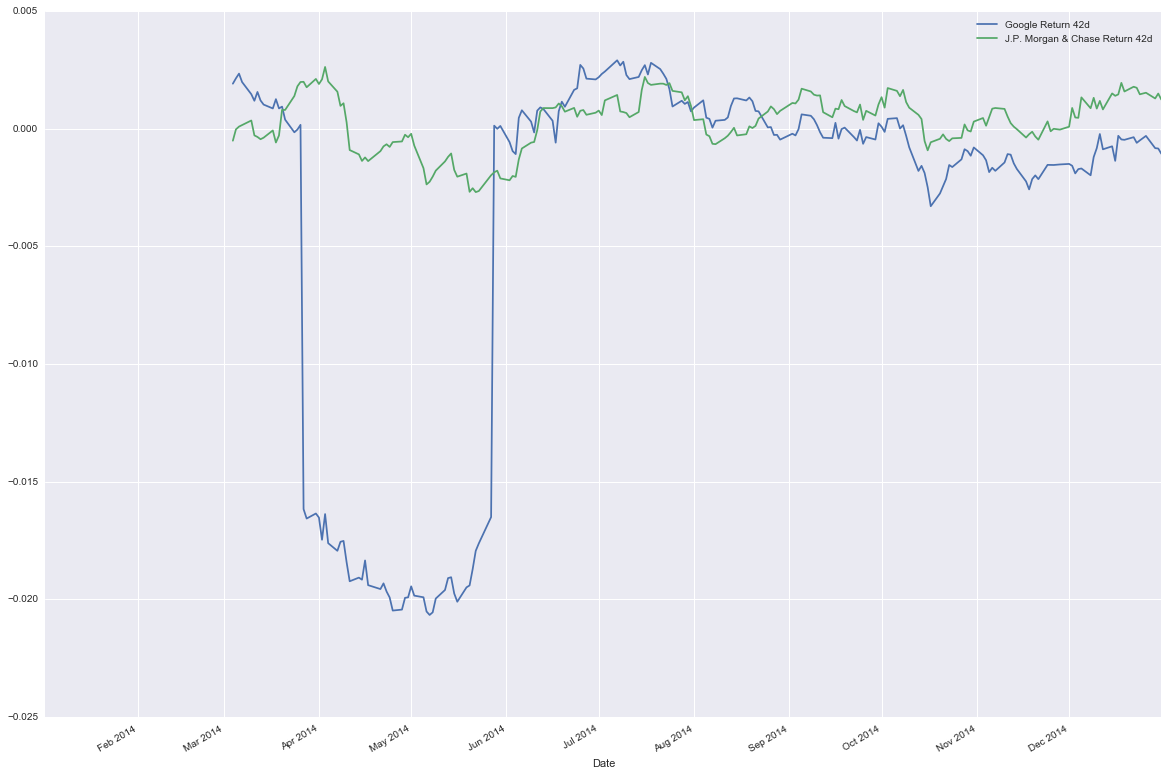

In [33]:
# Let's compare return on investment in GOOG and JPM between 2014-01-01 and 2015-01-01.

start = dt.datetime(2014, 1, 1)
end = dt.datetime(2015, 1, 1)

pd.rolling_mean(google['Return'][start:end], window=42).plot()
pd.rolling_mean(jpm['Return'][start:end], window=42).plot()
plt.legend(['Google Return 42d', 'J.P. Morgan & Chase Return 42d'])

# It seems that JPM would be a better long-time investement.

Now, let's do the same, but for a whole exchange. For that we will need symbols that we obtained in the first part of the notebook, stored in nyse_cl, nasdaq_cl, amex_cl, and all_cl.

Making download directly from the notebook would take considerable time, hence we provide both Python script and a cell code that we used for prototyping download algorithm.

Download from Python console is faster and we can use multiprocessing library from it. Note, that multiproessing cannot be used if '__main__' is not in the context, hence it cannot be used from Jupyter Notebooks.

In the script, we use 2 * cores available as the process is network bound.

** Warning: the script downloads over 4.9GB of data (this is a whole DVD) and each saved file (here 3) will have size of about 700MB (a whole CD). The saved file have less data than download as we don't need to store everything. The average running time on my laptop with 8 CPU cores, 16GB RAM, and hybrid disk is 20 minutes.**

In [ ]:
# %load 'download_script.py'
# Completed in about 2 mins.
import os
import sys

import datetime as dt
import multiprocessing as mp
import pandas as pd

from pandas_datareader import data, wb

# This program is network bound, so it make sense to use more tasks
# than there are cores available as they will be stuck waiting for
# response from Y! Finane server anyway
TASKS = mp.cpu_count() * 2

def clear_screen():
	os.system('cls' if os.name == 'nt' else 'clear')

def get_stock(ticker, start=dt.datetime(1970, 1, 1), end=dt.datetime(2016, 3, 1)):
    try:
        return True, ticker, data.DataReader(ticker, 'yahoo', start=start, end=end)
    except IOError as e:
        return False, ticker, None

def download_and_save():
	pool = mp.Pool(TASKS)

	symbols = pd.read_csv('output/all_info.csv', index_col=0, usecols=['Symbol']).index

	adj_closes, closes, volumes = [[], [], []]

	name_to_store = {
	    'Adj Close': adj_closes,
	    'Close': closes,
	    'Volume': volumes
	}

	downloaded = 0
	total = symbols.size
	failed_downloads = []
	
	downloads = pool.imap(get_stock, symbols)

	for success, symbol, data in downloads:

		if success:

			for col, store in name_to_store.items():
				series = pd.DataFrame(data[col])
				series.columns = [symbol]
				store.append(series)
        
			downloaded += 1

		else:

			failed_downloads.append(symbol)

		clear_screen()
		print('Downloaded {:.2%}'.format(downloaded/total))
		print('Failed downloads: {}'.format(failed_downloads), file=sys.stderr)
	
	
	clear_screen()
	total_failed = len(failed_downloads)

	print('Finished downloads.\n')

	print('*'*35)

	print('Downloaded {} ({:.2%}) stocks.\nFailed to download {} ({:.2%}):\n{}'.format(
		total-total_failed,
		(total-total_failed)/total,
		total_failed,
		total_failed/total,
		failed_downloads)
	)

	print('*'*35)

	print('\nGenerating tables...')
	for store in name_to_store.values():
		store = pd.concat(store, axis=1, join='outer')

	print('\nSorting tables by indicies...')
	for store in name_to_store.values():
		store.sort_index(axis=1, inplace=True)

	print('\nSaving tables to CSV files...')
	adj_closes.to_csv('output/AdjustedClosingPrices.csv')
	closes.to_csv('output/ClosingPrices.csv')
	volumes.to_csv('output/Volumes.csv')
	print('Saved {} to output/'.format(name_to_store.keys()))

	print('\nDone!')


if __name__ == '__main__':
	start = dt.datetime.now()	
	download_and_save()
	print()
	print('*'*35)
	print('*** Completed in {} ***'.format(dt.datetime.now() - start))
	print('*'*35)

In [34]:
def get_stock(ticker, start=dt.datetime(1970, 1, 1), end=dt.datetime(2016, 3, 1)):
    try:
        return True, ticker, data.DataReader(ticker, 'yahoo', start=start, end=end)
    except IOError as e:
        return False, ticker, None

In [38]:
%%time

# To measure whole block execution time we use %%time magic function
# source: http://jupyter.cs.brynmawr.edu/hub/dblank/public/Jupyter%20Magics.ipynb
#
# %%time measures whole cell execution, time, but if we would want
# to measure execution of single line we should use %time,
# and there is %timeit which runs the command multiple times
# to collect statstically significant running times.
#
# Now, let's download all stock information for companies that
# we have ticker symbols for in all_cl

start = dt.datetime(1970, 1, 1)
end = dt.datetime(2016, 3, 1)
symbols = all_cl.index

adj_closes, closes, volumes = [[]]*3
name_to_store = {
    'Adj Close': adj_closes,
    'Close': closes,
    'Volume': volumes
}

downloaded = 0
total = symbols.size
failed_downloads = []

stocks = map(get_stock, symbols)

for succ, ticker, stock in stocks:
    if succ:
        for col, store in name_to_store.items():
            d = pd.DataFrame(stock[col])
            d.columns = [ticker]
            store.append(d)
        
        downloaded += 1
    else:
        failed_downloads.append(ticker)
    
    print('Downloaded {:.2%}'.format(downloaded/total))
    print('Failed downloads: {}'.format(failed_downloads), file=sys.stderr)
    clear_output(wait=True) # wait with clear until new output is available
else:
    adj_closes = pd.concat(adj_closes, axis=1, join='outer')
    closes = pd.concat(closes, axis=1, join='outer')
    volumes = pd.concat(volumes, axis=1, join='outer')
    
    total_failed = len(failed_downloads)
    print('Downloaded {} ({:.2%}) stocks.\nFailed to download {} {:.2%}:\n{}'.format(
        total-total_failed,
        (total-total_failed)/total,
        total_failed,
        total_failed/total,
        failed_downloads)
     )

Downloaded 2260 (99.82%) stocks.
Failed to download 4 0.18%:
['ANDAU', 'ELECU', 'WYIG', 'OSG']


In [ ]:
# Note, that if we want we can run scripts from the notebook as well.

!ipython download_script.py

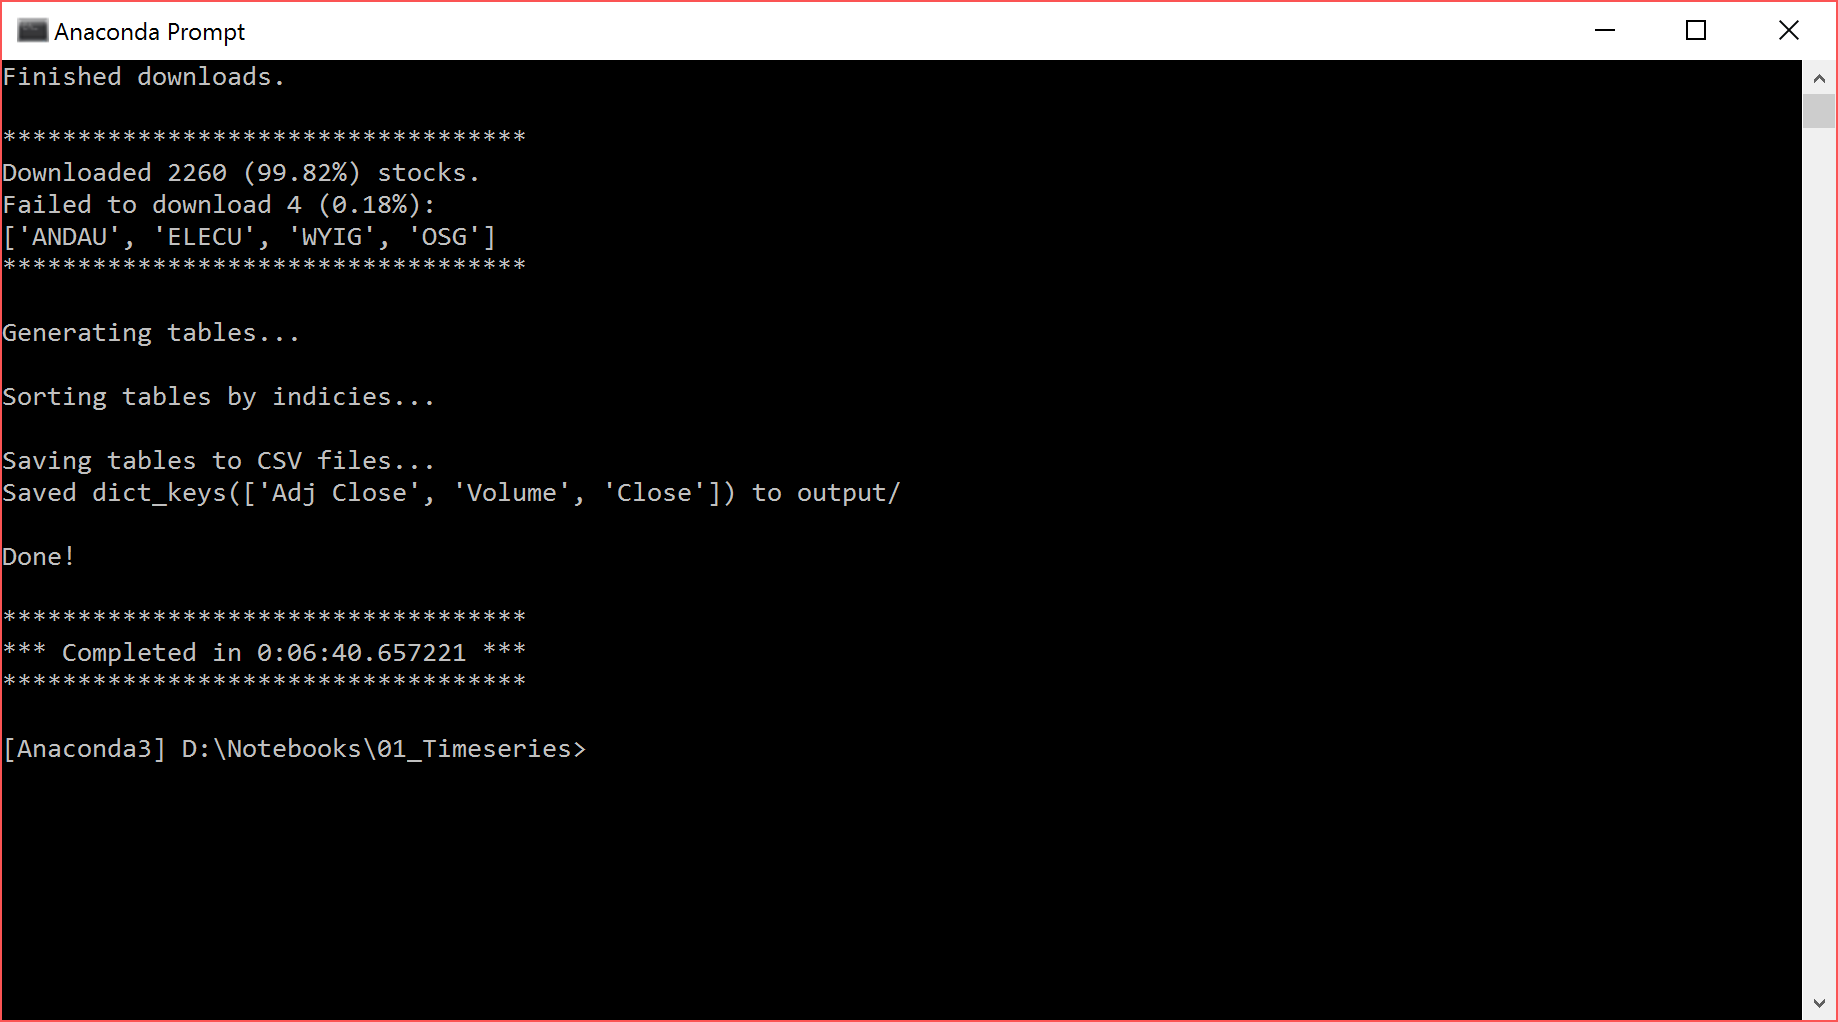

In [3]:
Image('screenshots/download_script.png')

In [2]:
# Let's check on our output files

!dir output

# note that the command depends on your shell,
# hence on Linux or Mac it's going to be:
# !ls output

 Volume in drive D is Files
 Volume Serial Number is 70B5-C924

 Directory of D:\Notebooks\01_Timeseries\output

21-Mar-16  21:31    <DIR>          .
21-Mar-16  21:31    <DIR>          ..
21-Mar-16  23:26       190,705,830 AdjustedClosingPrices.csv
21-Mar-16  22:47           196,338 all_info.csv
21-Mar-16  22:47             3,808 amex_info.csv
21-Mar-16  23:28       190,705,830 ClosingPrices.csv
21-Mar-16  22:47           112,733 nasdaq_info.csv
13-Mar-16  18:53       176,901,406 nyse.csv
13-Mar-16  17:32        26,590,225 nyse500.csv
13-Mar-16  18:53       176,901,406 nyse_closing_prices.csv
13-Mar-16  18:54       204,788,358 nyse_company_values.csv
21-Mar-16  22:47            79,891 nyse_info.csv
21-Mar-16  23:29       190,705,830 Volumes.csv
              11 File(s)  1,157,691,655 bytes
               2 Dir(s)  485,148,798,976 bytes free


In [89]:
# Loading downloaded data
# Warning: this cell will load 600MB of data into the memory
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

adjcloses = pd.read_csv('output/AdjustedClosingPrices.csv', index_col=0, parse_dates=True)
closes = pd.read_csv('output/ClosingPrices.csv', index_col=0, parse_dates=True)
volumes = pd.read_csv('output/Volumes.csv', index_col=0, parse_dates=True)

In [93]:
nyse_symbols = nyse_cl.index
nasdaq_symbols = nasdaq_cl.index.drop(['ANDAU', 'ELECU', 'WYIG'])
amex_symbols = amex_cl.index.drop(['OSG'])

nyse_adjcloses = adjcloses[nyse_symbols]
nasdaq_adjcloses = adjcloses[nasdaq_symbols]
amex_adjcloses = adjcloses[amex_symbols]

nyse_closes = closes[nyse_symbols]
nasdaq_closes = closes[nasdaq_symbols]
amex_closes = closes[amex_symbols]

nyse_volumes = volumes[nyse_symbols]
nasdaq_volumes = volumes[nasdaq_symbols]
amex_volumes = volumes[amex_symbols]

In [94]:
sample_dates = pd.date_range(start=dt.datetime(1970,1,1),end=dt.datetime(2016,3,1),freq='1M', normalize=True)

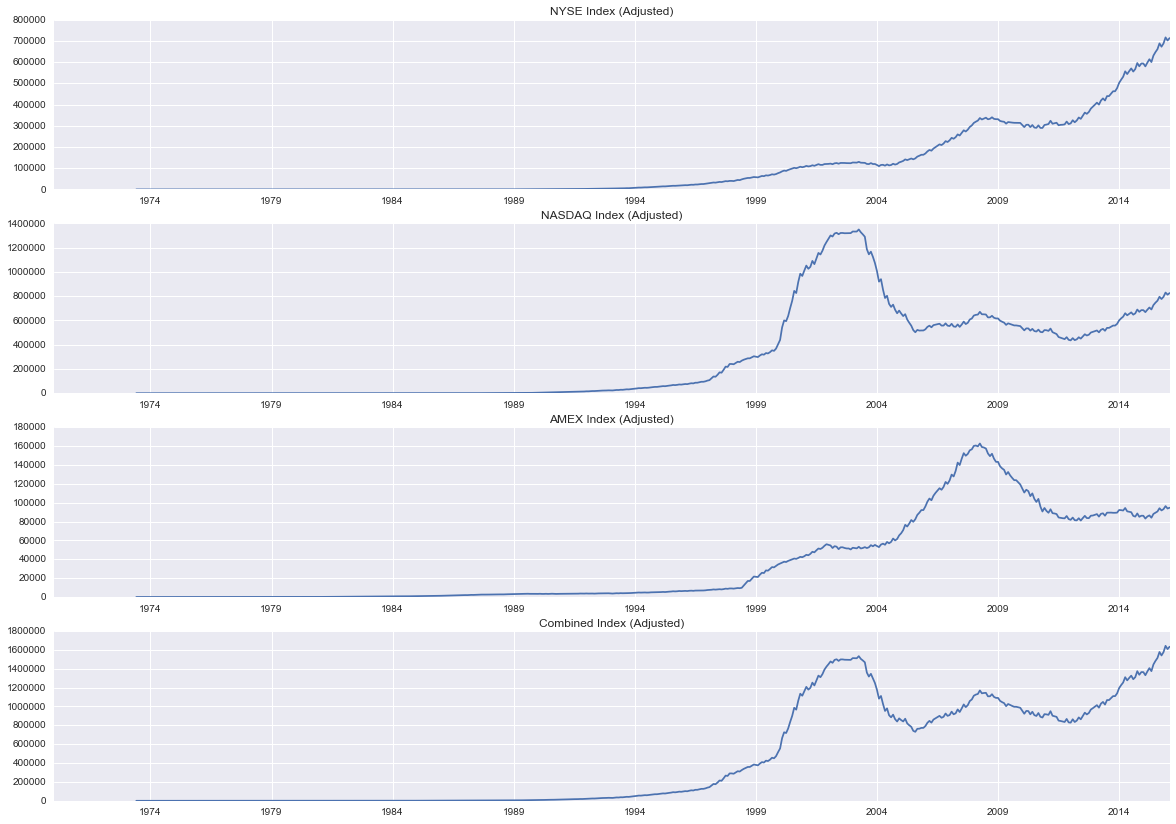

In [95]:
plt.subplot(4, 1, 1)
pd.rolling_sum(nyse_adjcloses.ix[sample_dates].sum(axis=1), window=42).plot()
plt.title('NYSE Index (Adjusted)')

plt.subplot(4, 1, 2)
pd.rolling_sum(nasdaq_adjcloses.ix[sample_dates].sum(axis=1), window=42).plot()
plt.title('NASDAQ Index (Adjusted)')

plt.subplot(4, 1, 3)
pd.rolling_sum(amex_adjcloses.ix[sample_dates].sum(axis=1), window=42).plot()
plt.title('AMEX Index (Adjusted)')

plt.subplot(4, 1, 4)
pd.rolling_sum(adjcloses.ix[sample_dates].sum(axis=1), window=42).plot()
plt.title('Combined Index (Adjusted)')

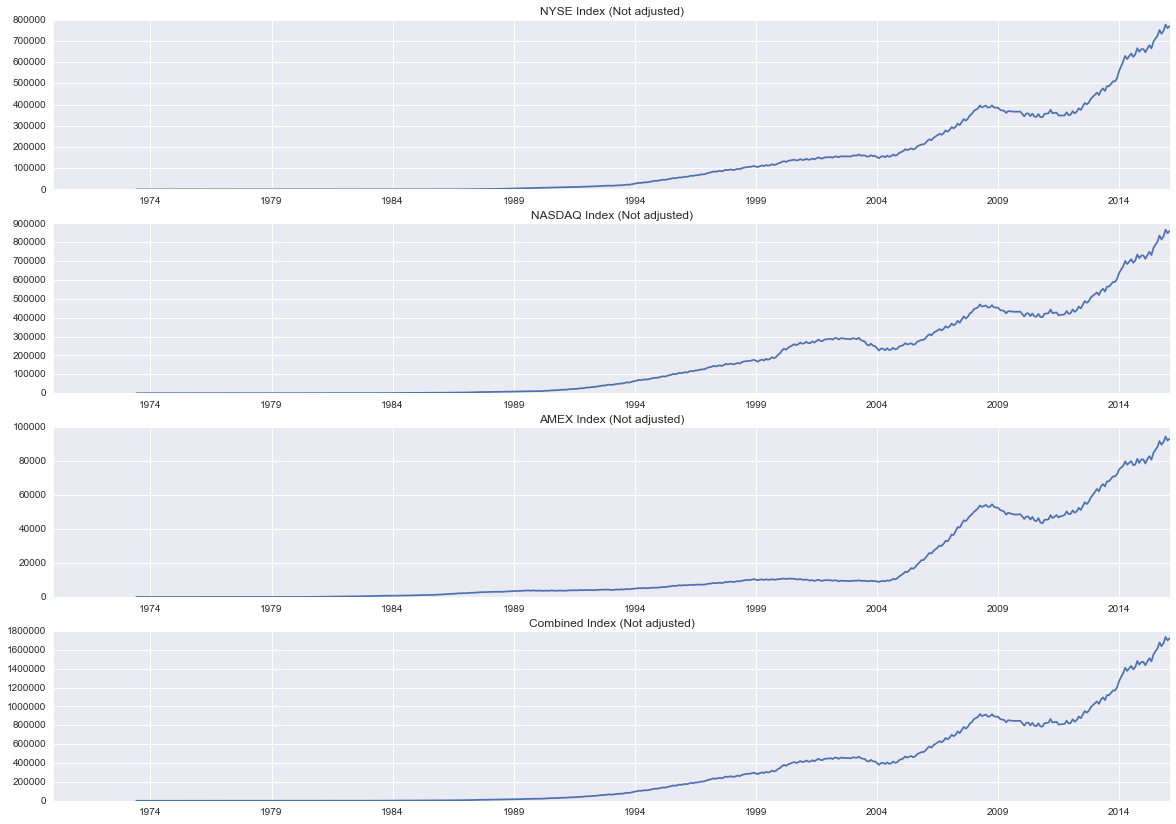

In [96]:
plt.subplot(4, 1, 1)
pd.rolling_sum(nyse_closes.ix[sample_dates].sum(axis=1), window=42).plot()
plt.title('NYSE Index (Not adjusted)')

plt.subplot(4, 1, 2)
pd.rolling_sum(nasdaq_closes.ix[sample_dates].sum(axis=1), window=42).plot()
plt.title('NASDAQ Index (Not adjusted)')

plt.subplot(4, 1, 3)
pd.rolling_sum(amex_closes.ix[sample_dates].sum(axis=1), window=42).plot()
plt.title('AMEX Index (Not adjusted)')

plt.subplot(4, 1, 4)
pd.rolling_sum(closes.ix[sample_dates].sum(axis=1), window=42).plot()
plt.title('Combined Index (Not adjusted)')

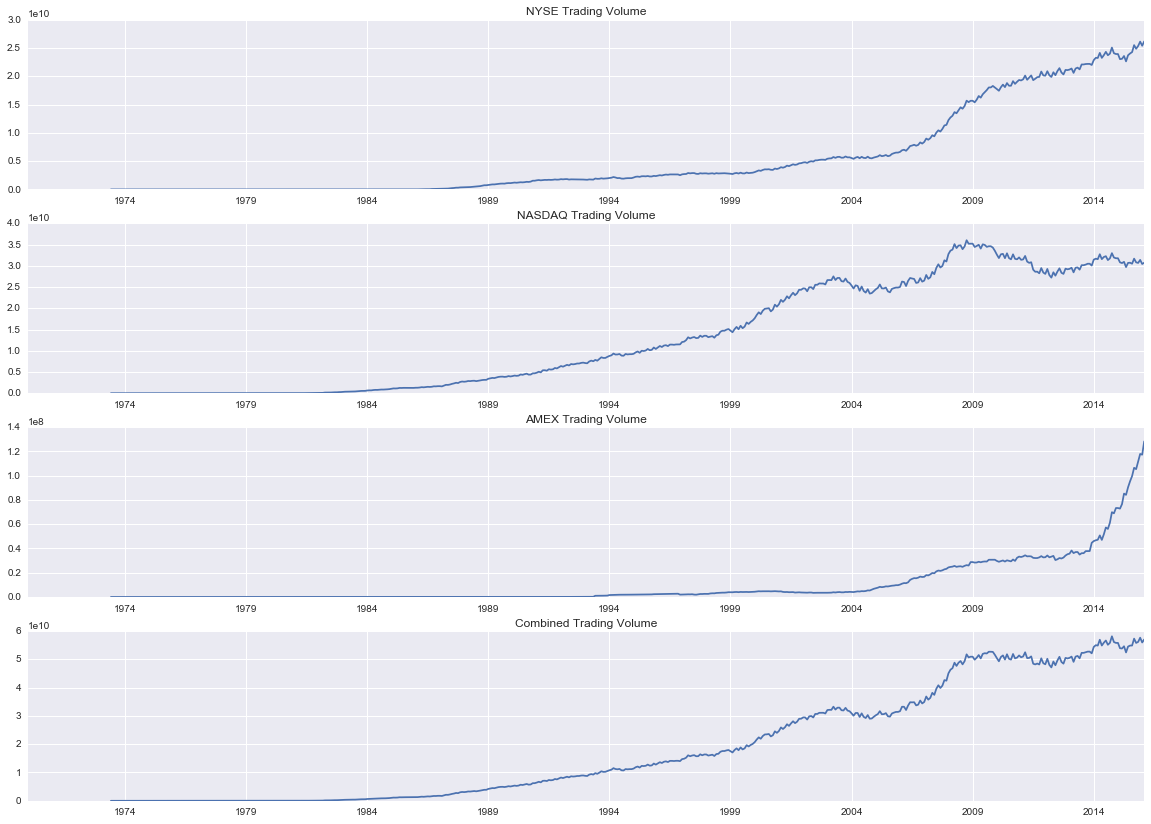

In [97]:
plt.subplot(4, 1, 1)
pd.rolling_sum(nyse_volumes.ix[sample_dates].sum(axis=1), window=42).plot()
plt.title('NYSE Trading Volume')

plt.subplot(4, 1, 2)
pd.rolling_sum(nasdaq_volumes.ix[sample_dates].sum(axis=1), window=42).plot()
plt.title('NASDAQ Trading Volume')

plt.subplot(4, 1, 3)
pd.rolling_sum(amex_volumes.ix[sample_dates].sum(axis=1), window=42).plot()
plt.title('AMEX Trading Volume')

plt.subplot(4, 1, 4)
pd.rolling_sum(volumes.ix[sample_dates].sum(axis=1), window=42).plot()
plt.title('Combined Trading Volume')

In [100]:
# We can use describe to get more info about our data such as
nyse_adjcloses.sum(axis=1).describe()

count     9088.000000
mean      5650.238770
std       7666.098159
min          0.000000
25%         40.878128
50%       2530.603050
75%       9380.340361
max      31288.481221
dtype: float64

In [111]:
nyse_adjcloses.transpose().describe()

Date   1980-03-17  1980-03-18  1980-03-19  1980-03-20  1980-03-21  1980-03-24  \
count           0           0           0           0           0           0   
mean          NaN         NaN         NaN         NaN         NaN         NaN   
std           NaN         NaN         NaN         NaN         NaN         NaN   
min           NaN         NaN         NaN         NaN         NaN         NaN   
25%           NaN         NaN         NaN         NaN         NaN         NaN   
50%           NaN         NaN         NaN         NaN         NaN         NaN   
75%           NaN         NaN         NaN         NaN         NaN         NaN   
max           NaN         NaN         NaN         NaN         NaN         NaN   

Date   1980-03-25  1980-03-26  1980-03-27  1980-03-28     ...      2016-02-17  \
count           0           0           0           0     ...      925.000000   
mean          NaN         NaN         NaN         NaN     ...       27.390942   
std           NaN         NaN         NaN         NaN     ...       46.192717   
min           NaN         NaN         NaN         NaN     ...        0.200000   
25%           NaN         NaN         NaN         NaN     ...        8.060000   
50%           NaN         NaN         NaN         NaN     ...       16.850000   
75%           NaN         NaN         NaN         NaN     ...       30.840000   
max           NaN         NaN         NaN         NaN     ...      844.000000   

Date   2016-02-18  2016-02-19  2016-02-22  2016-02-23  2016-02-24  2016-02-25  \
count  925.000000  925.000000  925.000000  925.000000  925.000000  925.000000   
mean    27.343261   27.415024   27.886102   27.560462   27.765556   28.094083   
std     46.222170   46.633922   47.143838   46.618154   46.860069   47.476544   
min      0.200000    0.200000    0.210000    0.200000    0.190000    0.200000   
25%      8.200000    8.220000    8.240000    7.963369    7.960000    7.990000   
50%     16.458751   16.440001   16.894410   16.696930   16.740000   17.080000   
75%     30.980000   30.660539   31.100000   30.959999   31.287164   31.639999   
max    848.000000  861.429993  867.750000  853.890015  866.630005  882.289978   

Date   2016-02-26  2016-02-29  2016-03-01  
count  925.000000  925.000000  925.000000  
mean    28.256039   28.209968   28.737931  
std     47.176746   46.870416   47.794702  
min      0.200000    0.210000    0.200000  
25%      8.310000    8.417240    8.650000  
50%     17.490000   17.250000   17.410000  
75%     32.490002   32.060001   32.730000  
max    866.760010  856.710022  878.460022  

[8 rows x 9088 columns]

In [179]:
# Let's compute volatility for our exchange data
nyse_adjcloses = nyse_adjcloses.fillna(0.0)
volatility = pd.rolling_std(nyse_adjcloses, window=42) * np.sqrt(42)
vol_sample = volatility.ix[volatility.index > dt.datetime(2013, 1, 1)].sample(4, axis=1)
ac_sample = pd.rolling_mean(nyse_adjcloses.ix[nyse_adjcloses.index > dt.datetime(2013, 1, 1)][vol_sample.columns], window=42)
returns_sample = np.log(ac_sample / ac_sample.shift(1))

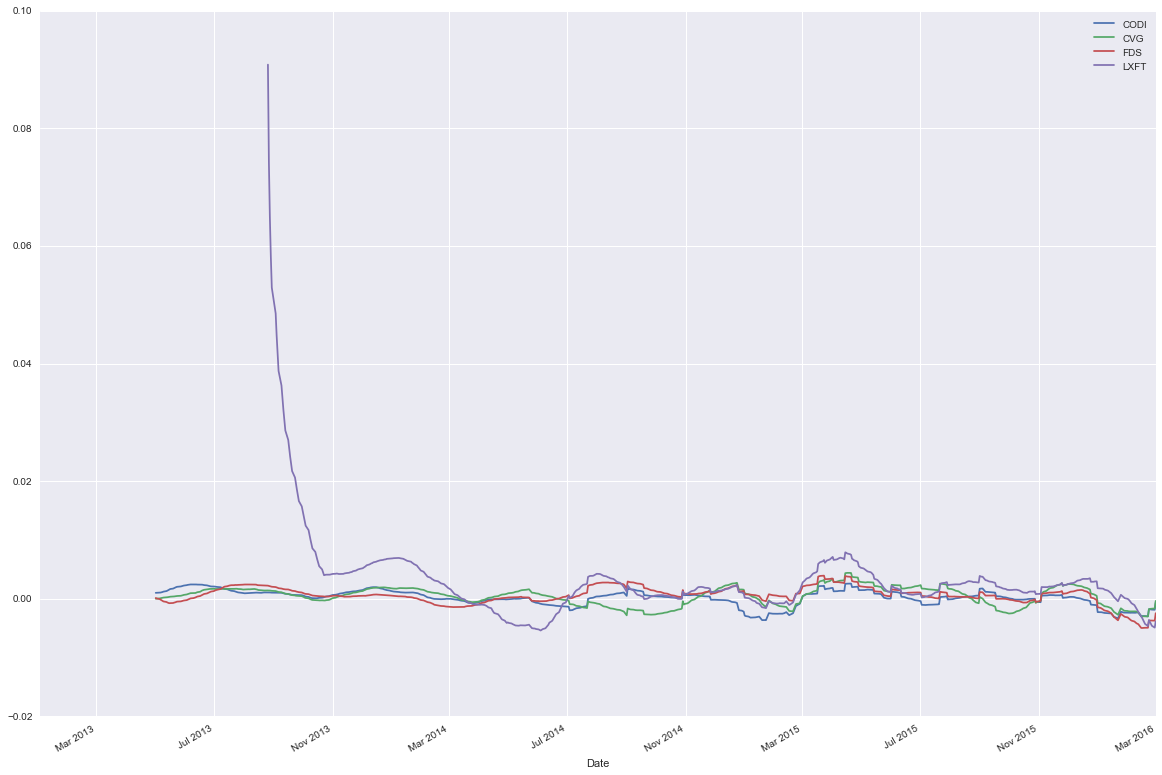

In [180]:
pd.rolling_mean(returns_sample, window=42).plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022121DA6D68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000022122202C18>]], dtype=object)

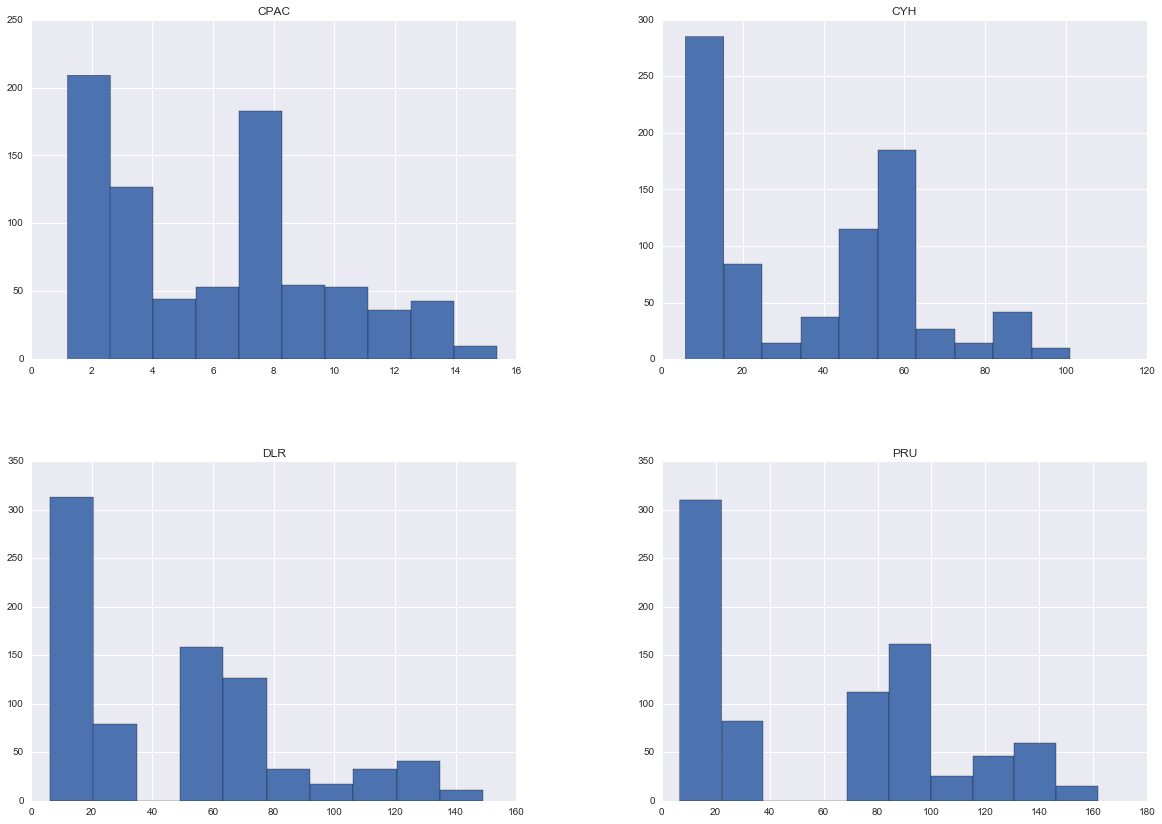

In [162]:
vol_sample.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002212356E588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002212473F828>]], dtype=object)

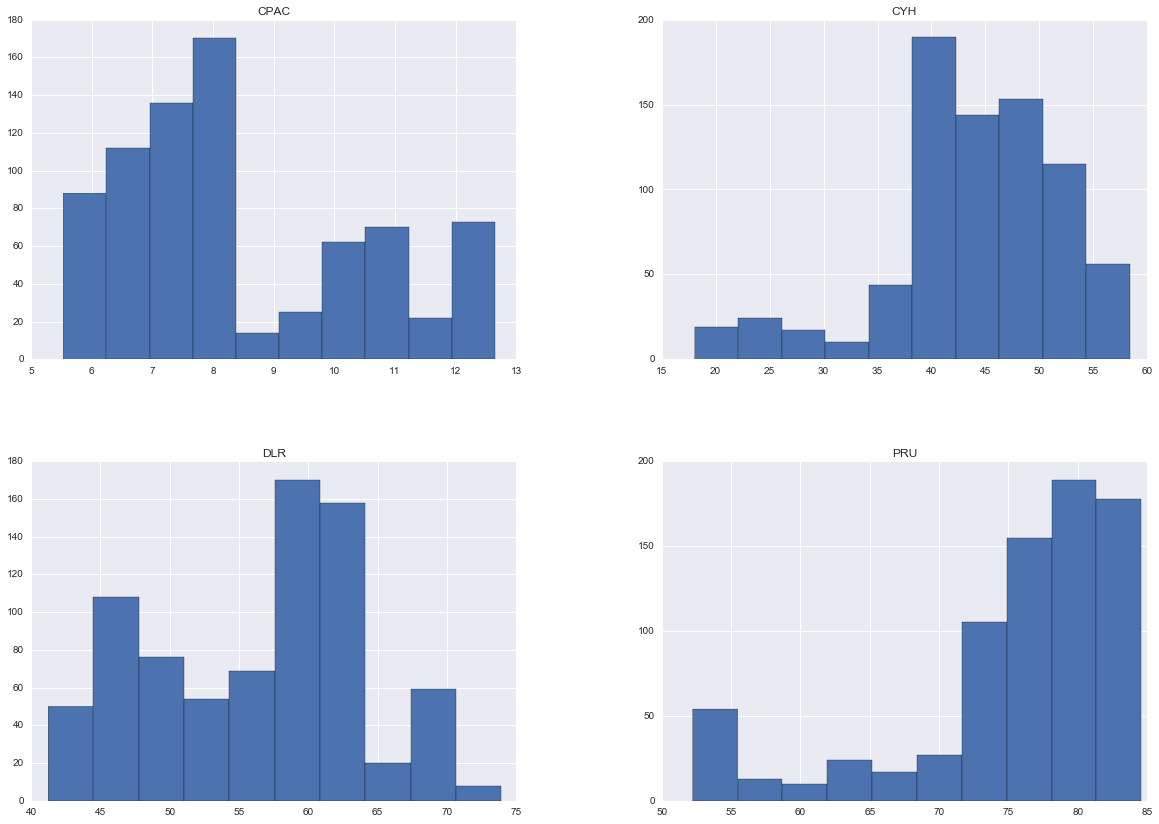

In [163]:
ac_sample.hist()

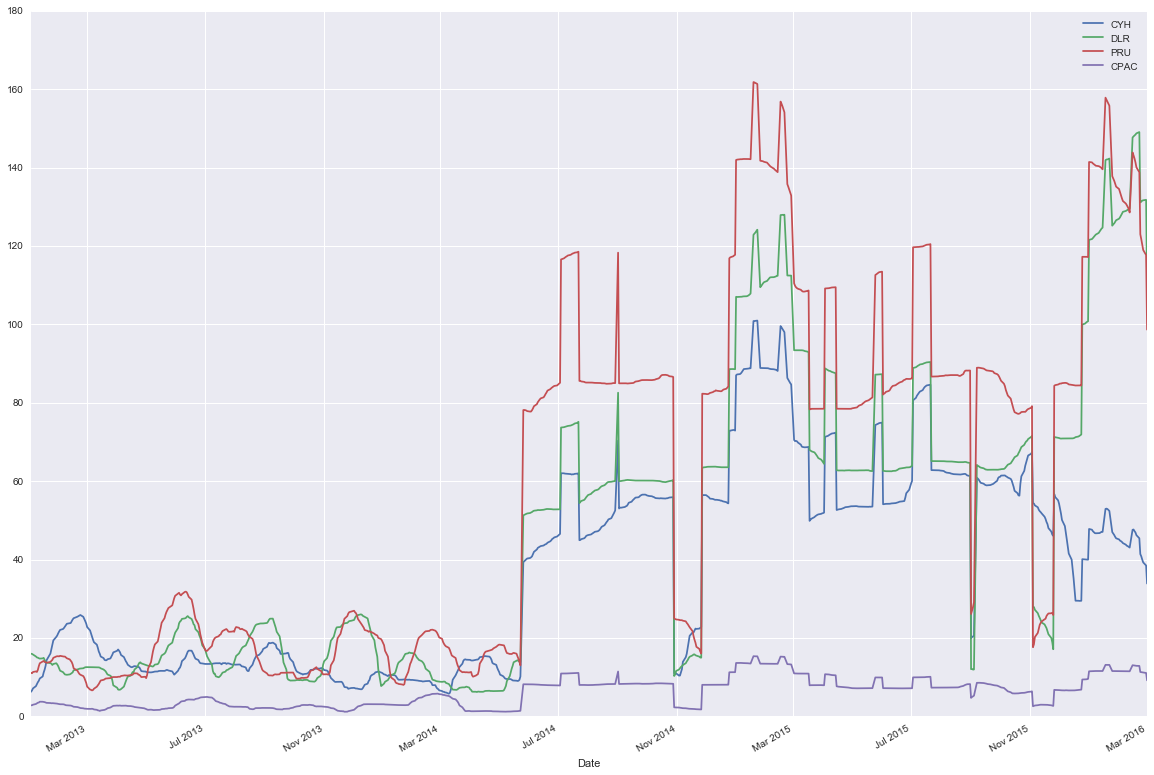

In [164]:
vol_sample.plot()

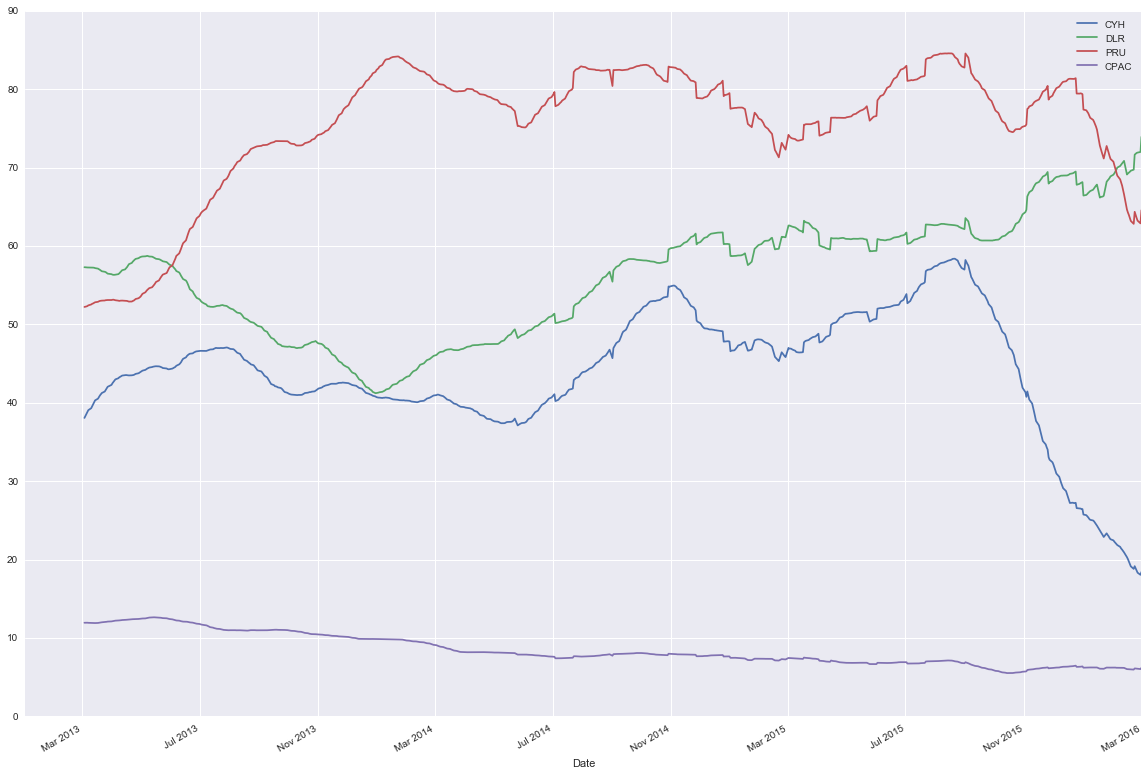

In [165]:
ac_sample.plot()

In [183]:
returns_sample.head()

CODI  CVG  FDS  LXFT
Date                            
2013-01-02   NaN  NaN  NaN   NaN
2013-01-03   NaN  NaN  NaN   NaN
2013-01-04   NaN  NaN  NaN   NaN
2013-01-07   NaN  NaN  NaN   NaN
2013-01-08   NaN  NaN  NaN   NaN

In [185]:
# Regression
# More advanced metrics
for col in vol_sample.columns:
    display(pd.ols(x=vol_sample[col], y=returns_sample[col]))


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         771
Number of Degrees of Freedom:   2

R-squared:         0.0249
Adj R-squared:     0.0236

Rmse:              0.0052

F-stat (1, 769):    19.6468, p-value:     0.0000

Degrees of Freedom: model 1, resid 769

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x    -0.0001     0.0000      -4.43     0.0000    -0.0001    -0.0001
     intercept     0.0013     0.0003       4.13     0.0000     0.0007     0.0019
---------------------------------End of Summary---------------------------------


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         771
Number of Degrees of Freedom:   2

R-squared:         0.0226
Adj R-squared:     0.0213

Rmse:              0.0054

F-stat (1, 769):    17.7720, p-value:     0.0000

Degrees of Freedom: model 1, resid 769

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x    -0.0001     0.0000      -4.22     0.0000    -0.0001    -0.0000
     intercept     0.0015     0.0003       4.80     0.0000     0.0009     0.0022
---------------------------------End of Summary---------------------------------


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         771
Number of Degrees of Freedom:   2

R-squared:         0.0126
Adj R-squared:     0.0113

Rmse:              0.0053

F-stat (1, 769):     9.8289, p-value:     0.0018

Degrees of Freedom: model 1, resid 769

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x    -0.0000     0.0000      -3.14     0.0018    -0.0000    -0.0000
     intercept     0.0013     0.0003       4.34     0.0000     0.0007     0.0019
---------------------------------End of Summary---------------------------------


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         692
Number of Degrees of Freedom:   2

R-squared:            nan
Adj R-squared:        nan

Rmse:                 nan

F-stat (1, 690):        nan, p-value:        nan

Degrees of Freedom: model 1, resid 690

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x       -inf        nan        nan        nan        nan        nan
     intercept        inf        nan        nan        nan        nan        nan
---------------------------------End of Summary---------------------------------

In [189]:
# Regression
# More advanced metrics
for col in vol_sample.columns:
    display(vol_sample[col].corr(returns_sample[col]))

-0.15783550563169008

-0.15029491986157736

-0.11233928261755464

nan


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         771
Number of Degrees of Freedom:   2

R-squared:         0.0126
Adj R-squared:     0.0113

Rmse:              0.0053

F-stat (1, 769):     9.8289, p-value:     0.0018

Degrees of Freedom: model 1, resid 769

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x    -0.0000     0.0000      -3.14     0.0018    -0.0000    -0.0000
     intercept     0.0013     0.0003       4.34     0.0000     0.0007     0.0019
---------------------------------End of Summary---------------------------------


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         771
Number of Degrees of Freedom:   2

R-squared:         0.0126
Adj R-squared:     0.0113

Rmse:              0.0053

F-stat (1, 769):     9.8289, p-value:     0.0018

Degrees of Freedom: model 1, resid 769

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x    -0.0000     0.0000      -3.14     0.0018    -0.0000    -0.0000
     intercept     0.0013     0.0003       4.34     0.0000     0.0007     0.0019
---------------------------------End of Summary---------------------------------


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         771
Number of Degrees of Freedom:   2

R-squared:         0.0126
Adj R-squared:     0.0113

Rmse:              0.0053

F-stat (1, 769):     9.8289, p-value:     0.0018

Degrees of Freedom: model 1, resid 769

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x    -0.0000     0.0000      -3.14     0.0018    -0.0000    -0.0000
     intercept     0.0013     0.0003       4.34     0.0000     0.0007     0.0019
---------------------------------End of Summary---------------------------------


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         771
Number of Degrees of Freedom:   2

R-squared:         0.0126
Adj R-squared:     0.0113

Rmse:              0.0053

F-stat (1, 769):     9.8289, p-value:     0.0018

Degrees of Freedom: model 1, resid 769

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x    -0.0000     0.0000      -3.14     0.0018    -0.0000    -0.0000
     intercept     0.0013     0.0003       4.34     0.0000     0.0007     0.0019
---------------------------------End of Summary---------------------------------

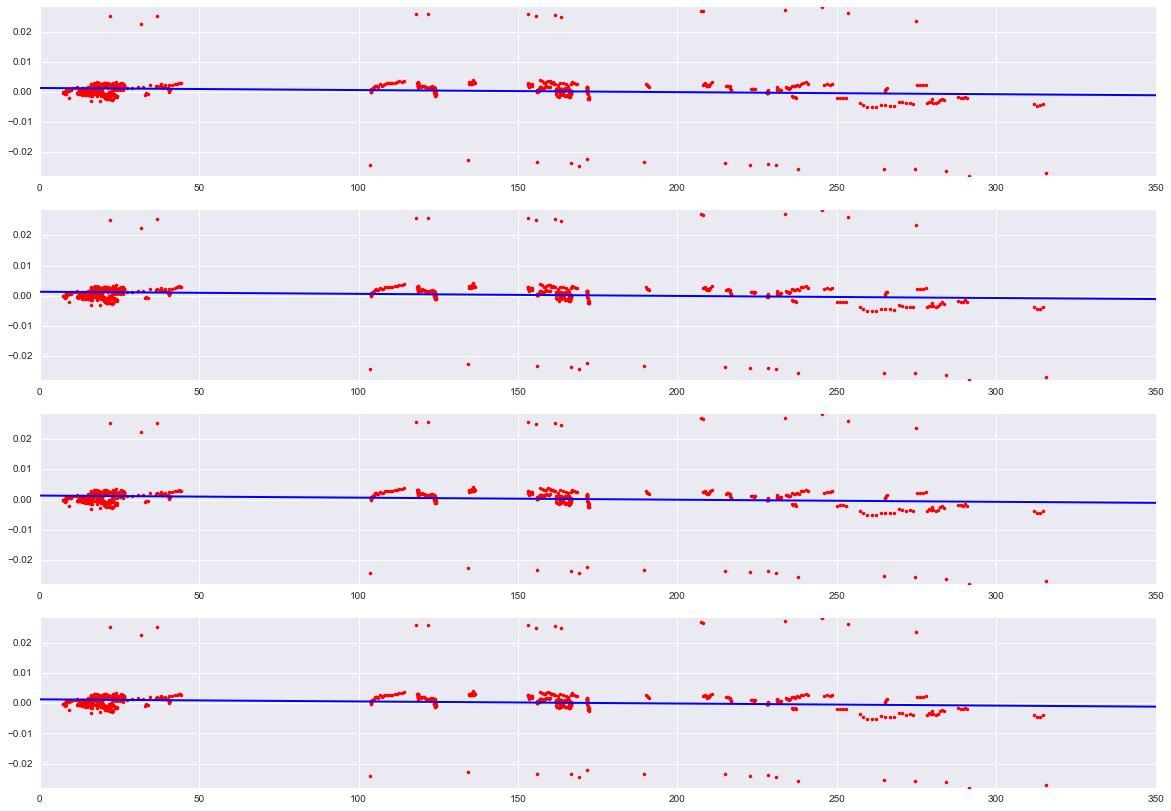

In [198]:
N = vol_sample.shape[1]
for i, symbol in enumerate(vol_sample.columns):
    xdat = vol_sample['FDS']
    ydat = returns_sample['FDS']
    model = pd.ols(x=xdat, y=ydat)
    display(model)
    plt.subplot(N, 1, i+1)
    plt.plot(xdat, ydat, 'r.')
    ax = plt.axis()
    x = np.linspace(ax[0], ax[1] + 0.01)
    plt.plot(x, model.beta[1] + model.beta[0]*x, 'b', lw=2)
    plt.axis('tight')

In [205]:
# Now, let verify it for all NYSE listed stocks
volatilities = pd.rolling_std(nyse_adjcloses, window=42) * np.sqrt(42)
nyse_vol = volatilities.sum(axis=1)
nyse_val = nyse_adjcloses.sum(axis=1)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         9088
Number of Degrees of Freedom:   2

R-squared:         0.6004
Adj R-squared:     0.6004

Rmse:           4846.1831

F-stat (1, 9086): 13652.9101, p-value:     0.0000

Degrees of Freedom: model 1, resid 9086

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.7563     0.0065     116.85     0.0000     0.7436     0.7690
     intercept  3027.9196    55.5689      54.49     0.0000  2919.0046  3136.8346
---------------------------------End of Summary---------------------------------

(0.0, 60000.010000000002, 0.0, 48405.247042331532)

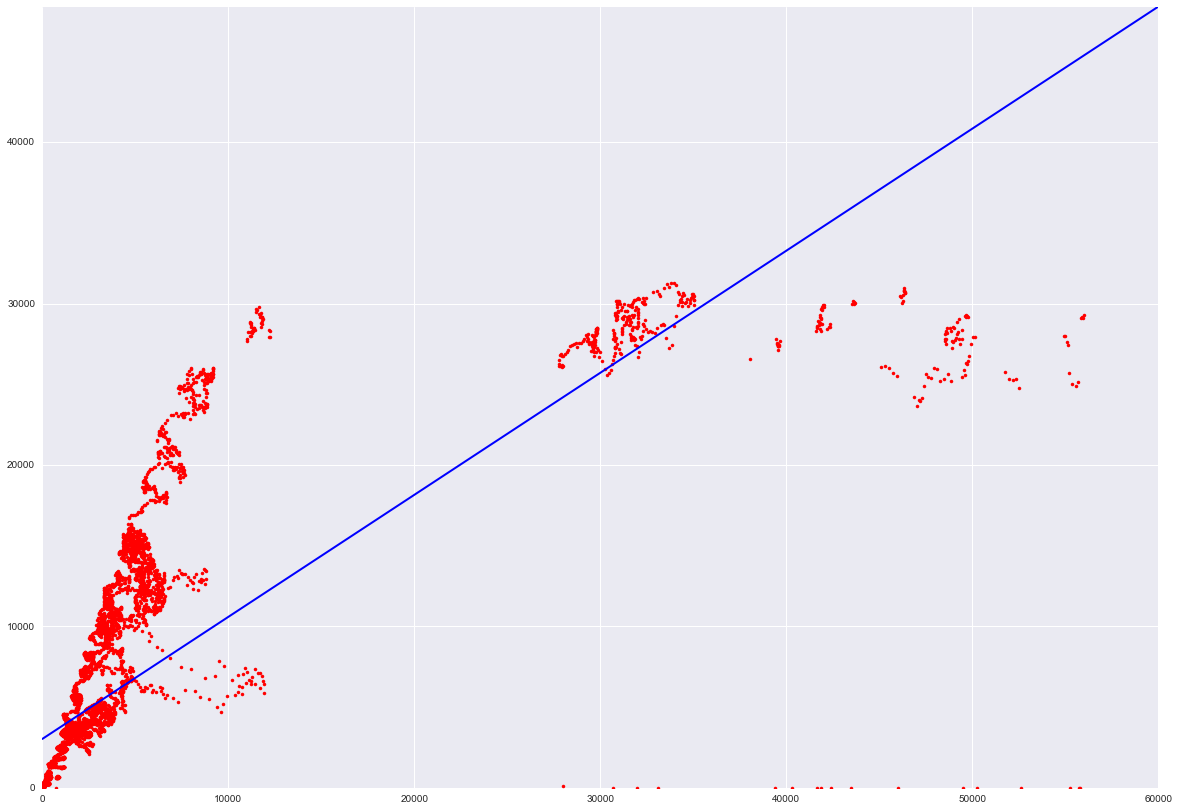

In [211]:
xdat = nyse_vol
ydat = nyse_val
model = pd.ols(x=xdat, y=ydat)
display(model)

plt.plot(xdat, ydat, 'r.')
ax = plt.axis()
x = np.linspace(ax[0], ax[1] + 0.01)
plt.plot(x, model.beta[1] + model.beta[0]*x, 'b', lw=2)
plt.axis('tight')


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         8397
Number of Degrees of Freedom:   2

R-squared:         0.8267
Adj R-squared:     0.8267

Rmse:           2063.7234

F-stat (1, 8395): 40043.8630, p-value:     0.0000

Degrees of Freedom: model 1, resid 8395

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     2.2447     0.0112     200.11     0.0000     2.2227     2.2667
     intercept   279.2748    29.1200       9.59     0.0000   222.1995   336.3500
---------------------------------End of Summary---------------------------------

(0.0, 12000.01, 0.0, 27216.035585364894)

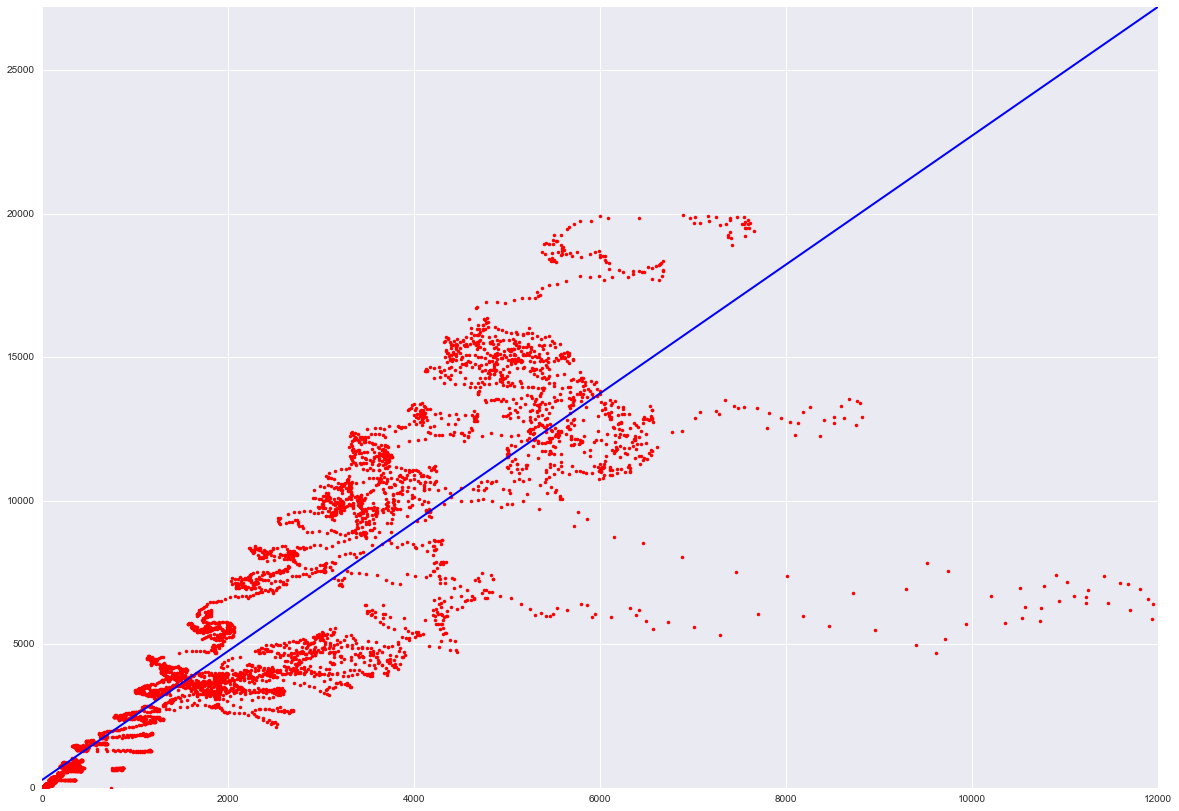

In [232]:
# We see strong outliners that influence the regression model,
# let's get rid of them

lte_20k_val = nyse_val <= 20000
lte_20k_vol = nyse_vol <= 20000
lte_20k = lte_20k_val & lte_20k_vol

xdat = nyse_vol[lte_20k]
ydat = nyse_val[lte_20k]
model = pd.ols(x=xdat, y=ydat)
display(model)

plt.plot(xdat, ydat, 'r.')
ax = plt.axis()
x = np.linspace(ax[0], ax[1] + 0.01)
plt.plot(x, model.beta[1] + model.beta[0]*x, 'b', lw=2)
plt.axis('tight')

In [235]:
# Indeed, there is a strong correlation between stock volatility and its value.

xdat.corr(ydat)

0.9092242560779048

In [ ]:
# TODO: High freq data
df.info()
stock_resamp = df.resample(rule='5min', how='mean')
display(np.round(stock_resamp.head(), 2))

### Economic simulation

Here we simulate the wealth distribution using different starting wealth distributions, trasnaction models, and parties limitations (who can trade with whom).

Numpy comes with a lot of different distributions: http://docs.scipy.org/doc/numpy/reference/routines.random.html

Here, we will select a few for our starting wealth distribution:

In [431]:
N = 5000  # Default size of population
mu = 100. # Default mean of population's wealth

def constant(mu=mu, N=N): return np.ones(N) * mu
def uniform(mu=mu, width=mu, N=N): return npr.uniform(low=mu - width/2, high=mu + width/2, size=N)
def gauss(mu=mu, sigma=mu/3, N=N): return npr.normal(loc=mu, scale=sigma, size=N)
def beta(alpha=2, beta=3, N=N): return npr.beta(alpha, beta, size=N)
def pareto(alpha=4, N=N): return npr.pareto(alpha, size=N)

def normalize(numbers, total):
    "Scale the numbers so that they add up to total."
    factor = total / float(sum(numbers))
    return [x * factor for x in numbers]

In [356]:
[display(dist()) for dist in [constant, uniform, gauss, beta, pareto]]

array([ 100.,  100.,  100., ...,  100.,  100.,  100.])

array([  70.16168551,   64.52677545,  135.29127959, ...,   50.6940738 ,
         82.77486674,  111.4150245 ])

array([ 101.29009027,   28.32111929,  124.53264046, ...,  114.4271412 ,
         87.20979946,  124.63899741])

array([ 0.20454274,  0.05470451,  0.15547521, ...,  0.68132961,
        0.47972459,  0.70554351])

array([ 0.16004432,  0.25624106,  2.08895084, ...,  0.117528  ,
        0.25017361,  1.07985404])

[None, None, None, None, None]

#### Transaction models

In a transaction, two actors come together; they have existing wealth levels X and Y.  For now we will only consider transactions that conserve wealth, so our transaction rules will decide how to split up the pot of X+Y total wealth.

In [432]:
def random_split(X, Y):
    "Take all the money in the pot and divide it randomly between X and Y."
    pot = X + Y
    m = npr.uniform(0, pot)
    return m, pot - m
    
def winner_take_most(X, Y, most=3/4.): 
    "Give most of the money in the pot to one of the parties."
    pot = X + Y
    m = npr.choice([most * pot, (1 - most) * pot])
    return m, pot - m

def winner_take_all(X, Y): 
    "Give all the money in the pot to one of the actors."
    return winner_take_most(X, Y, 1.0)

def redistribute(X, Y): 
    "Give 55% of the pot to the winner; 45% to the loser."
    return winner_take_most(X, Y, 0.55)

def split_half_min(X, Y):
    """The poorer actor only wants to risk half his wealth; 
    the other actor matches this; then we randomly split the pot."""
    pot = min(X, Y)
    m = npr.uniform(0, pot)
    return X - pot/2. + m, Y + pot/2. - m

#### Interactions

How do you decide which parties interact with each other?  The rule `anyone` samples two members of the population uniformly and independently, but there are other possible rules, like `nearby(pop, k)`, which choses one member uniformly and then chooses a second within `k` index elements away, to simulate interactions within a local neighborhood.

In [426]:
def anyone(pop): return npr.random_integers(0, pop.size-1, 2)

def nearby(pop, k=5): 
    i = npr.random_integers(0, pop.size-1, 1)
    j = i + npr.choice([1, -1]) * npr.random_integers(1, k)
    return i, (j % len(pop))
               
def nearby1(pop): return nearby(pop, 1)

In [427]:
# Let's quickly check that the values are as expected:

print('Anyone:')
[display(anyone(constant())) for _ in range(3)]

print('Nearby:')
[display(nearby(constant())) for _ in range(3)]

print('Nearby1:')
[display(nearby1(constant())) for _ in range(3)]

Anyone:


array([3773, 2608])

array([1750,  126])

array([1838, 2248])

Nearby:


(array([2965]), array([2967], dtype=int32))

(array([2460]), array([2456], dtype=int32))

(array([2525]), array([2523], dtype=int32))

Nearby1:


(array([875]), array([874], dtype=int32))

(array([760]), array([761], dtype=int32))

(array([4492]), array([4493], dtype=int32))

[None, None, None]

#### Simulation

Now let's describe the code to run the simulation and summarize/plot the results.  The function `simulate` does the work; it runs the interaction function to find two actors, then calls the transaction function to figure out how to split their wealth, and repeats this T times. The only other thing it does is record results.  Every so-many steps, it records some summary statistics of the population (by default, this will be every 25 steps).

What information do we record to summarize the population?  Out of the N=5000 (by default) actors, we will record the wealth of exactly nine of them: the ones, in sorted-by-wealth order that occupy the 1% spot (that is, if N=5000, this would be the 50th wealthiest actor), then the 10%, 25% 1/3, and median; and then likewise from the bottom the 1%, 10%, 25% and 1/3.

(Note that we record the *median*, which changes over time; the *mean* is defined to be 100 when we start, and since all transactions conserve wealth, the mean will always be 100.)

What do we do with these results, once we have recorded them?  First we print them in a table for the first time step, the last, and the middle.  Then we plot them as nine lines in a plot where the y-axis is wealth and the x-axis is time (note that when the x-axis goes from 0 to 1000, and we have `record_every=25`, that means we have actually done 25,000 transactions, not 1000).

In [446]:
def simulate(population, transaction_fn, interaction_fn, T, percentiles, record_every):
    "Run simulation for T steps; collect percentiles every 'record_every' time steps."
    results = []
    for t in range(T):
        i, j = interaction_fn(population)
        population[i], population[j] = transaction_fn(population[i], population[j]) 
        if t % record_every == 0:
            results.append(record_percentiles(population, percentiles))
    return results

def report(distribution=gauss, transaction_fn=random_split, interaction_fn=anyone, N=N, mu=mu, T=5*N, 
           percentiles=(1, 10, 25, 33.3, 50, -33.3, -25, -10, -1), record_every=25):
    "Print and plot the results of the simulation running T steps." 
    
    # Run simulation
    if name(distribution) not in ['beta', 'pareto', 'uniform', 'constant']:
        population = distribution(mu=mu, sigma=sigma)
    else:
        population = distribution()
        
    results = simulate(population, transaction_fn, interaction_fn, T, percentiles, record_every)
    # Print summary
    print('Simulation: {} * {}(mu={}) for T={} steps with {} doing {}:\n'.format(
          N, name(distribution), mu, T, name(interaction_fn), name(transaction_fn)))
    fmt = '{:6}' + '{:10.2f} ' * len(percentiles)
    print(('{:6}' + '{:>10} ' * len(percentiles)).format('', *map(percentile_name, percentiles)))
    for (label, nums) in [('start', results[0]), ('mid', results[len(results)//2]), ('final', results[-1])]:
        print(fmt.format(label, *nums))
    # Plot results
    for line in zip(*results):
        plt.plot(line)
    plt.show()

def record_percentiles(population, percentiles):
    "Pick out the percentiles from population."
    population = sorted(population, reverse=True)
    N = len(population)
    return [population[int(p*N/100.)] for p in percentiles]

def percentile_name(p):
    return ('median' if p == 50 else 
            '{} {}%'.format(('top' if p > 0 else 'bot'), abs(p)))
    
def name(obj):
    return getattr(obj, '__name__', str(obj))


#### Simulations Results

Finally, let's run a simulation!

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with anyone doing random_split:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.57     100.32     100.17     100.11     100.00      99.89      99.83      99.67      99.42 
mid       405.95     219.65     139.75     115.12      77.17      46.05      32.95      11.77       1.28 
final     441.22     226.62     138.14     108.98      71.60      43.47      31.41      11.83       1.11 


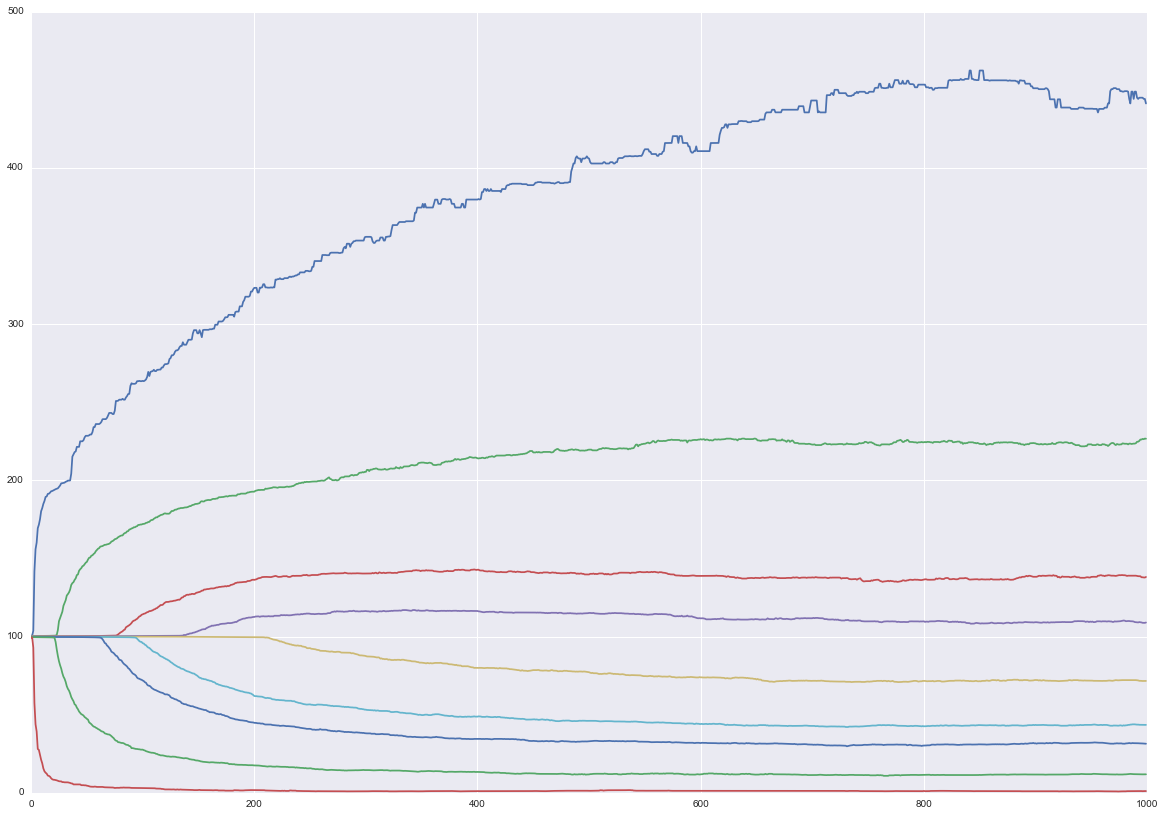

In [447]:
report(gauss, random_split)

How do we interpret this?  Well, we can see the mass of wealth spreading out: the rish get richer and the poor get poorer.  We know the rich get richer because the blue and green lines (top 10% and top 1%) are going up: the actor in the 1% position (the guy with the least money out of the 1%, or to put it another way, the most money out of the 99%) starts with 177.13 and ends up with 447.98 (note this is not necessarily the same guy, just the guy who ends up in that position).  The guy at the 10% spot also gets richer, going from 141.87 to 228.06.  The 25% and 33% marks stay roughly flat, but everyone else gets poorer! The median actor loses 30% of his wealth, and the bottom 1% actor loses almost 95% of his wealth.

#### Effect of starting population

Now let's see if the starting population makes any difference. My vague impression is that we're dealing with ergodic Markov chains and it doesn't much matter what state you start in. But let's see:

Simulation: 5000 * uniform(mu=100.0) for T=25000 steps with anyone doing random_split:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     149.14     140.75     126.22     118.05     100.58      83.87      75.60      59.95      51.23 
mid       417.12     223.32     143.43     116.56      74.61      43.99      31.09      11.90       1.20 
final     448.21     232.71     139.23     110.98      70.37      41.86      30.45      10.99       1.11 


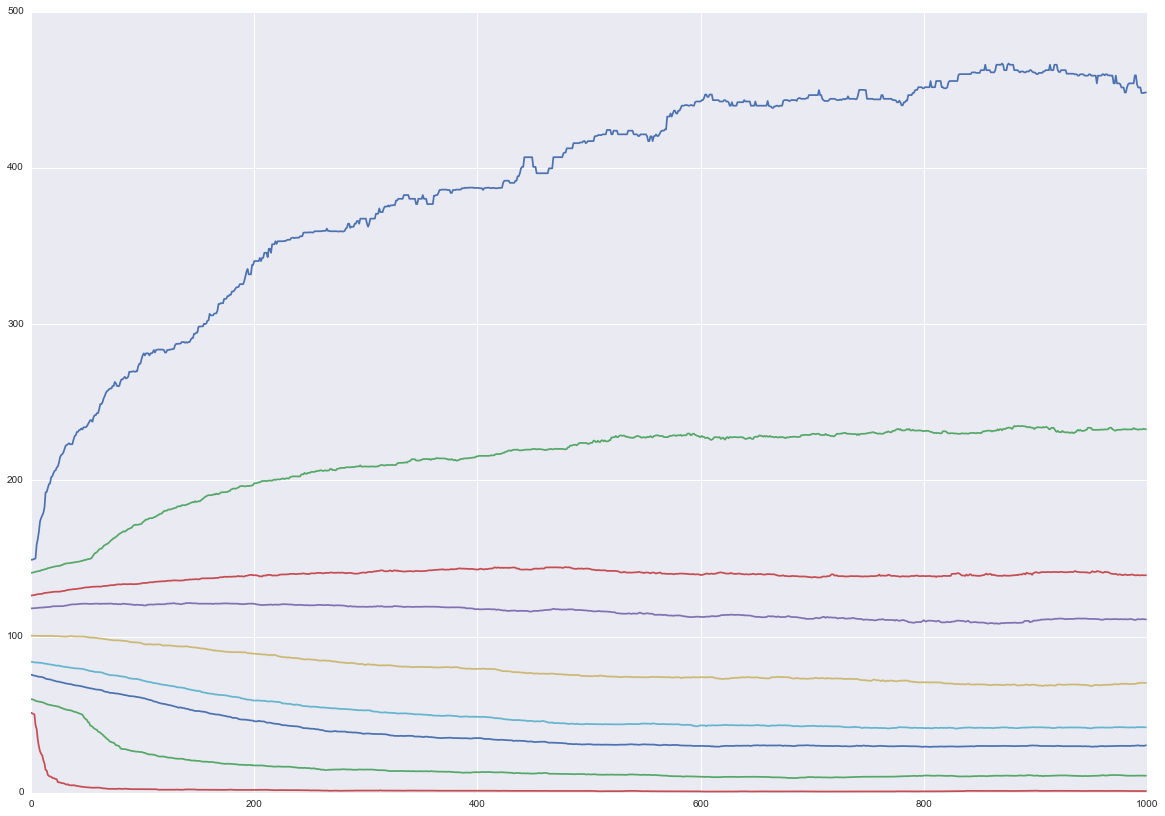

Simulation: 5000 * beta(mu=100.0) for T=25000 steps with anyone doing random_split:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start       0.86       0.68       0.55       0.48       0.38       0.29       0.24       0.14       0.04 
mid         1.61       0.92       0.55       0.45       0.29       0.18       0.13       0.05       0.00 
final       1.72       0.92       0.55       0.44       0.28       0.16       0.12       0.04       0.00 


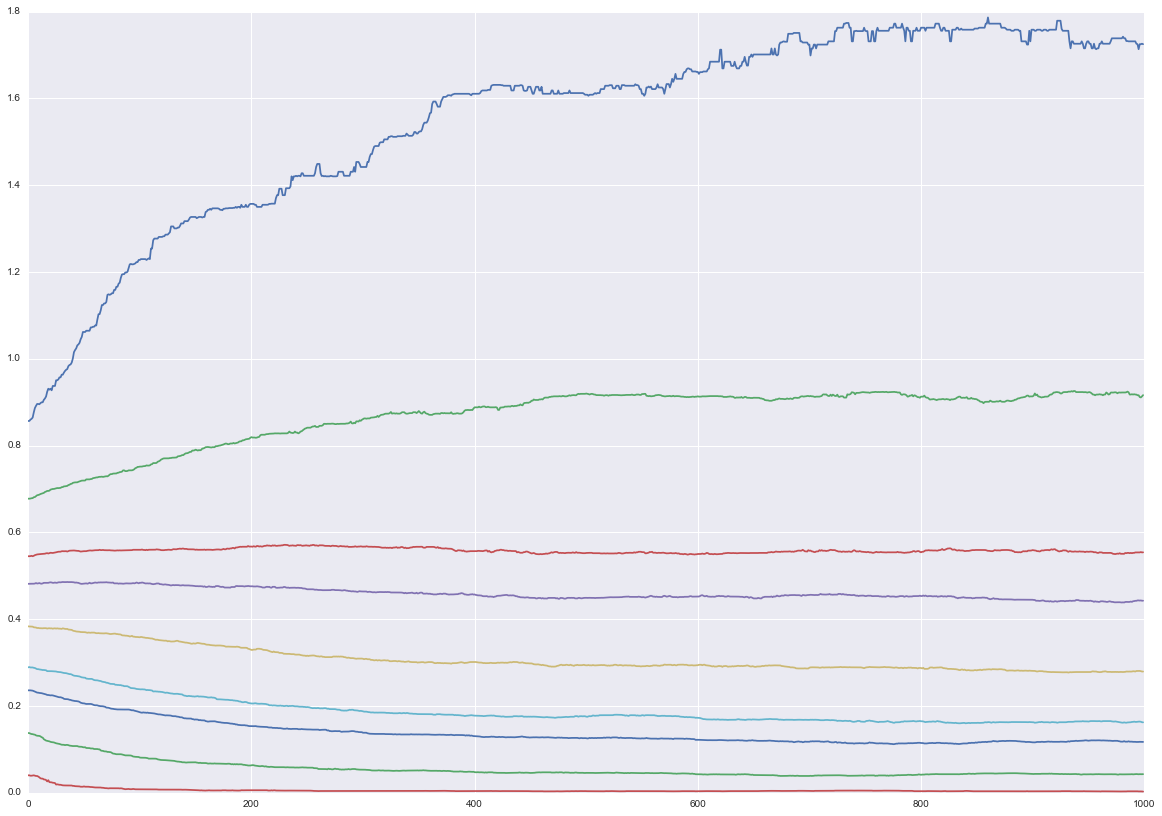

Simulation: 5000 * pareto(mu=100.0) for T=25000 steps with anyone doing random_split:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start       2.19       0.80       0.41       0.33       0.19       0.11       0.07       0.03       0.00 
mid         1.71       0.78       0.45       0.36       0.22       0.13       0.09       0.03       0.00 
final       1.57       0.79       0.47       0.37       0.23       0.13       0.09       0.04       0.00 


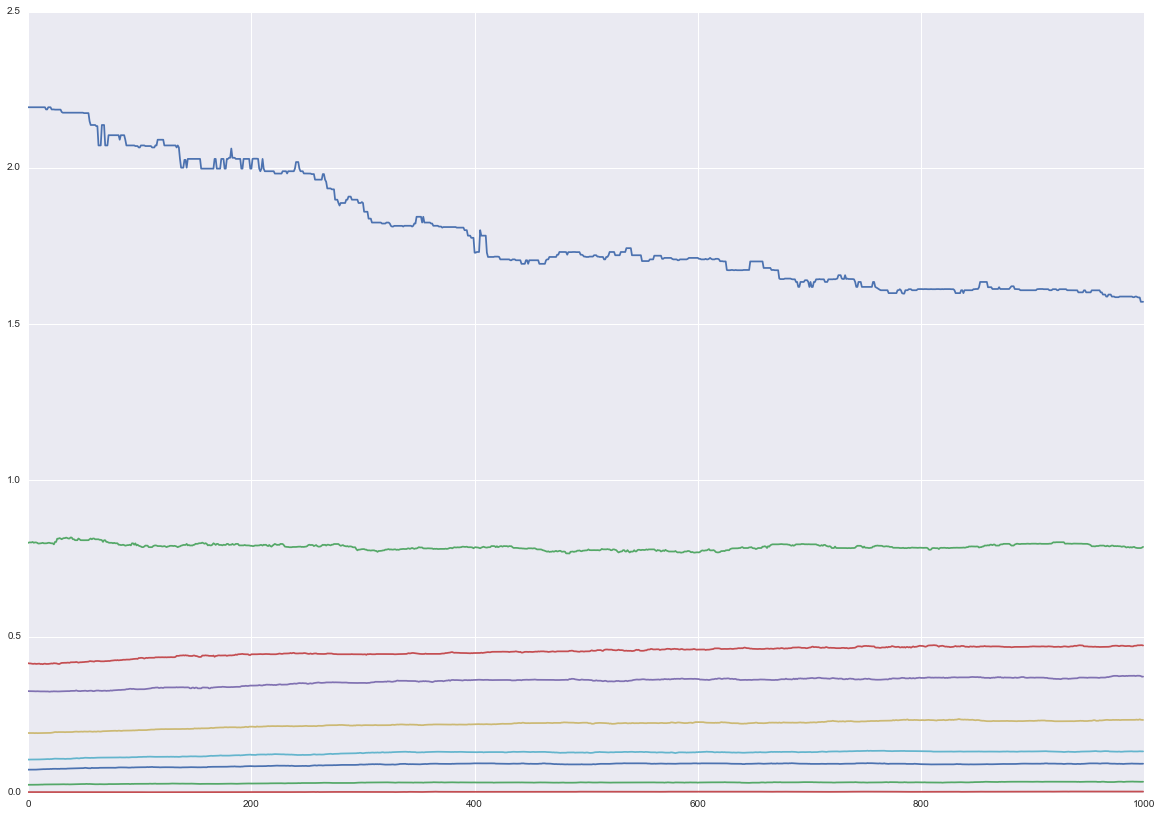

Simulation: 5000 * constant(mu=100.0) for T=25000 steps with anyone doing random_split:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.00     100.00     100.00     100.00     100.00     100.00     100.00     100.00     100.00 
mid       428.07     222.44     138.29     113.75      75.25      45.39      32.32      12.15       1.13 
final     455.22     230.75     138.83     110.33      69.55      40.37      29.16      10.93       1.26 


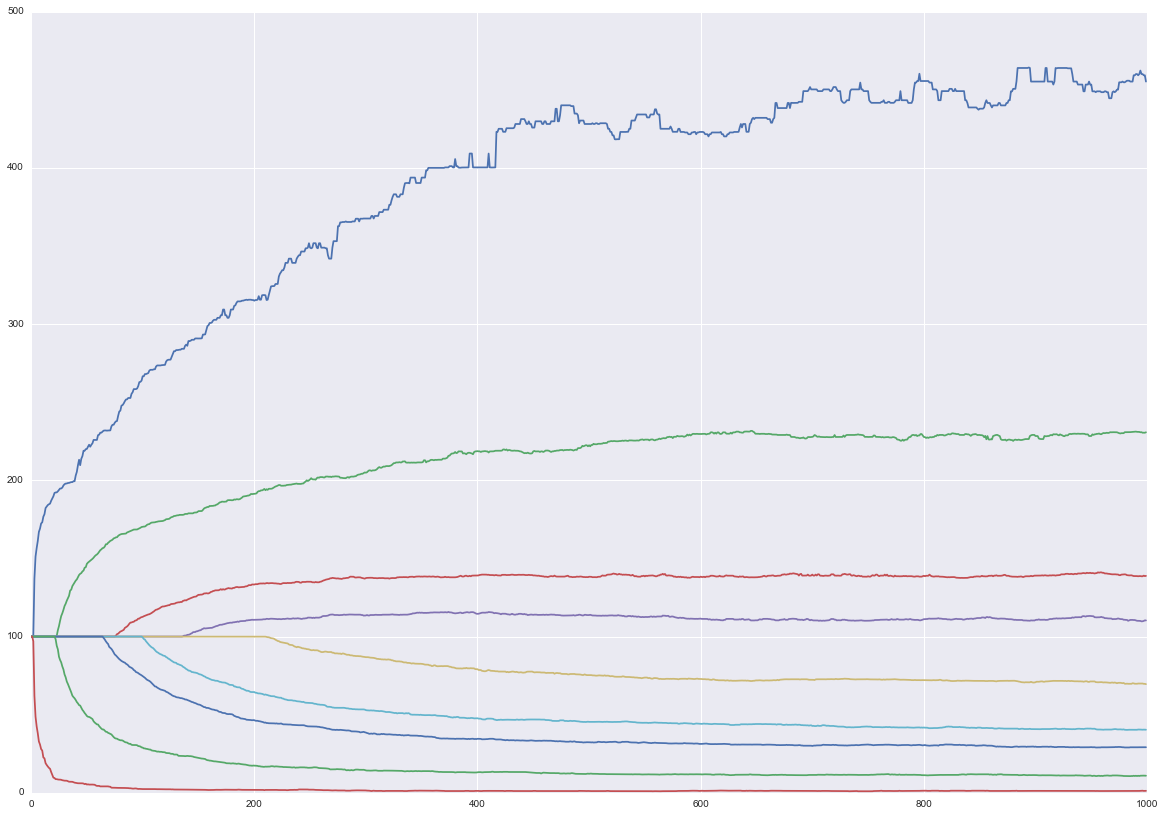

In [448]:
report(uniform, random_split)
report(beta, random_split)
report(pareto, random_split)
report(constant, random_split)

It looks like we can confirm that the starting population doesn't matter much&mdash;if we are using the `random_split` rule then in the end, wealth accumulates to the top third at the expense of the bottom two-thirds, regardless of starting population.

#### Effect of Transaction Rule

Now let's see what happens when we vary the transaction rule.  The `random_split` rule produces inequality: the actor at the bottom quarter of the population has only about a third of the mean wealth, and the actor at the top 1% spot has 4.5 times the mean.
Suppose we want a society with more income equality.  We could use the `split_half_min` rule, in which each transaction has a throttle in that the poorer party only risks half of their remaining wealth.  Or we could use the `redistribute` rule, in which the loser of a transaction still gets 45% of the total (meaning the loser will actually gain in many transactions). Let's see what effects these rules have.  In analyzing these plots, note that they have different Y-axes.

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with anyone doing random_split:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.60     100.32     100.17     100.11     100.00      99.90      99.83      99.68      99.41 
mid       421.37     221.37     139.52     112.19      76.09      45.22      32.03      11.83       1.03 
final     450.88     224.11     140.08     113.23      72.72      41.88      29.66      11.07       1.30 


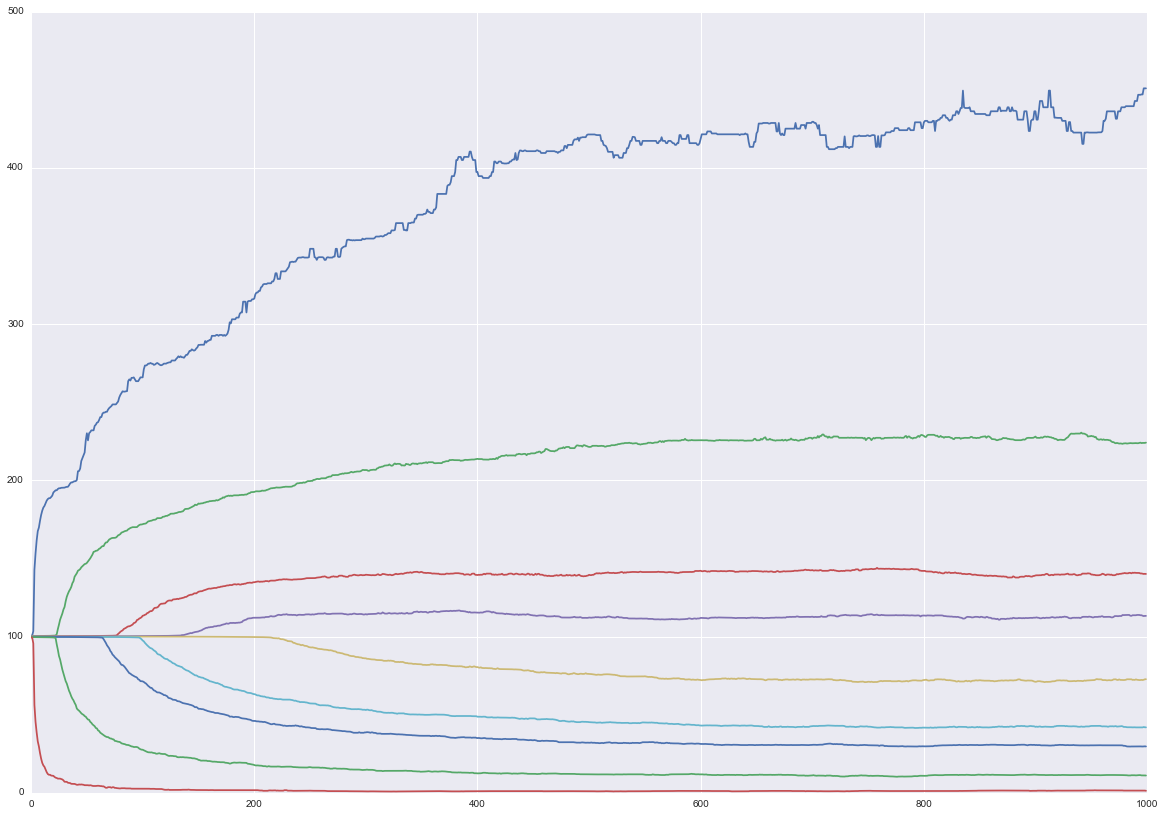

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with anyone doing redistribute:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.57     100.31     100.17     100.11     100.01      99.90      99.84      99.69      99.40 
mid       130.71     118.51     110.05     106.24      99.09      92.58      89.49      82.75      74.41 
final     133.47     119.63     109.76     105.78      99.03      92.66      89.12      81.86      72.88 


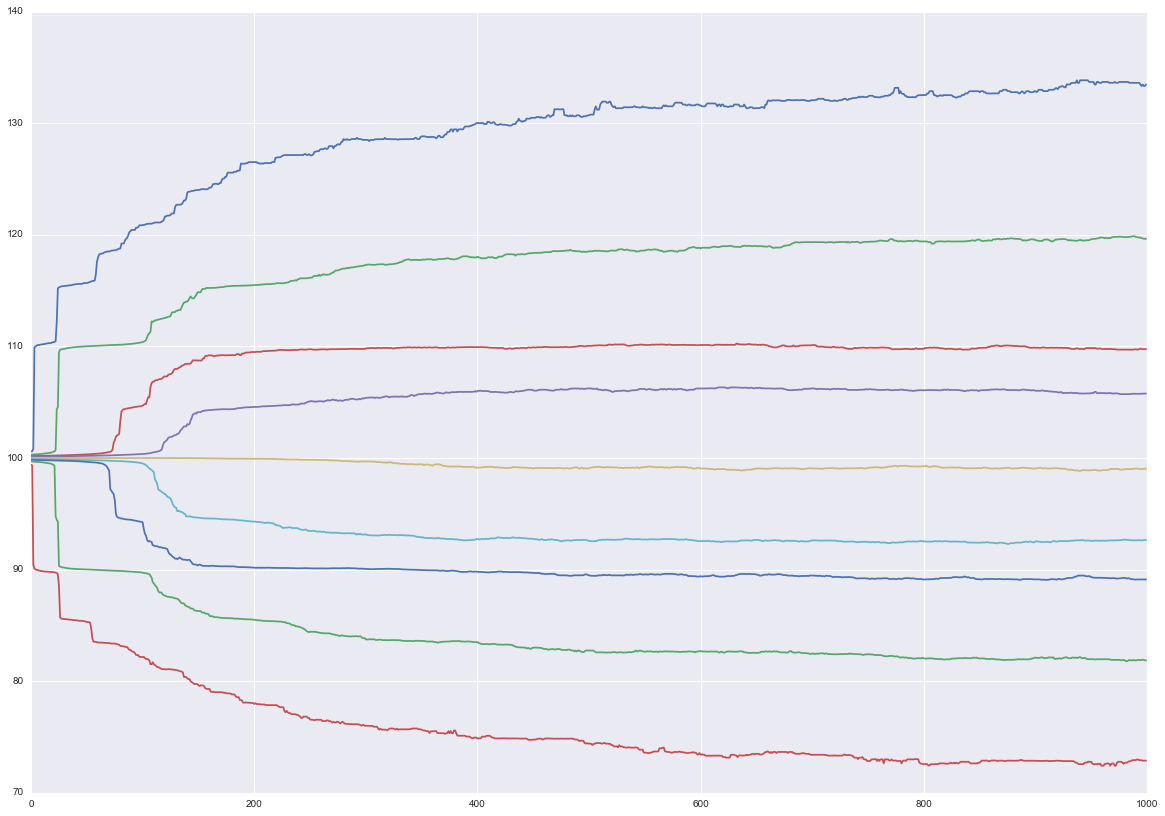

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with anyone doing split_half_min:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.59     100.32     100.16     100.11     100.00      99.89      99.83      99.68      99.44 
mid       253.56     174.27     131.65     116.52      93.08      69.80      58.98      35.93      14.84 
final     319.92     203.10     141.85     119.54      83.20      55.85      43.05      19.94       6.07 


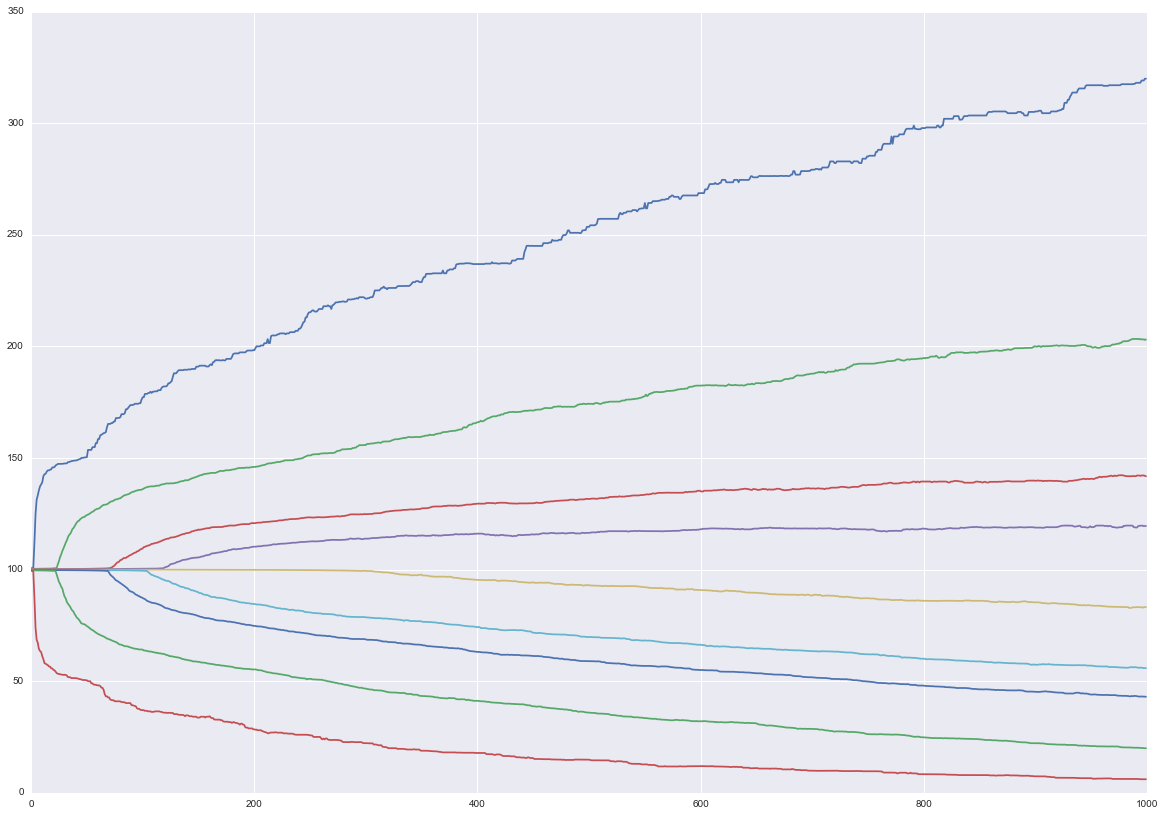

In [449]:
report(gauss, random_split)
report(gauss, redistribute)
report(gauss, split_half_min)

We see that the `redistribute`  rule is very effective in reducing income inequality: the lines of the plot all converge towards the mean of 100 instead of diverging.  With the `split_half_min` rule, inequality increases at a rate about half as fast as `random_split`.  However, the `split_half_min` plot looks like it hasn't converged yet (whereas all the other plots reach convergence at about the 500 mark).  Let's try running `split_half_min` 10 times longer:

Simulation: 5000 * gauss(mu=100.0) for T=250000 steps with anyone doing split_half_min:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.58     100.32     100.17     100.11     100.00      99.90      99.84      99.68      99.42 
mid       662.50     301.80     129.53      84.07      33.87      12.36       6.49       1.44       0.07 
final     926.03     324.31      90.41      46.96      10.77       2.25       0.91       0.07       0.00 


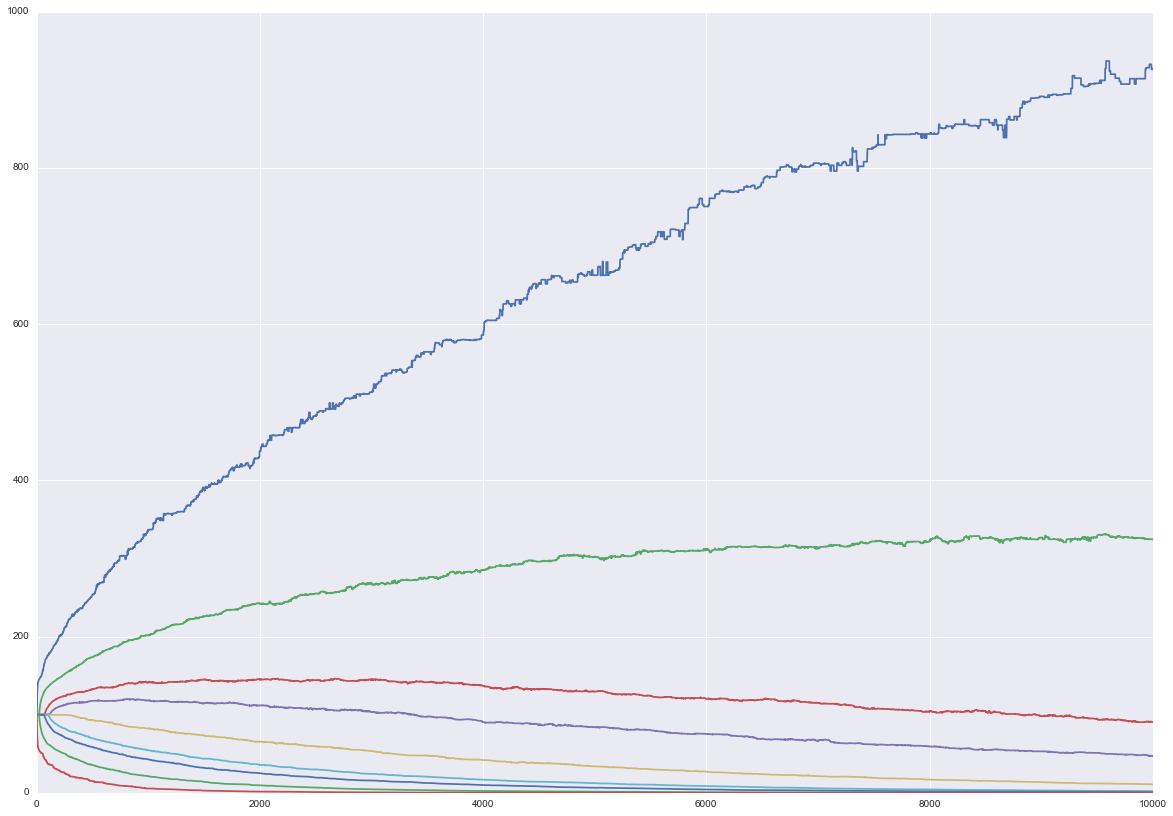

In [450]:
report(gauss, split_half_min, T=50*N)

It looks like `split_half_min` *still* hasn't converged, and is continuing to (slowly) drive wealth to the top 10%.

Now let's shift gears: suppose that we don't care about decreasing income inequality; instead we want to increase opportunity for some actors to become wealthier.  We can try the `winner_take_most` or `winner_take_all` rules (compared to the baseline `random_split`):

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with anyone doing random_split:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.60     100.31     100.16     100.11     100.00      99.90      99.84      99.68      99.41 
mid       386.64     218.50     140.53     115.03      77.47      47.01      33.64      11.26       1.16 
final     442.36     227.64     141.89     111.15      70.06      40.74      28.94      10.75       0.94 


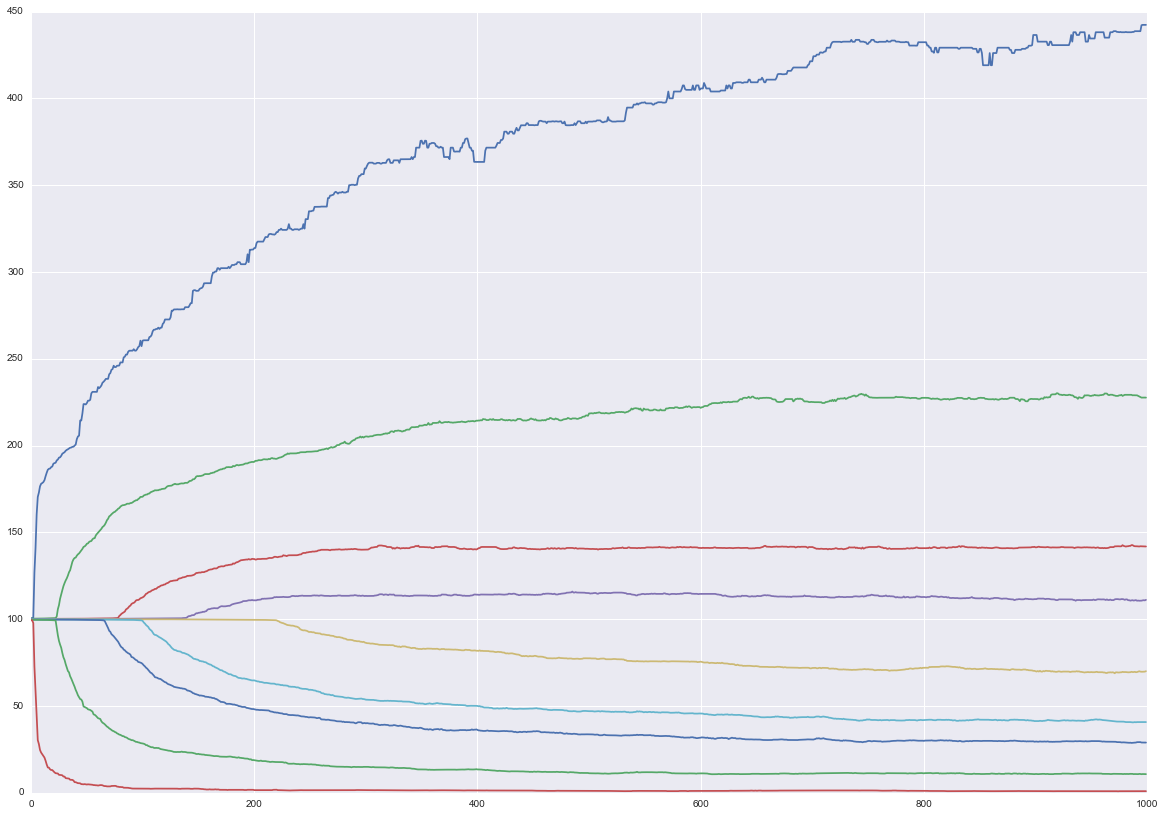

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with anyone doing winner_take_most:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.55     100.31     100.17     100.10     100.00      99.90      99.84      99.68      99.42 
mid       340.67     210.27     139.11     109.06      75.40      53.21      43.85      27.49      14.57 
final     378.14     217.82     133.94     107.62      74.10      50.92      41.03      24.70      12.40 


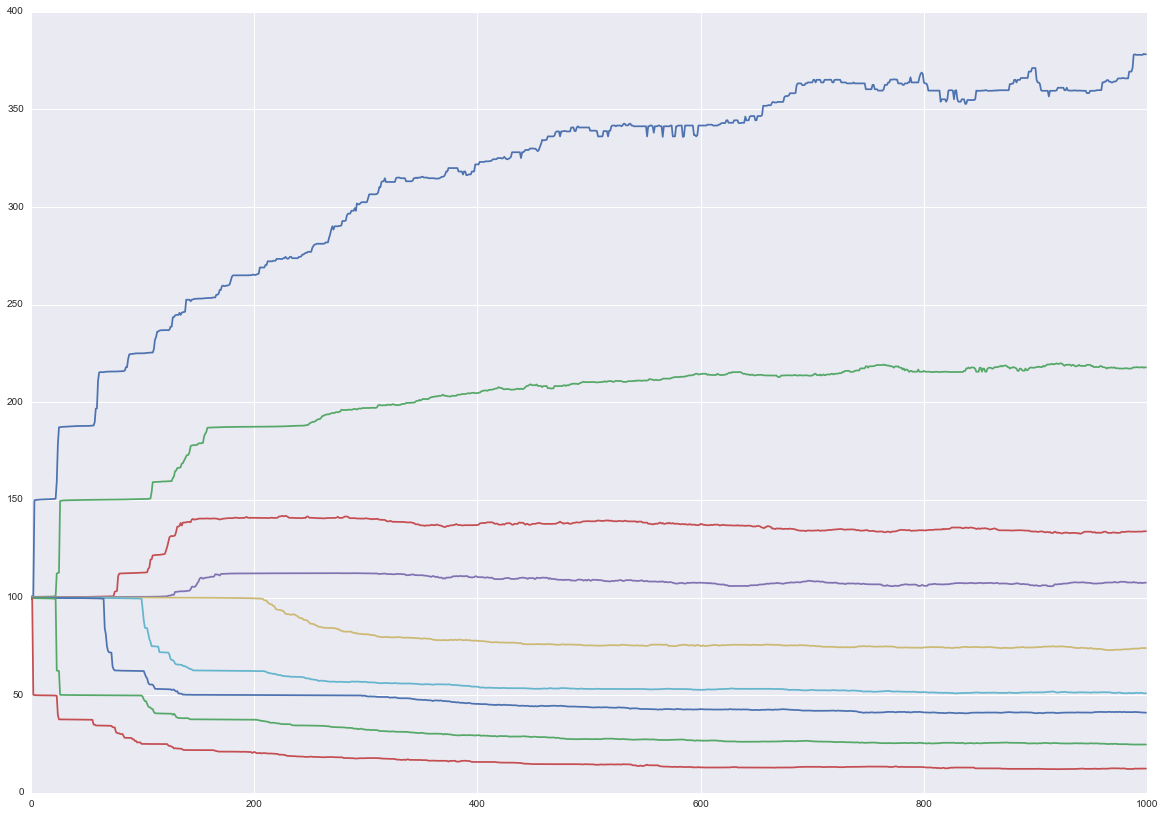

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with anyone doing winner_take_all:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.58     100.32     100.17     100.11     100.00      99.89      99.83      99.68      99.40 
mid      1099.62     399.42      99.95       0.00       0.00       0.00       0.00       0.00       0.00 
final    1698.19     300.42       0.00       0.00       0.00       0.00       0.00       0.00       0.00 


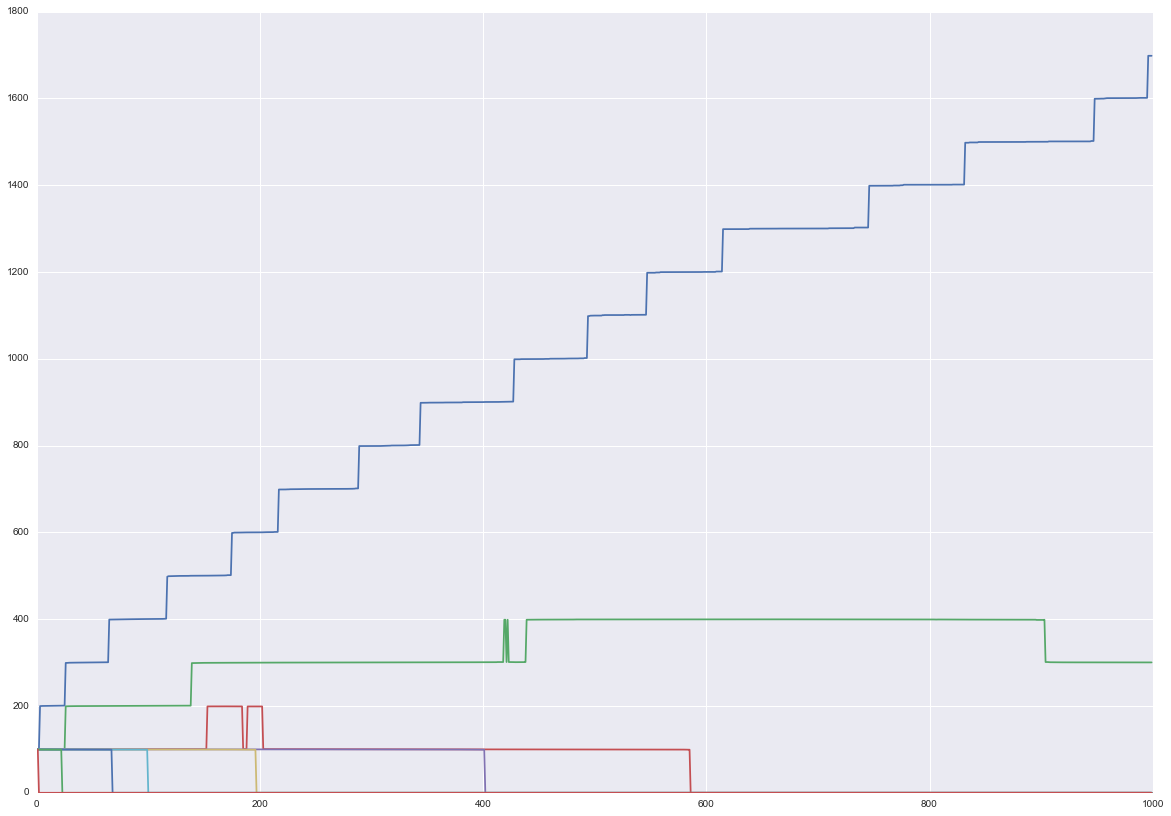

In [451]:
report(gauss, random_split)
report(gauss, winner_take_most)
report(gauss, winner_take_all)

We see that the `winner_take_most` rule, in which the winner of a transaction takes 3/4 of the pot, does not increase the opportunity for wealth as much as `random_split`, but that `winner_take_all` is very effective at concentrating almost all the wealth in the hands of the top 10%, and makes the top 1% 4 times as wealthy as `random_split`.

That suggests we look at where the breaking point is.  Let's consider several different amounts for what winner takes:

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with anyone doing winner_take_80:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.58     100.32     100.17     100.11     100.00      99.89      99.83      99.67      99.40 
mid       428.20     238.73     137.52     103.42      65.83      42.51      32.76      17.72       7.79 
final     478.39     250.89     129.74      97.57      63.45      38.51      29.43      15.71       5.81 


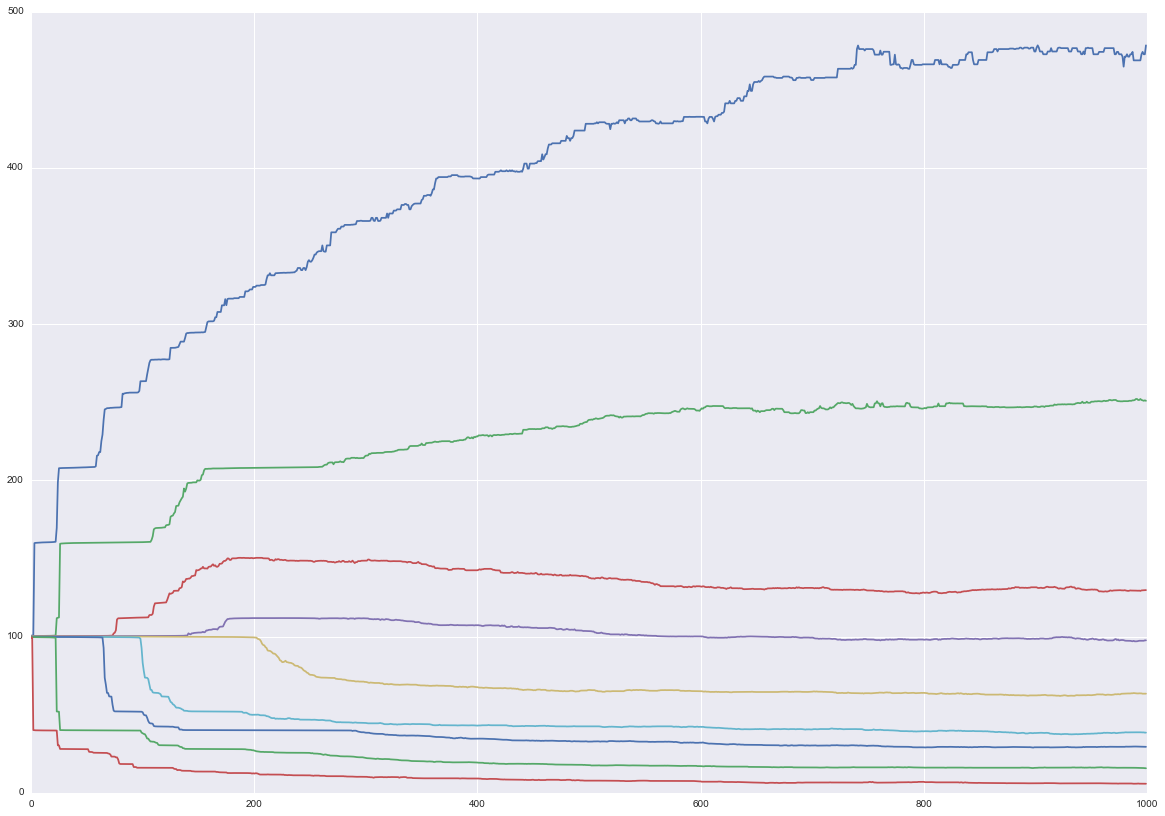

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with anyone doing winner_take_90:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.58     100.31     100.17     100.11     100.00      99.90      99.83      99.68      99.39 
mid       640.41     305.55     120.52      78.58      36.47      18.54      11.96       4.32       1.11 
final     834.41     314.56      97.81      64.50      32.65      14.23       9.13       3.44       0.71 


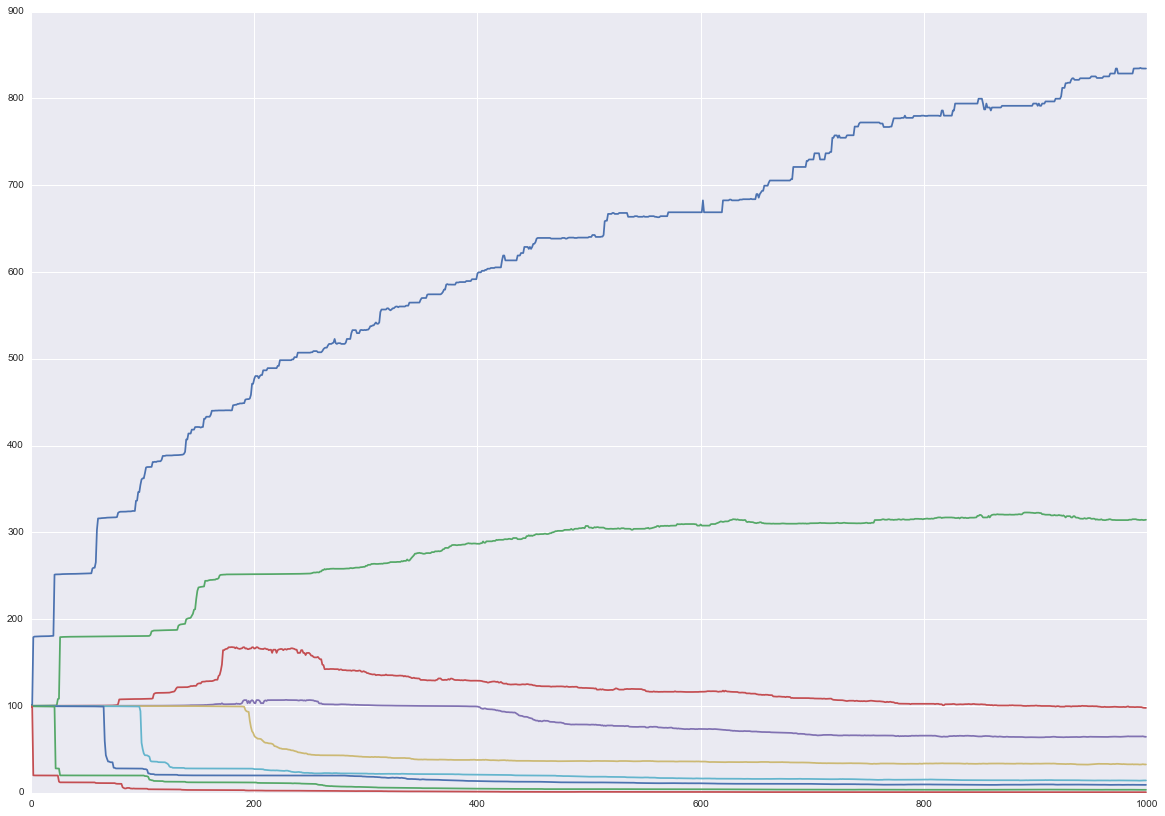

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with anyone doing winner_take_95:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.57     100.32     100.17     100.10     100.00      99.89      99.83      99.69      99.40 
mid       823.45     335.52     109.04      45.68      19.18       9.55       5.36       1.08       0.14 
final    1071.68     328.56      59.08      37.87      16.52       4.41       2.46       0.72       0.09 


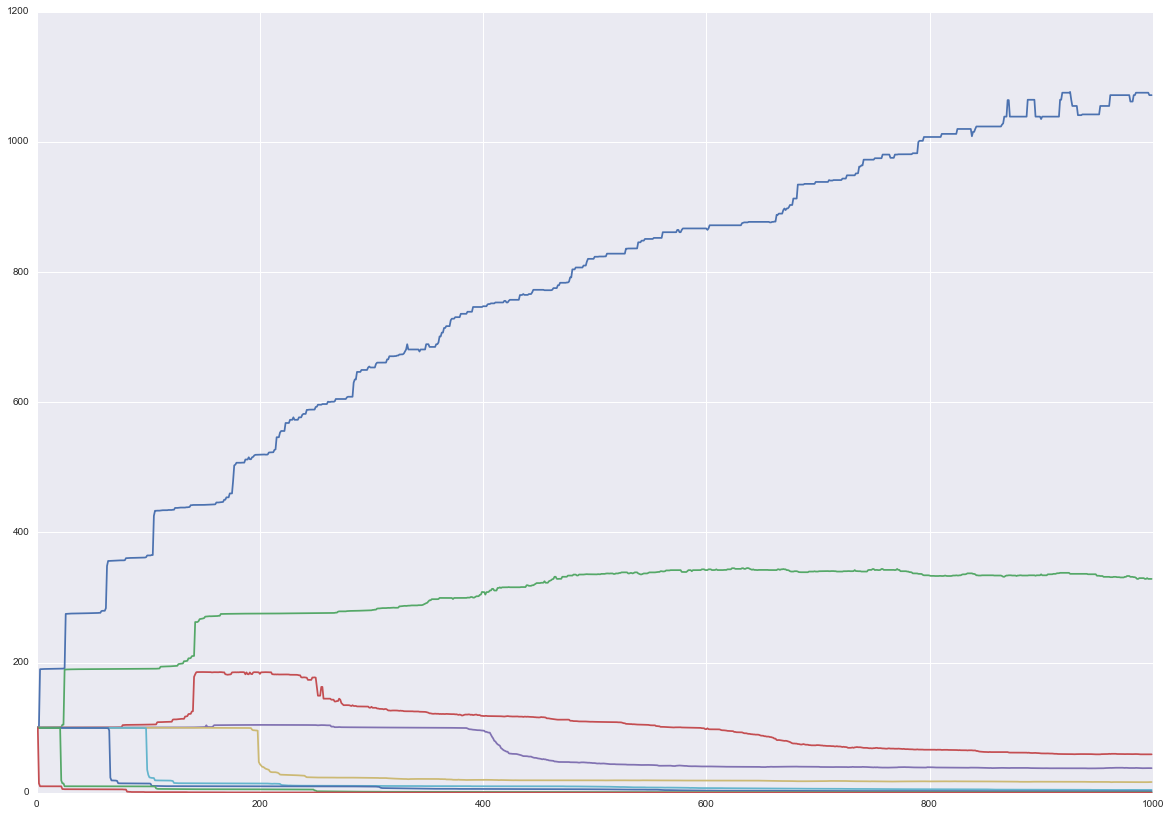

In [452]:
def winner_take_80(X, Y): return winner_take_most(X, Y, 0.80)
def winner_take_90(X, Y): return winner_take_most(X, Y, 0.90)
def winner_take_95(X, Y): return winner_take_most(X, Y, 0.95)

report(gauss, winner_take_80)
report(gauss, winner_take_90)
report(gauss, winner_take_95)

We see that winner takes 80% produces results similar to `random_split`, and that winner takes 95% is similar to winner takes all for the top 10%, but is much kinder to the bottom 75%.

#### Effect of Interactions

Suppose that transactions are constrained to be *local*; that you can only do business with your close neighbors.  Will that make income more equitable, because there will be no large, global conglomorates?  Let's see:

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with anyone doing random_split:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.59     100.33     100.17     100.12     100.00      99.89      99.83      99.68      99.40 
mid       407.56     221.52     142.17     115.38      75.45      44.16      31.87      12.26       1.05 
final     435.54     225.80     139.46     111.37      71.34      42.02      29.83      11.24       0.96 


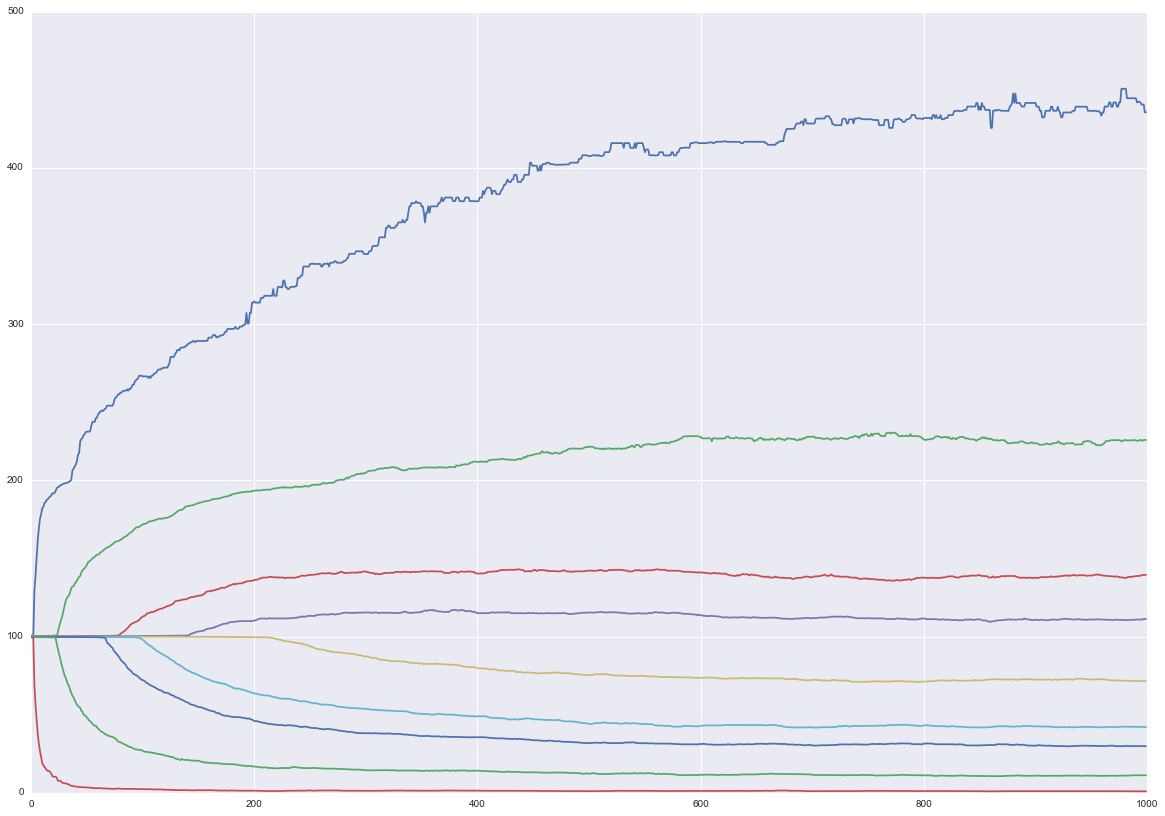

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with nearby doing random_split:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.58     100.32     100.16     100.10      99.99      99.89      99.83      99.67      99.41 
mid       381.84     221.17     142.67     116.73      76.37      45.41      32.30      12.21       1.21 
final     445.73     226.68     140.54     114.52      72.56      42.22      30.10      11.23       0.88 


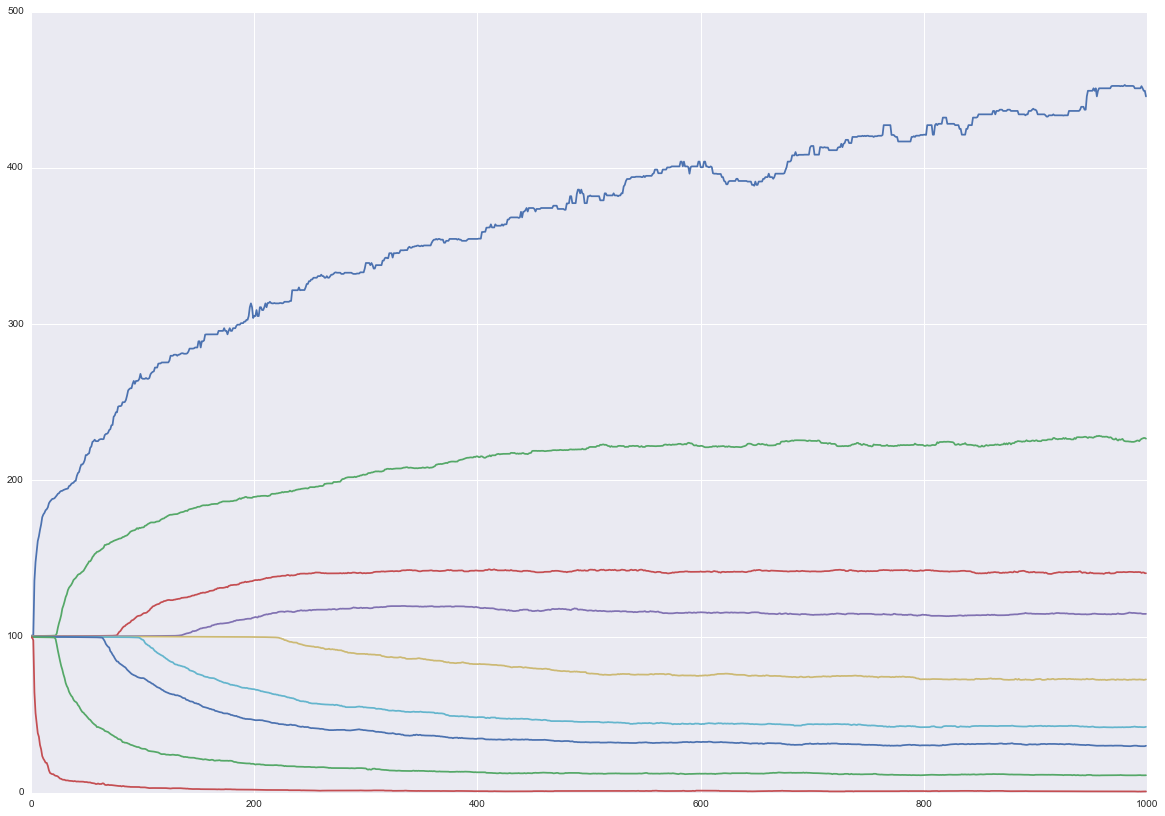

Simulation: 5000 * gauss(mu=100.0) for T=25000 steps with nearby1 doing random_split:

          top 1%    top 10%    top 25%  top 33.3%     median  bot 33.3%    bot 25%    bot 10%     bot 1% 
start     100.57     100.31     100.16     100.10     100.00      99.89      99.83      99.67      99.42 
mid       329.54     205.41     146.14     123.00      84.89      51.00      37.73      14.35       1.40 
final     371.02     223.04     142.21     117.43      77.30      46.54      34.21      12.49       1.09 


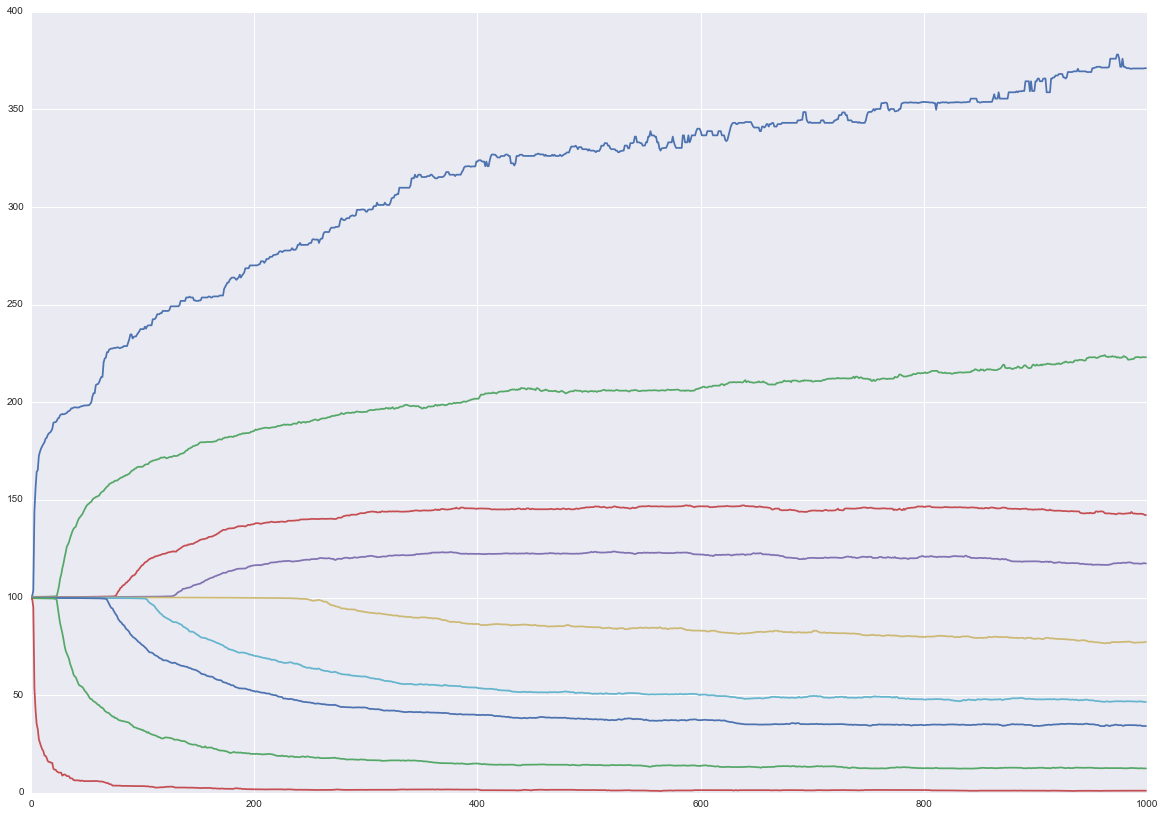

In [453]:
report(gauss, random_split, anyone)
report(gauss, random_split, nearby)
report(gauss, random_split, nearby1)

We see that the `nearby` rule, which limits transactions to your 5 closest neighbors in either direction (out of 5000 total actors), has a negligible effect on the outcome. I found that fairly surprising.  But the `nearby1` rule, which lets you do business only with your immediate left or right neighbor does have a slight effect towards income equality.  The bottom quarter still do poorly, but the top 1% only gets to about 85% of what they get under unconstrained trade.

### Stochastics

Monte Carlo Simulation (MCS) using Black-Scholes-Merton model

$$ S_T = S_0 * exp \left( \left( r - \frac{1}{2} \sigma^2 \right) * T + \sigma \sqrt(T) * z \right) $$

where

* $S_T$ - index level at date T
* $r$ - constant riskless short rate
* $\sigma$ - constant volatility (=std of returns) of S
* $z$ - standard, normally distributed variable

In [271]:
S0 = 100     # Initial value
r = 0.05     # constant short rate
sigma = 0.25 # constant volatility
T = 2.0      # in years
I = 10000    # number of random draws

ST1 = S0 * np.exp((r - .5 * sigma**2) * T + sigma * np.sqrt(T) * npr.standard_normal(I))

(array([   9.,   51.,  146.,  285.,  443.,  610.,  771.,  878.,  861.,
         830.,  785.,  712.,  611.,  567.,  441.,  376.,  337.,  236.,
         224.,  159.,  147.,   92.,  102.,   60.,   63.,   38.,   32.,
          26.,   20.,   29.,   15.,    7.,    6.,    6.,    8.,    2.,
           4.,    2.,    3.,    2.,    1.,    0.,    0.,    0.,    1.,
           0.,    1.,    0.,    0.,    1.]),
 array([  28.11791904,   35.60951309,   43.10110715,   50.59270121,
          58.08429526,   65.57588932,   73.06748338,   80.55907743,
          88.05067149,   95.54226555,  103.0338596 ,  110.52545366,
         118.01704772,  125.50864177,  133.00023583,  140.49182989,
         147.98342395,  155.475018  ,  162.96661206,  170.45820612,
         177.94980017,  185.44139423,  192.93298829,  200.42458234,
         207.9161764 ,  215.40777046,  222.89936451,  230.39095857,
         237.88255263,  245.37414668,  252.86574074,  260.3573348 ,
         267.84892885,  275.34052291,  282.83211697,  29

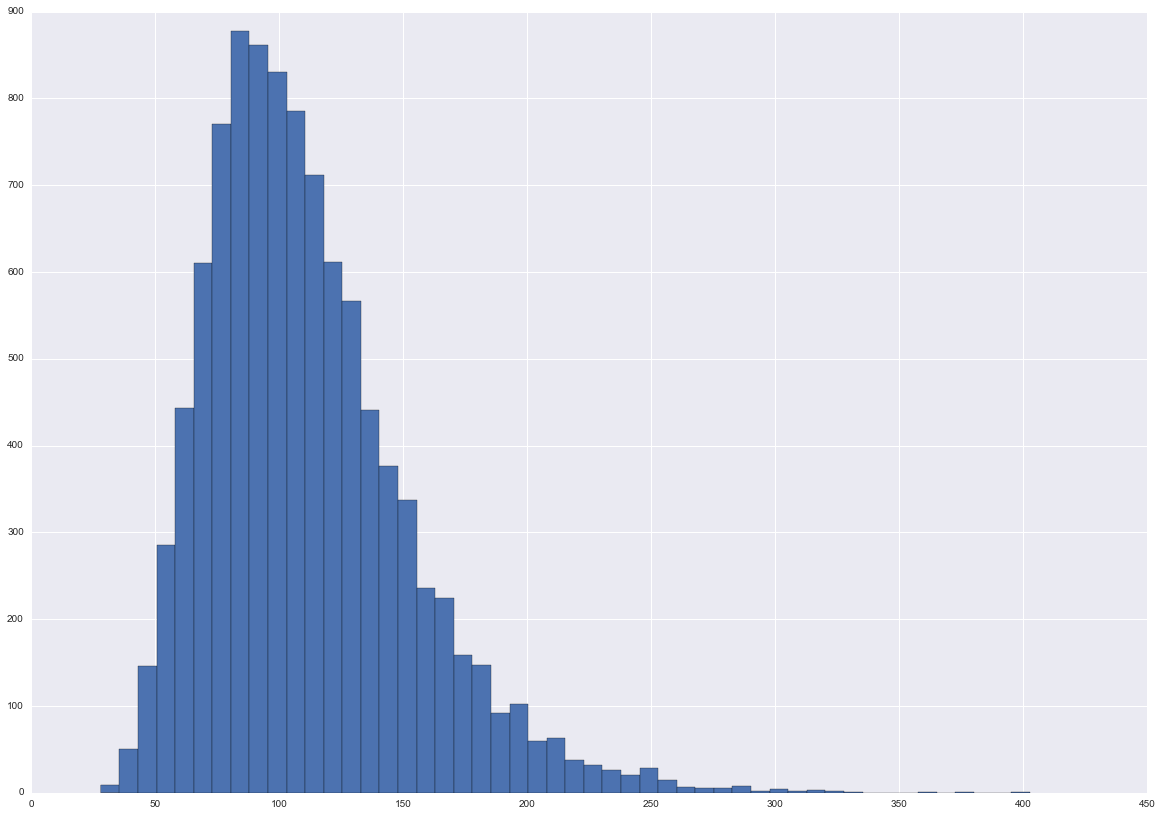

In [272]:
plt.hist(ST1, bins=50)

array([[ 1.        ,  0.99991929],
       [ 0.99991929,  1.        ]])

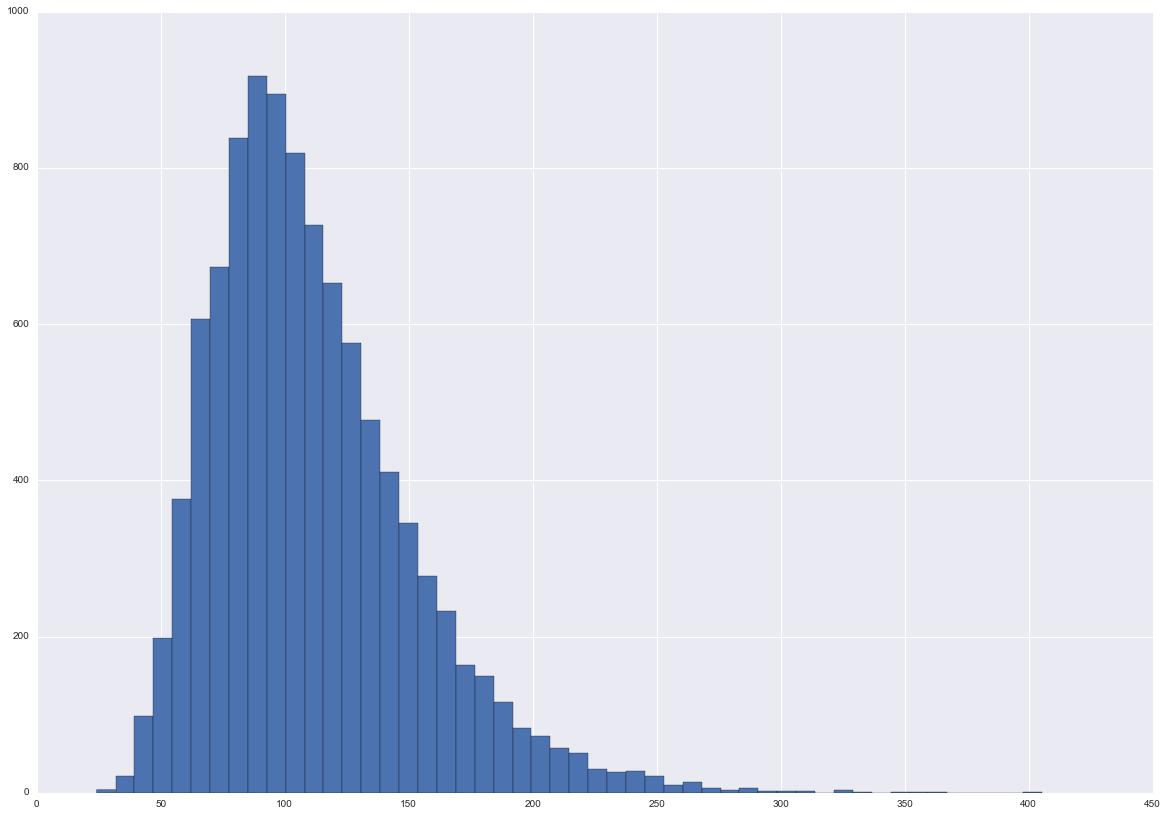

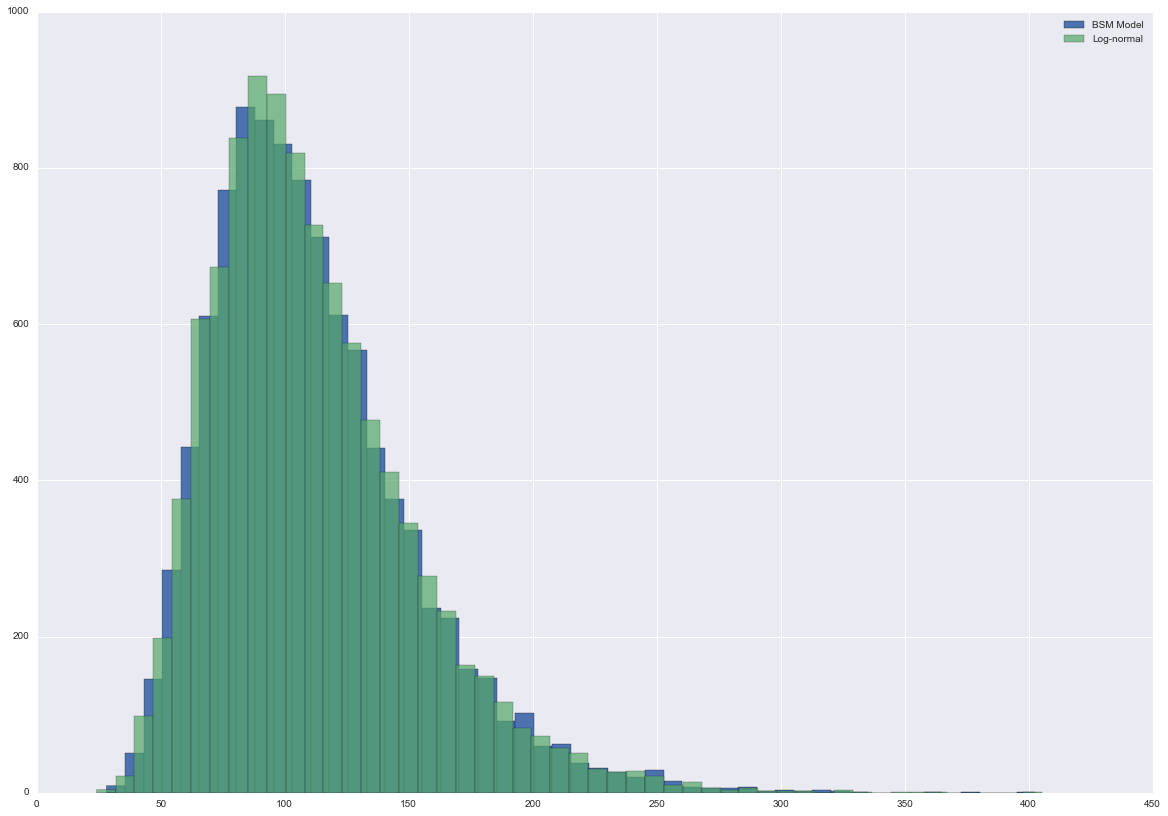

In [273]:
# Plot suggests that the variable distribution is log-normal
# Let's verify it by a quick comparison and significane calculation

ST2 = S0 * npr.lognormal((r - 0.5 * sigma**2) * T, sigma * np.sqrt(T), size=I)

display(np.corrcoef(sorted(ST2), sorted(ST1)))

plt.hist(ST2, bins=50)

plt.figure()

plt.hist(ST1, bins=50)
plt.hist(ST2, bins=50, alpha=0.7) # alpha makes the plot transparent
plt.legend(['BSM Model', 'Log-normal'])

Dynamic index simulation with Black-Scholes-Merton setup


Geometric Brownian Motion: $ dS_t = r S_t dt + \sigma S_t d Z_t $

Dynamic setup: $ S_t = S_{t - \Delta t}  exp \left( \left( r - \frac{1}{2} \sigma^2 \right) \Delta t + \sigma \sqrt(\delta t) z_t \right)$ 

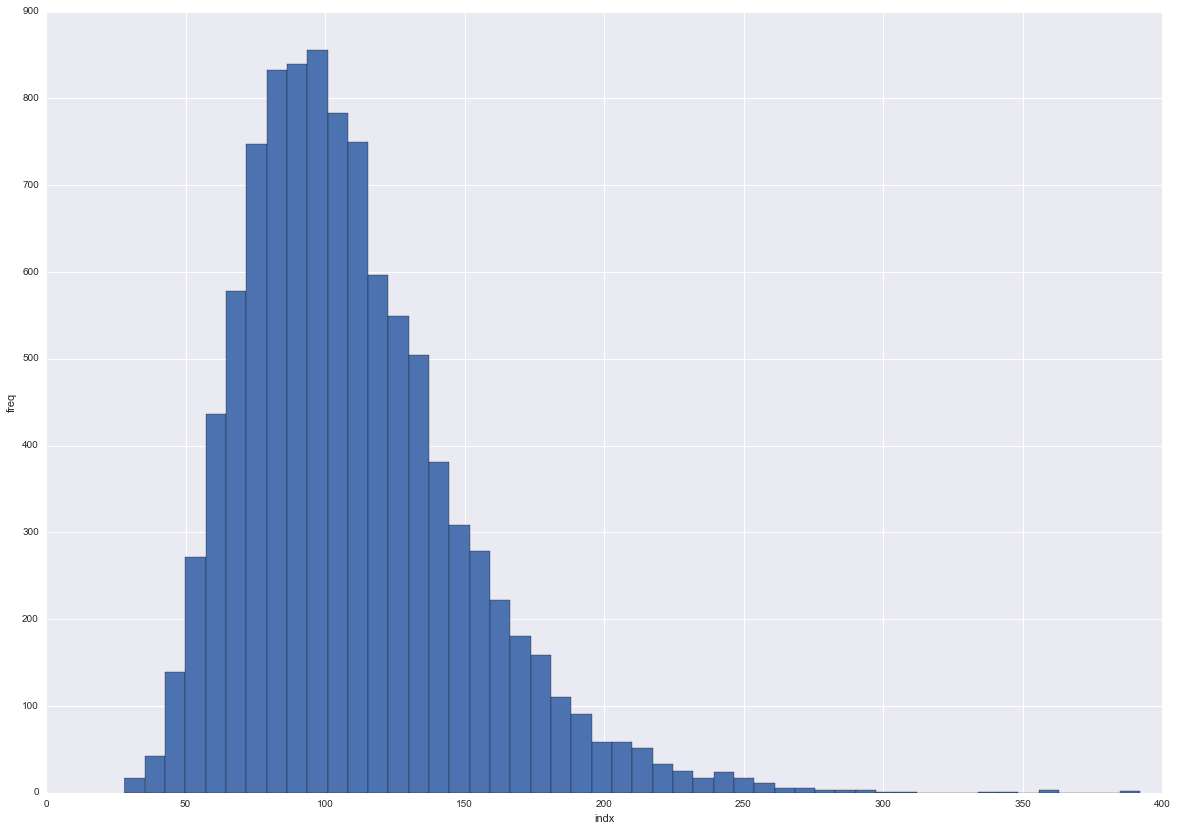

In [276]:
I = 10000
M = 50
dt = T / M
S = np.zeros((M+1, I))
S[0] = S0

for t in range(1, M+1):
    S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * npr.standard_normal(I))
    
plt.hist(S[-1], bins=50)
plt.xlabel('indx')
plt.ylabel('freq')

In [300]:
import scipy.stats as scs
def print_statistics(*args, labels=None):
    ''' Prints selected statistics.
    Parameters
    ==========
    a1, a2 : ndarray objects
    results object from simulation
    '''
    
    def print_header(headers):
        print_format = "{:14s}" + "{:>14s}"*(len(headers))
        print(print_format.format('statistic', *headers))
    
    def print_row(label, args):
        print_format = "{:14s}" + "{:14.3f}"*len(args)
        print(print_format.format(label, *args))
    
    stats = [scs.describe(a) for a in args]
    print()
    if labels:
        print_header(labels)
    else:
        print_header(['data set {}'.format(i) for i in range(1,len(args)+1)])
    
    print("-"*(15*(len(args)+1)))
    
    print_row('size', [stat[0] for stat in stats])
    print_row('min', [stat[1][0] for stat in stats])
    print_row('max', [stat[1][1] for stat in stats])
    print_row('max', [stat[1][1] for stat in stats])
    print_row('mean', [stat[2] for stat in stats])
    print_row('std', [stat[3] for stat in stats])
    print_row('skew', [stat[4] for stat in stats])
    print_row('kurtosis', [stat[5] for stat in stats])
    print()

In [303]:
S.shape

(51, 10000)


statistic            dynamic     BSM model    log-normal
------------------------------------------------------------
size               10000.000     10000.000     10000.000
min                   28.053        28.118        24.163
max                  392.169       402.698       405.320
max                  392.169       402.698       405.320
mean                 109.615       111.034       110.920
std                 1557.639      1650.617      1632.084
skew                   1.099         1.138         1.135
kurtosis               2.244         2.231         2.219



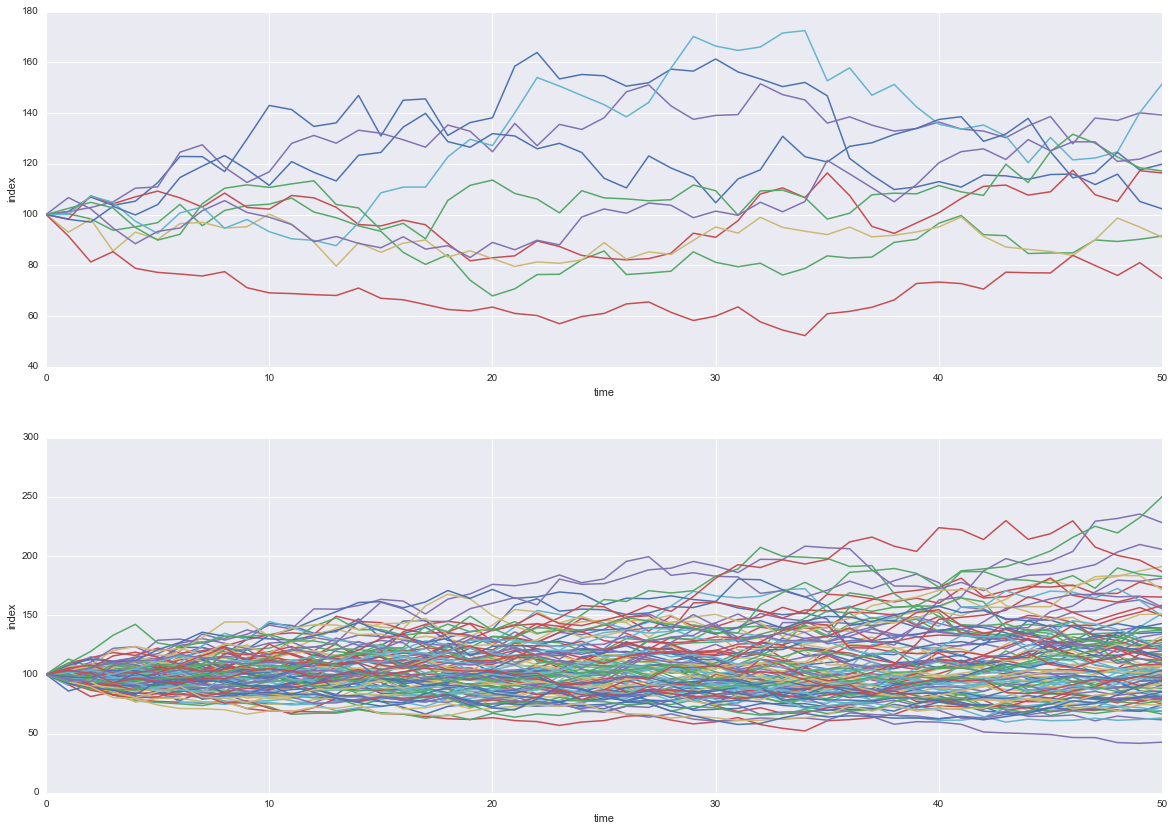

In [308]:
print_statistics(S[-1], ST1, ST2, labels=['dynamic', 'BSM model', 'log-normal'])

plt.subplot(2, 1, 1)
plt.plot(S[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index')

plt.subplot(2, 1, 2)
plt.plot(S[:, :100], lw=1.5)
plt.xlabel('time')
plt.ylabel('index')

Here, we can see very nicely how price uncertanity rises with time. You can relate it, for example, to option pricing.

For more interesting information about using Pandas for Finance, I really recommend ["Python for Finance" by Yves Hilpisch](http://www.amazon.co.uk/Python-Finance-Analyze-Financial-Data/dp/1491945281/).

# Homework

1. Investigate a stock or a group of stocks to find some interesting pattern, discover event, etc. Once found viusalize and search for the explanation.

2. Perform economics simulation with own distribution, transaction, and interaction model. What models make rich richer and poor poorer and which bring the wealth distribution to a balance. Plot and share findings.

3. Try to perform more advanced stock analysis and predict future valuations or discover interesting trends.

The report should be a notebook with some additional description. Share it on Slack or upload to your GitHub and share a link (GitHub renders Jupyter Notebooks).

Additional (optional) reading:
 * http://www.gregreda.com/2013/10/26/working-with-pandas-dataframes/
 * http://pandas.pydata.org/pandas-docs/stable/computation.html#rolling-windows
 * http://www.investor.jnj.com/stocksplit.cfm
 * https://help.yahoo.com/kb/finance/historical-prices-sln2311.html?impressions=true#cont3
 * http://quant-econ.net/py/pandas.html
 * https://en.wikipedia.org/wiki/Volume_(finance)